In [36]:
import warnings
warnings.filterwarnings('ignore')

import datetime
from pathlib import Path
from typing import Dict, List

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

import mne

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [37]:
INPUT_DIR = Path()
DATA_DIR = INPUT_DIR / "sleep-stage-detection/"
EDF_DIR = DATA_DIR / "edf_data"

df_train = pd.read_csv(DATA_DIR/"train_records.csv")
df_test = pd.read_csv(DATA_DIR/"test_records.csv")
sample_submission_df = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])

In [38]:
def epoch_to_df(epoch:mne.epochs.Epochs) -> pd.DataFrame:
    truncate_start_point = epoch.info["temp"]["truncate_start_point"]
    
    df = epoch.to_data_frame(verbose=False)
    
    new_meas_date = epoch.info["meas_date"].replace(tzinfo=None) + datetime.timedelta(seconds=truncate_start_point)
    
    df["meas_time"] = pd.date_range(start=new_meas_date, periods=len(df), freq=pd.Timedelta(1 / 100, unit="s"))
    
    return df

def epoch_to_sub_df(epoch_df:pd.DataFrame, id, is_train:bool) -> pd.DataFrame:
    cols = ["id", "meas_time"]
    if is_train:
        # 訓練セットの場合はラベルを追加
        cols.append("condition")
    
    label_df = epoch_df.loc[epoch_df.groupby("epoch")["time"].idxmin()].reset_index(drop=True)
    label_df["id"] = id
    
    return label_df[cols]

def read_and_set_annoation(record_df:pd.DataFrame, include=None, is_test=False) -> List[mne.epochs.Epochs]:
    whole_epoch_data = []

    for row_id, row in tqdm(record_df.iterrows(), total=len(record_df)):        
        # PSGファイルとHypnogram(アノテーションファイルを読み込む)
        psg_edf = mne.io.read_raw_edf(row["psg"], include=include, verbose=False)
        
        if not is_test:
            # 訓練データの場合
            annot = mne.read_annotations(row["hypnogram"])

            # 切り捨て
            truncate_start_point = 3600 * 5
            truncate_end_point = (len(psg_edf)/100) - (3600 *5)
            annot.crop(truncate_start_point, truncate_end_point, verbose=False)

            # アノテーションデータの切り捨て
            psg_edf.set_annotations(annot, emit_warning=False)
            events, _ = mne.events_from_annotations(psg_edf, event_id=RANDK_LABEL2ID, chunk_duration=30., verbose=False)
            
            event_id = LABEL2ID
        else:
            # テストデータの場合
            start_psg_date = psg_edf.info["meas_date"]
            start_psg_date = start_psg_date.replace(tzinfo=None)

            test_start_time = sample_submission_df[sample_submission_df["id"]==row["id"]]["meas_time"].min()
            test_end_time = sample_submission_df[sample_submission_df["id"]==row["id"]]["meas_time"].max()
            
            truncate_start_point = int((test_start_time - start_psg_date).total_seconds())
            truncate_end_point = int((test_end_time- start_psg_date).total_seconds())+30
            
            event_range = list(range(truncate_start_point, truncate_end_point, 30))
            events = np.zeros((len(event_range), 3), dtype=int)
            events[:, 0] = event_range
            events = events * 100
            
            event_id = {'Sleep stage W': 0}
            
    
        # 30秒毎に1epochとする
        tmax = 30. - 1. / psg_edf.info['sfreq']
        epoch = mne.Epochs(raw=psg_edf, events=events, event_id=event_id, tmin=0, tmax=tmax, baseline=None, verbose=False, on_missing='ignore')
        
        # 途中でデータが落ちてないかチェック
        assert len(epoch.events) * 30 == truncate_end_point - truncate_start_point
        
        # メタデータを追加
        epoch.info["temp"] = {
            "id":row["id"],
            "subject_id":row["subject_id"],
            "night":row["night"],
            "age":row["age"],
            "sex":row["sex"],
            "truncate_start_point":truncate_start_point
        }

        whole_epoch_data.append(epoch)

    return whole_epoch_data 

In [39]:
# ラベル名をIDに置き換える
# Sleep stage 3とSleep stage 4を同じIDとして、AASMによる分類に変更する
RANDK_LABEL2ID = {
    'Movement time': -1,
    'Sleep stage ?': -1,
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

# AASMによる分類
LABEL2ID = {
    'Movement time': -1,
    'Sleep stage ?': -1,
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3/4': 3,
    'Sleep stage R': 4
}
ID2LABEL = {v:k for k, v in LABEL2ID.items()}

In [40]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data. 
    """
    # specific frequency bands(EEGの分類だが細かいのでEOGもこれでやる)
    FREQ_BANDS = {"delta": [0.4, 4],
                  "theta": [4, 8],
                  "alpha-s": [8, 9],
                  "alpha-m": [9, 12],
                  "alpha-f": [12, 14],
                  "beta": [14, 26],
                  "gamma-l": [30, 50],
                  "gamma-m": [60, 80],
                  "gamma-h":[90,110]}

    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30 ,verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [41]:
# パスを設定
df_train["hypnogram"] = df_train["hypnogram"].map(lambda x: str(EDF_DIR/x))
df_train["psg"] = df_train["psg"].map(lambda x: str(EDF_DIR/x))
df_test["psg"] = df_test["psg"].map(lambda x: str(EDF_DIR/x))

In [42]:
train_epoch = read_and_set_annoation(df_train, include=['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal'], is_test=False)
test_epoch = read_and_set_annoation(df_test, include=['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal'], is_test=True)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [43]:
train_df = []
for epoch in tqdm(train_epoch):
    # 波形をdataframe化
    epoch_df = epoch_to_df(epoch)
    # submit形式のデータフレーム生成
    sub_df = epoch_to_sub_df(epoch_df, epoch.info["temp"]["id"], is_train=True)
    
    # パワースペクトル密度計算
    feature_df = pd.DataFrame(eeg_power_band(epoch))
    
    _df = pd.concat([sub_df, feature_df], axis=1)
#    # 必要ないラベルがある場合は除外する
#    _df = _df[~_df["condition"].isin(["Sleep stage ?", "Movement time"])]
    
    train_df.append(_df)
    
train_df = pd.concat(train_df).reset_index(drop=True)
#train_df

  0%|          | 0/108 [00:00<?, ?it/s]

In [44]:
test_df = []
for epoch in tqdm(test_epoch):
    # 波形をdataframe化
    epoch_df = epoch_to_df(epoch)
    # submit形式のデータフレーム生成
    sub_df = epoch_to_sub_df(epoch_df, epoch.info["temp"]["id"], is_train=False)

    # パワースペクトル密度計算
    feature_df = pd.DataFrame(eeg_power_band(epoch))
    
    _df = pd.concat([sub_df, feature_df], axis=1)
    
    test_df.append(pd.concat([sub_df, feature_df], axis=1))
    
test_df = pd.concat(test_df).reset_index(drop=True)
#test_df

  0%|          | 0/45 [00:00<?, ?it/s]

In [45]:
# gamma_mとgamma_hはNaNなので削除
train_df = train_df.drop({21,22,23,24,25,26}, axis=1)
test_df = test_df.drop({21,22,23,24,25,26}, axis=1)

In [46]:
# カラム名の変更
wave_list = ["EEG_F", "EEG_P", "EOG"]
hz_list = ["delta", "theta", "alpha_s", "alpha_m", "alpha_f", "beta", "gamma_l"]

column_list_train = ["id", "meas_time", "condition"]
column_list_test = ["id", "meas_time"]
for i in range(len(hz_list)):
    for j in range(len(wave_list)):
        column_list_train.append(wave_list[j]+str("_")+hz_list[i])
        column_list_test.append(wave_list[j]+str("_")+hz_list[i])

In [47]:
train_df = train_df.set_axis(column_list_train, axis=1)
test_df = test_df.set_axis(column_list_test, axis=1)

In [48]:
# alphaの合計を特徴量に
train_df["EEG_F_alpha"] = train_df["EEG_F_alpha_s"]+train_df["EEG_F_alpha_m"]+train_df["EEG_F_alpha_f"]
train_df["EEG_P_alpha"] = train_df["EEG_P_alpha_s"]+train_df["EEG_P_alpha_m"]+train_df["EEG_P_alpha_f"]
train_df["EOG_alpha"] = train_df["EOG_alpha_s"]+train_df["EOG_alpha_m"]+train_df["EOG_alpha_f"]

test_df["EEG_F_alpha"] = test_df["EEG_F_alpha_s"]+test_df["EEG_F_alpha_m"]+test_df["EEG_F_alpha_f"]
test_df["EEG_P_alpha"] = test_df["EEG_P_alpha_s"]+test_df["EEG_P_alpha_m"]+test_df["EEG_P_alpha_f"]
test_df["EOG_alpha"] = test_df["EOG_alpha_s"]+test_df["EOG_alpha_m"]+test_df["EOG_alpha_f"]

In [49]:
train_df.to_csv("df_train_eeg-2.csv", index=False)
test_df.to_csv("df_test_eeg-2.csv", index=False)

In [50]:
#lights_offへの日付追加

def lights_off_day(df):
    for i in range(len(df)):
        # edfファイルの読み込み
        psg_edf = mne.io.read_raw_edf(df["psg"][i], preload=False)

        #データ取り出し
        psg_df = psg_edf.to_data_frame()
        meas_start = psg_edf.info["meas_date"]
        meas_start = meas_start.replace(tzinfo=None)
        # 100Hz
        psg_df["meas_time"] = pd.date_range(start=meas_start, periods=len(psg_df), freq=pd.Timedelta(1 / 100, unit="s"))

        #追加
        date = psg_df["meas_time"][0]
        #日をまたいでいるかを判定して追加
        if (int(df["lights_off"][i][0:2]) < 24) & (int(df["lights_off"][i][0:2]) > 12):
            df["lights_off"][i] = pd.to_datetime(str(date.year)+"-"+str(date.month)+"-"+str(date.day)+" "+df["lights_off"][i], format = '%Y-%m-%d %H:%M:%S')
        else:
            df["lights_off"][i] = pd.to_datetime(str(date.year)+"-"+str(date.month)+"-"+str(date.day)+" "+df["lights_off"][i], format = '%Y-%m-%d %H:%M:%S') + datetime.timedelta(days=1)

In [51]:
lights_off_day(df_train)
lights_off_day(df_test)

Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\3c1c5cf-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\8fbd71b-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\9d5e9ec-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\e0df8c0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\3e404fc-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\a789657-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\69f0e24-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\e002a30-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\1a895e6-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\ace9475-PSG.edf...
EDF file d

Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\7b874dd-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\5f1765c-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\680f694-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\6c943b6-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\169c666-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\d469935-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\e9b6569-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\ef0038b-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\422e4d6-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\yuma0\Desktop\Nishika\睡眠\sleep-stage-detection\edf_data\886ed0a-PSG.edf...
EDF file d

In [52]:
#基本特徴量(night,age,sex,lights_off)

def feature_plus(df, df2):
    df["night"] = 0
    df["age"] = 0
    df["sex"] = ""
    df["lights_off"] = ""

    for i in range(len(df)):
        df["night"][i] = df2["night"][df2["id"] == df["id"][i]]
        df["age"][i] = df2["age"][df2["id"] == df["id"][i]]
        df["sex"][i] = df2["sex"][df2["id"] == df["id"][i]][df2["lights_off"][df2["id"] == df["id"][i]].index[0]]
        df["lights_off"][i] = df2["lights_off"][df2["id"] == df["id"][i]][df2["lights_off"][df2["id"] == df["id"][i]].index[0]]
        
    df["meas_time"] = pd.to_datetime(df["meas_time"], format = '%Y-%m-%d %H:%M:%S')
    df["off_time"] = df["meas_time"] - df["lights_off"]

    #消した後のみ反映
    for i in range(len(df)):
        if df["off_time"][i].total_seconds() < 0:
            df["off_time"][i] = 0
        else:
            df["off_time"][i] = df["off_time"][i].total_seconds()
            
    #lights_offの削除
    new_df = df.drop("lights_off", axis=1)
    
    return new_df

In [53]:
new_train_df = feature_plus(train_df, df_train)
new_test_df = feature_plus(test_df, df_test)

In [54]:
#sexのカテゴリー化
def cat_sex(df):
    le_sex = LabelEncoder()
    le_sex = le_sex.fit(df['sex'])
    df['sex'] = le_sex.transform(df['sex'])

In [55]:
cat_sex(new_train_df)
cat_sex(new_test_df)

In [56]:
new_train_df.to_csv("new_train_df-2.csv", index=False)
new_test_df.to_csv("new_test_df-2.csv", index=False)

In [57]:
#特徴量追加(train)

#EEG F
EEG_F_mean = []
EEG_F_std = []
EEG_F_mean_2 = [] #epoch平均-全体平均
EEG_F_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
EEG_F_mean_s = []
EEG_F_std_s = []

#EEG P
EEG_P_mean = []
EEG_P_std = []
EEG_P_mean_2 = [] #epoch平均-全体平均
EEG_P_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
EEG_P_mean_s = []
EEG_P_std_s = []

#EOG
EOG_mean = []
EOG_std = []
EOG_mean_2 = [] #epoch平均-全体平均
EOG_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
EOG_mean_s = []
EOG_std_s = []

#Resp
Resp_mean = []
Resp_std = []
Resp_mean_2 = [] #epoch平均-全体平均
Resp_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
Resp_mean_s = []
Resp_std_s = []

#EMG
EMG_mean = []
EMG_std = []
EMG_mean_2 = [] #epoch平均-全体平均
EMG_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
EMG_mean_s = []
EMG_std_s = []

#Temp
Temp_mean = []
Temp_std = []
Temp_mean_2 = [] #epoch平均-全体平均
Temp_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
Temp_mean_s = []
Temp_std_s = []

df_train_h = df_train[{"psg", "hypnogram"}]

for i in tqdm(range(len(df_train_h))):
    row = df_train_h.iloc[i]
    
    psg_edf = mne.io.read_raw_edf(row["psg"], include=None, verbose=False)
    annot = mne.read_annotations(row["hypnogram"])

    # 1時間(3600秒)*5
    truncate_start_point = 3600 * 5
    truncate_end_point = (len(psg_edf)/100) - (3600 *5)
    # 切り捨て
    annot.crop(truncate_start_point, truncate_end_point, verbose=False)

    # annotationデータを紐づけます
    psg_edf.set_annotations(annot, verbose=False, emit_warning=False)

    # 30秒毎に分割された睡眠段階
    events, _ = mne.events_from_annotations(psg_edf, event_id=RANDK_LABEL2ID, chunk_duration=30., verbose=False)

    # 30秒毎に1epochとする
    tmax = 30. - 1. / psg_edf.info['sfreq']
    epoch = mne.Epochs(raw=psg_edf, events=events, event_id=LABEL2ID, tmin=0, tmax=tmax, baseline=None, verbose=False, on_missing='ignore')

    # subjectとnightの設定 
#    epoch.info["temp"] = {
#        "id":row["id"],
#        "subject_id":row["subject_id"],
#        "night":row["night"],
#        "truncate_start_point":truncate_start_point,
#        "truncate_end_point":truncate_end_point
#    }
    
    epoch_df = epoch.to_data_frame(verbose=False)
    
    EEG_F = np.array(epoch_df["EEG Fpz-Cz"])
    EEG_F_mean_all = np.mean(EEG_F)
    EEG_F_std_all = np.std(EEG_F)
    
    EEG_P = np.array(epoch_df["EEG Pz-Oz"])
    EEG_P_mean_all = np.mean(EEG_P)
    EEG_P_std_all = np.std(EEG_P)
    
    EOG = np.array(epoch_df["EOG horizontal"])
    EOG_mean_all = np.mean(EOG)
    EOG_std_all = np.std(EOG)
    
    Resp = np.array(epoch_df["Resp oro-nasal"])
    Resp_mean_all = np.mean(Resp)
    Resp_std_all = np.std(Resp)
    
    EMG = np.array(epoch_df["EMG submental"])
    EMG_mean_all = np.mean(EMG)
    EMG_std_all = np.std(EMG)
    
    Temp = np.array(epoch_df["Temp rectal"])
    Temp_mean_all = np.mean(Temp)
    Temp_std_all = np.std(Temp)
    
    
    epoch_df2 = epoch_df.drop("condition", axis=1) #文字のカラム削除
    epoch_df2["EEG Fpz-Cz"] = (epoch_df["EEG Fpz-Cz"] - EEG_F_mean_all)/EEG_F_std_all
    epoch_df2["EEG Pz-Oz"] = (epoch_df["EEG Pz-Oz"] - EEG_P_mean_all)/EEG_P_std_all
    epoch_df2["EOG horizontal"] = (epoch_df["EOG horizontal"] - EOG_mean_all)/EOG_std_all
    epoch_df2["Resp oro-nasal"] = (epoch_df["Resp oro-nasal"] - Resp_mean_all)/Resp_std_all
    epoch_df2["EMG submental"] = (epoch_df["EMG submental"] - EMG_mean_all)/EMG_std_all
    epoch_df2["Temp rectal"] = (epoch_df["Temp rectal"] - Temp_mean_all)/Temp_std_all

    for e in tqdm(range(max(epoch_df["epoch"])+1)):
        
        EEG_F_e = np.array(epoch_df[epoch_df["epoch"] == e]["EEG Fpz-Cz"])
        EEG_F_mean = np.append(EEG_F_mean, np.mean(EEG_F_e))
        EEG_F_std = np.append(EEG_F_std, np.std(EEG_F_e))
        EEG_F_mean_2 = np.append(EEG_F_mean_2, np.mean(EEG_F_e) - EEG_F_mean_all)
        EEG_F_std_2 = np.append(EEG_F_std_2, np.mean(EEG_F_e) - EEG_F_std_all)        
        EEG_F_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EEG Fpz-Cz"])
        EEG_F_mean_s = np.append(EEG_F_mean_s, np.mean(EEG_F_std_e))
        EEG_F_std_s = np.append(EEG_F_std_s, np.std(EEG_F_std_e))

        EEG_P_e = np.array(epoch_df[epoch_df["epoch"] == e]["EEG Pz-Oz"])
        EEG_P_mean = np.append(EEG_P_mean, np.mean(EEG_P_e))
        EEG_P_std = np.append(EEG_P_std, np.std(EEG_P_e))
        EEG_P_mean_2 = np.append(EEG_P_mean_2, np.mean(EEG_P_e) - EEG_P_mean_all)
        EEG_P_std_2 = np.append(EEG_P_std_2, np.mean(EEG_P_e) - EEG_P_std_all)        
        EEG_P_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EEG Pz-Oz"])
        EEG_P_mean_s = np.append(EEG_P_mean_s, np.mean(EEG_P_std_e))
        EEG_P_std_s = np.append(EEG_P_std_s, np.std(EEG_P_std_e))

        EOG_e = np.array(epoch_df[epoch_df["epoch"] == e]["EOG horizontal"])
        EOG_mean = np.append(EOG_mean, np.mean(EOG_e))
        EOG_std = np.append(EOG_std, np.std(EOG_e))
        EOG_mean_2 = np.append(EOG_mean_2, np.mean(EOG_e) - EOG_mean_all)
        EOG_std_2 = np.append(EOG_std_2, np.mean(EOG_e) - EOG_std_all)        
        EOG_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EOG horizontal"])
        EOG_mean_s = np.append(EOG_mean_s, np.mean(EOG_std_e))
        EOG_std_s = np.append(EOG_std_s, np.std(EOG_std_e))

        Resp_e = np.array(epoch_df[epoch_df["epoch"] == e]["Resp oro-nasal"])
        Resp_mean = np.append(Resp_mean, np.mean(Resp_e))
        Resp_std = np.append(Resp_std, np.std(Resp_e))
        Resp_mean_2 = np.append(Resp_mean_2, np.mean(Resp_e) - Resp_mean_all)
        Resp_std_2 = np.append(Resp_std_2, np.mean(Resp_e) - Resp_std_all)        
        Resp_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["Resp oro-nasal"])
        Resp_mean_s = np.append(Resp_mean_s, np.mean(Resp_std_e))
        Resp_std_s = np.append(Resp_std_s, np.std(Resp_std_e))

        EMG_e = np.array(epoch_df[epoch_df["epoch"] == e]["EMG submental"])
        EMG_mean = np.append(EMG_mean, np.mean(EMG_e))
        EMG_std = np.append(EMG_std, np.std(EMG_e))
        EMG_mean_2 = np.append(EMG_mean_2, np.mean(EMG_e) - EMG_mean_all)
        EMG_std_2 = np.append(EMG_std_2, np.mean(EMG_e) - EMG_std_all)        
        EMG_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EMG submental"])
        EMG_mean_s = np.append(EMG_mean_s, np.mean(EMG_std_e))
        EMG_std_s = np.append(EMG_std_s, np.std(EMG_std_e))

        Temp_e = np.array(epoch_df[epoch_df["epoch"] == e]["Temp rectal"])
        Temp_mean = np.append(Temp_mean, np.mean(Temp_e))
        Temp_std = np.append(Temp_std, np.std(Temp_e))
        Temp_mean_2 = np.append(Temp_mean_2, np.mean(Temp_e) - Temp_mean_all)
        Temp_std_2 = np.append(Temp_std_2, np.mean(Temp_e) - Temp_std_all)        
        Temp_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["Temp rectal"])
        Temp_mean_s = np.append(Temp_mean_s, np.mean(Temp_std_e))
        Temp_std_s = np.append(Temp_std_s, np.std(Temp_std_e))


df_feature = pd.DataFrame({"EEG_F_mean": EEG_F_mean,
                           "EEG_F_std": EEG_F_std,
                           "EEG_F_mean_2": EEG_F_mean_2,
                           "EEG_F_std_2": EEG_F_std_2,
                           "EEG_F_mean_s": EEG_F_mean_s,
                           "EEG_F_std_s": EEG_F_std_s,
                           "EEG_P_mean": EEG_P_mean,
                           "EEG_P_std": EEG_P_std,
                           "EEG_P_mean_2": EEG_P_mean_2,
                           "EEG_P_std_2": EEG_P_std_2,
                           "EEG_P_mean_s": EEG_P_mean_s,
                           "EEG_P_std_s": EEG_P_std_s,
                           "EOG_mean": EOG_mean,
                           "EOG_std": EOG_std,
                           "EOG_mean_2": EOG_mean_2,
                           "EOG_std_2": EOG_std_2,
                           "EOG_mean_s": EOG_mean_s,
                           "EOG_std_s": EOG_std_s,
                           "Resp_mean": Resp_mean,
                           "Resp_std": Resp_std,
                           "Resp_mean_2": Resp_mean_2,
                           "Resp_std_2": Resp_std_2,
                           "Resp_mean_s": Resp_mean_s,
                           "Resp_std_s": Resp_std_s,
                           "EMG_mean": EMG_mean,
                           "EMG_std": EMG_std,
                           "EMG_mean_2": EMG_mean_2,
                           "EMG_std_2": EMG_std_2,
                           "EMG_mean_s": EMG_mean_s,
                           "EMG_std_s": EMG_std_s,
                           "Temp_mean": Temp_mean,
                           "Temp_std": Temp_std,
                           "Temp_mean_2": Temp_mean_2,
                           "Temp_std_2": Temp_std_2,
                           "Temp_mean_s": Temp_mean_s,
                           "Temp_std_s": Temp_std_s,
                          })

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/1430 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1604 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/1556 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1630 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/1490 [00:00<?, ?it/s]

  0%|          | 0/1416 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1494 [00:00<?, ?it/s]

  0%|          | 0/1442 [00:00<?, ?it/s]

  0%|          | 0/1580 [00:00<?, ?it/s]

  0%|          | 0/1522 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/1502 [00:00<?, ?it/s]

  0%|          | 0/1510 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1552 [00:00<?, ?it/s]

  0%|          | 0/1574 [00:00<?, ?it/s]

  0%|          | 0/1410 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/840 [00:00<?, ?it/s]

  0%|          | 0/1530 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/1440 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/1402 [00:00<?, ?it/s]

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1466 [00:00<?, ?it/s]

  0%|          | 0/1490 [00:00<?, ?it/s]

  0%|          | 0/1450 [00:00<?, ?it/s]

  0%|          | 0/1542 [00:00<?, ?it/s]

  0%|          | 0/1524 [00:00<?, ?it/s]

  0%|          | 0/1580 [00:00<?, ?it/s]

  0%|          | 0/1320 [00:00<?, ?it/s]

  0%|          | 0/1556 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1202 [00:00<?, ?it/s]

  0%|          | 0/1216 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

  0%|          | 0/1270 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

  0%|          | 0/1424 [00:00<?, ?it/s]

  0%|          | 0/1496 [00:00<?, ?it/s]

  0%|          | 0/1656 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/1434 [00:00<?, ?it/s]

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/1664 [00:00<?, ?it/s]

  0%|          | 0/1580 [00:00<?, ?it/s]

  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/1532 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1510 [00:00<?, ?it/s]

  0%|          | 0/1332 [00:00<?, ?it/s]

  0%|          | 0/1142 [00:00<?, ?it/s]

  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/1504 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1522 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

  0%|          | 0/1528 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/1446 [00:00<?, ?it/s]

  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/1660 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1650 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/1470 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1066 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/1574 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/1596 [00:00<?, ?it/s]

  0%|          | 0/1434 [00:00<?, ?it/s]

  0%|          | 0/1604 [00:00<?, ?it/s]

  0%|          | 0/1556 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1370 [00:00<?, ?it/s]

  0%|          | 0/1592 [00:00<?, ?it/s]

  0%|          | 0/1540 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

In [58]:
#特徴量追加(test)

#EEG F
t_EEG_F_mean = []
t_EEG_F_std = []
t_EEG_F_mean_2 = [] #epoch平均-全体平均
t_EEG_F_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_EEG_F_mean_s = []
t_EEG_F_std_s = []

#EEG P
t_EEG_P_mean = []
t_EEG_P_std = []
t_EEG_P_mean_2 = [] #epoch平均-全体平均
t_EEG_P_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_EEG_P_mean_s = []
t_EEG_P_std_s = []

#EOG
t_EOG_mean = []
t_EOG_std = []
t_EOG_mean_2 = [] #epoch平均-全体平均
t_EOG_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_EOG_mean_s = []
t_EOG_std_s = []

#Resp
t_Resp_mean = []
t_Resp_std = []
t_Resp_mean_2 = [] #epoch平均-全体平均
t_Resp_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_Resp_mean_s = []
t_Resp_std_s = []

#EMG
t_EMG_mean = []
t_EMG_std = []
t_EMG_mean_2 = [] #epoch平均-全体平均
t_EMG_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_EMG_mean_s = []
t_EMG_std_s = []

#Temp
t_Temp_mean = []
t_Temp_std = []
t_Temp_mean_2 = [] #epoch平均-全体平均
t_Temp_std_2 = [] #epoch標準偏差-全体標準偏差
#標準化後
t_Temp_mean_s = []
t_Temp_std_s = []

for i in tqdm(range(len(df_test))):
    row = df_test.iloc[i]
    
    psg_edf = mne.io.read_raw_edf(row["psg"], include=None, verbose=False)

    start_psg_date = psg_edf.info["meas_date"]
    start_psg_date = start_psg_date.replace(tzinfo=None)

    test_start_time = sample_submission_df[sample_submission_df["id"]==row["id"]]["meas_time"].min()
    test_end_time = sample_submission_df[sample_submission_df["id"]==row["id"]]["meas_time"].max()

    truncate_start_point = int((test_start_time - start_psg_date).total_seconds())
    truncate_end_point = int((test_end_time- start_psg_date).total_seconds())+30

    event_range = list(range(truncate_start_point, truncate_end_point, 30))
    events = np.zeros((len(event_range), 3), dtype=int)
    events[:, 0] = event_range
    events = events * 100

    event_id = {'Sleep stage W': 0}

    # 30秒毎に1epochとする
    tmax = 30. - 1. / psg_edf.info['sfreq']
    epoch = mne.Epochs(raw=psg_edf, events=events, event_id=LABEL2ID, tmin=0, tmax=tmax, baseline=None, verbose=False, on_missing='ignore')

    # subjectとnightの設定 
#    epoch.info["temp"] = {
#        "id":row["id"],
#        "subject_id":row["subject_id"],
#        "night":row["night"],
#        "truncate_start_point":truncate_start_point,
#        "truncate_end_point":truncate_end_point
#    }
    
    epoch_df = epoch.to_data_frame(verbose=False)
    
    t_EEG_F = np.array(epoch_df["EEG Fpz-Cz"])
    t_EEG_F_mean_all = np.mean(t_EEG_F)
    t_EEG_F_std_all = np.std(t_EEG_F)
    
    t_EEG_P = np.array(epoch_df["EEG Pz-Oz"])
    t_EEG_P_mean_all = np.mean(t_EEG_P)
    t_EEG_P_std_all = np.std(t_EEG_P)
    
    t_EOG = np.array(epoch_df["EOG horizontal"])
    t_EOG_mean_all = np.mean(t_EOG)
    t_EOG_std_all = np.std(t_EOG)
    
    t_Resp = np.array(epoch_df["Resp oro-nasal"])
    t_Resp_mean_all = np.mean(t_Resp)
    t_Resp_std_all = np.std(t_Resp)
    
    t_EMG = np.array(epoch_df["EMG submental"])
    t_EMG_mean_all = np.mean(t_EMG)
    t_EMG_std_all = np.std(t_EMG)
    
    t_Temp = np.array(epoch_df["Temp rectal"])
    t_Temp_mean_all = np.mean(t_Temp)
    t_Temp_std_all = np.std(t_Temp)
    
    
    epoch_df2 = epoch_df.drop("condition", axis=1) #文字のカラム削除
    epoch_df2["EEG Fpz-Cz"] = (epoch_df["EEG Fpz-Cz"] - t_EEG_F_mean_all)/t_EEG_F_std_all
    epoch_df2["EEG Pz-Oz"] = (epoch_df["EEG Pz-Oz"] - t_EEG_P_mean_all)/t_EEG_P_std_all
    epoch_df2["EOG horizontal"] = (epoch_df["EOG horizontal"] - t_EOG_mean_all)/t_EOG_std_all
    epoch_df2["Resp oro-nasal"] = (epoch_df["Resp oro-nasal"] - t_Resp_mean_all)/t_Resp_std_all
    epoch_df2["EMG submental"] = (epoch_df["EMG submental"] - t_EMG_mean_all)/t_EMG_std_all
    epoch_df2["Temp rectal"] = (epoch_df["Temp rectal"] - t_Temp_mean_all)/t_Temp_std_all

    for e in tqdm(range(max(epoch_df["epoch"])+1)):
        t_EEG_F_e = np.array(epoch_df[epoch_df["epoch"] == e]["EEG Fpz-Cz"])
        t_EEG_F_mean = np.append(t_EEG_F_mean, np.mean(t_EEG_F_e))
        t_EEG_F_std = np.append(t_EEG_F_std, np.std(t_EEG_F_e))
        t_EEG_F_mean_2 = np.append(t_EEG_F_mean_2, np.mean(t_EEG_F_e) - t_EEG_F_mean_all)
        t_EEG_F_std_2 = np.append(t_EEG_F_std_2, np.mean(t_EEG_F_e) - t_EEG_F_std_all)        
        t_EEG_F_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EEG Fpz-Cz"])
        t_EEG_F_mean_s = np.append(t_EEG_F_mean_s, np.mean(t_EEG_F_std_e))
        t_EEG_F_std_s = np.append(t_EEG_F_std_s, np.std(t_EEG_F_std_e))

        t_EEG_P_e = np.array(epoch_df[epoch_df["epoch"] == e]["EEG Pz-Oz"])
        t_EEG_P_mean = np.append(t_EEG_P_mean, np.mean(t_EEG_P_e))
        t_EEG_P_std = np.append(t_EEG_P_std, np.std(t_EEG_P_e))
        t_EEG_P_mean_2 = np.append(t_EEG_P_mean_2, np.mean(t_EEG_P_e) - t_EEG_P_mean_all)
        t_EEG_P_std_2 = np.append(t_EEG_P_std_2, np.mean(t_EEG_P_e) - t_EEG_P_std_all)        
        t_EEG_P_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EEG Pz-Oz"])
        t_EEG_P_mean_s = np.append(t_EEG_P_mean_s, np.mean(t_EEG_P_std_e))
        t_EEG_P_std_s = np.append(t_EEG_P_std_s, np.std(t_EEG_P_std_e))

        t_EOG_e = np.array(epoch_df[epoch_df["epoch"] == e]["EOG horizontal"])
        t_EOG_mean = np.append(t_EOG_mean, np.mean(t_EOG_e))
        t_EOG_std = np.append(t_EOG_std, np.std(t_EOG_e))
        t_EOG_mean_2 = np.append(t_EOG_mean_2, np.mean(t_EOG_e) - t_EOG_mean_all)
        t_EOG_std_2 = np.append(t_EOG_std_2, np.mean(t_EOG_e) - t_EOG_std_all)        
        t_EOG_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EOG horizontal"])
        t_EOG_mean_s = np.append(t_EOG_mean_s, np.mean(t_EOG_std_e))
        t_EOG_std_s = np.append(t_EOG_std_s, np.std(t_EOG_std_e))

        t_Resp_e = np.array(epoch_df[epoch_df["epoch"] == e]["Resp oro-nasal"])
        t_Resp_mean = np.append(t_Resp_mean, np.mean(t_Resp_e))
        t_Resp_std = np.append(t_Resp_std, np.std(t_Resp_e))
        t_Resp_mean_2 = np.append(t_Resp_mean_2, np.mean(t_Resp_e) - t_Resp_mean_all)
        t_Resp_std_2 = np.append(t_Resp_std_2, np.mean(t_Resp_e) - t_Resp_std_all)        
        t_Resp_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["Resp oro-nasal"])
        t_Resp_mean_s = np.append(t_Resp_mean_s, np.mean(t_Resp_std_e))
        t_Resp_std_s = np.append(t_Resp_std_s, np.std(t_Resp_std_e))

        t_EMG_e = np.array(epoch_df[epoch_df["epoch"] == e]["EMG submental"])
        t_EMG_mean = np.append(t_EMG_mean, np.mean(t_EMG_e))
        t_EMG_std = np.append(t_EMG_std, np.std(t_EMG_e))
        t_EMG_mean_2 = np.append(t_EMG_mean_2, np.mean(t_EMG_e) - t_EMG_mean_all)
        t_EMG_std_2 = np.append(t_EMG_std_2, np.mean(t_EMG_e) - t_EMG_std_all)        
        t_EMG_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["EMG submental"])
        t_EMG_mean_s = np.append(t_EMG_mean_s, np.mean(t_EMG_std_e))
        t_EMG_std_s = np.append(t_EMG_std_s, np.std(t_EMG_std_e))

        t_Temp_e = np.array(epoch_df[epoch_df["epoch"] == e]["Temp rectal"])
        t_Temp_mean = np.append(t_Temp_mean, np.mean(t_Temp_e))
        t_Temp_std = np.append(t_Temp_std, np.std(t_Temp_e))
        t_Temp_mean_2 = np.append(t_Temp_mean_2, np.mean(t_Temp_e) - t_Temp_mean_all)
        t_Temp_std_2 = np.append(t_Temp_std_2, np.mean(t_Temp_e) - t_Temp_std_all)        
        t_Temp_std_e = np.array(epoch_df2[epoch_df2["epoch"] == e]["Temp rectal"])
        t_Temp_mean_s = np.append(t_Temp_mean_s, np.mean(t_Temp_std_e))
        t_Temp_std_s = np.append(t_Temp_std_s, np.std(t_Temp_std_e))

df_feature_test = pd.DataFrame({"EEG_F_mean": t_EEG_F_mean,
                           "EEG_F_std": t_EEG_F_std,
                           "EEG_F_mean_2": t_EEG_F_mean_2,
                           "EEG_F_std_2": t_EEG_F_std_2,
                           "EEG_F_mean_s": t_EEG_F_mean_s,
                           "EEG_F_std_s": t_EEG_F_std_s,
                           "EEG_P_mean": t_EEG_P_mean,
                           "EEG_P_std": t_EEG_P_std,
                           "EEG_P_mean_2": t_EEG_P_mean_2,
                           "EEG_P_std_2": t_EEG_P_std_2,
                           "EEG_P_mean_s": t_EEG_P_mean_s,
                           "EEG_P_std_s": t_EEG_P_std_s,
                           "EOG_mean": t_EOG_mean,
                           "EOG_std": t_EOG_std,
                           "EOG_mean_2": t_EOG_mean_2,
                           "EOG_std_2": t_EOG_std_2,
                           "EOG_mean_s": t_EOG_mean_s,
                           "EOG_std_s": t_EOG_std_s,
                           "Resp_mean": t_Resp_mean,
                           "Resp_std": t_Resp_std,
                           "Resp_mean_2": t_Resp_mean_2,
                           "Resp_std_2": t_Resp_std_2,
                           "Resp_mean_s": t_Resp_mean_s,
                           "Resp_std_s": t_Resp_std_s,
                           "EMG_mean": t_EMG_mean,
                           "EMG_std": t_EMG_std,
                           "EMG_mean_2": t_EMG_mean_2,
                           "EMG_std_2": t_EMG_std_2,
                           "EMG_mean_s": t_EMG_mean_s,
                           "EMG_std_s": t_EMG_std_s,
                           "Temp_mean": t_Temp_mean,
                           "Temp_std": t_Temp_std,
                           "Temp_mean_2": t_Temp_mean_2,
                           "Temp_std_2": t_Temp_std_2,
                           "Temp_mean_s": t_Temp_mean_s,
                           "Temp_std_s": t_Temp_std_s,
                          })

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1063 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1127 [00:00<?, ?it/s]

  0%|          | 0/1070 [00:00<?, ?it/s]

  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/1087 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

  0%|          | 0/1597 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1052 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/964 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/1052 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1445 [00:00<?, ?it/s]

  0%|          | 0/1823 [00:00<?, ?it/s]

  0%|          | 0/2027 [00:00<?, ?it/s]

  0%|          | 0/1910 [00:00<?, ?it/s]

  0%|          | 0/1103 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/1273 [00:00<?, ?it/s]

  0%|          | 0/1064 [00:00<?, ?it/s]

  0%|          | 0/1072 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/962 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/1092 [00:00<?, ?it/s]

  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 0/1229 [00:00<?, ?it/s]

  0%|          | 0/2026 [00:00<?, ?it/s]

  0%|          | 0/1994 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

In [345]:
new_train_df_f_2 = pd.concat([new_train_df, df_feature], axis=1)
new_train_df_f_2.to_csv("new_train_df_f_2.csv", index=False)

new_test_df_f_2 = pd.concat([new_test_df, df_feature_test], axis=1)
new_test_df_f_2.to_csv("new_test_df_f_2.csv", index=False)

In [347]:
#n = 1

#lag
def lag(df, n, feature):
    df[feature + "_lag" +  str(n)] =  df[feature].shift(n)
    df[feature + "_lag" +  str(n)][0] = df[feature][0]
    for i in range(len(df)-1):
        if (df["id"][i+1] != df["id"][i]) or (df["night"][i+1] != df["night"][i]):
            df[feature + "_lag" +  str(n)][i+1] = df[feature][i+1]

#ma
def ma(df, n, feature):
    df[feature + "_ma"+str(n)] = df[feature].rolling(window=n+1).mean()
    df[feature + "_ma" +  str(n)][0] = df[feature][0]
    for i in range(len(df)-1):
        if (df["id"][i+1] != df["id"][i]) or (df["night"][i+1] != df["night"][i]):
            df[feature + "_ma" +  str(n)][i+1] = df[feature][i+1]
        
#max
def max_(df, n, feature):
    df[feature + "_max"+str(n)] = df[feature].rolling(window=n+1).max()
    df[feature + "_max" +  str(n)][0] = df[feature][0]
    for i in range(len(df)-1):
        if (df["id"][i+1] != df["id"][i]) or (df["night"][i+1] != df["night"][i]):
            df[feature + "_max" +  str(n)][i+1] = df[feature][i+1]
        
#min
def min_(df, n, feature):
    df[feature + "_min"+str(n)] = df[feature].rolling(window=n+1).min()
    df[feature + "_min" +  str(n)][0] = df[feature][0]
    for i in range(len(df)-1):
        if (df["id"][i+1] != df["id"][i]) or (df["night"][i+1] != df["night"][i]):
            df[feature + "_min" +  str(n)][i+1] = df[feature][i+1]
        
#deruta
def delta(df,n, feature):#t-1との差
    df[feature + "_deruta"+str(n)] = df[feature].diff(n)
    df[feature + "_deruta"+str(n)][0] = 0
    for i in range(len(df)-1):
        if (df["id"][i+1] != df["id"][i]) or (df["night"][i+1] != df["night"][i]):
            df[feature + "_deruta" +  str(n)][i+1] = 0

#一括作成
def feature_create(df, n, feature):
    lag(df, n, feature)
    ma(df, n, feature)
    max_(df, n, feature)
    min_(df, n, feature)
    delta(df, n, feature)

In [348]:
clm_list = new_train_df_f_2.columns
clm_list = clm_list.drop({"id","meas_time", "condition", "night", "age", "sex", "off_time"})
clm_list

Index(['EEG_F_delta', 'EEG_P_delta', 'EOG_delta', 'EEG_F_theta', 'EEG_P_theta',
       'EOG_theta', 'EEG_F_alpha_s', 'EEG_P_alpha_s', 'EOG_alpha_s',
       'EEG_F_alpha_m', 'EEG_P_alpha_m', 'EOG_alpha_m', 'EEG_F_alpha_f',
       'EEG_P_alpha_f', 'EOG_alpha_f', 'EEG_F_beta', 'EEG_P_beta', 'EOG_beta',
       'EEG_F_gamma_l', 'EEG_P_gamma_l', 'EOG_gamma_l', 'EEG_F_alpha',
       'EEG_P_alpha', 'EOG_alpha', 'EEG_F_mean', 'EEG_F_std', 'EEG_F_mean_2',
       'EEG_F_std_2', 'EEG_F_mean_s', 'EEG_F_std_s', 'EEG_P_mean', 'EEG_P_std',
       'EEG_P_mean_2', 'EEG_P_std_2', 'EEG_P_mean_s', 'EEG_P_std_s',
       'EOG_mean', 'EOG_std', 'EOG_mean_2', 'EOG_std_2', 'EOG_mean_s',
       'EOG_std_s', 'Resp_mean', 'Resp_std', 'Resp_mean_2', 'Resp_std_2',
       'Resp_mean_s', 'Resp_std_s', 'EMG_mean', 'EMG_std', 'EMG_mean_2',
       'EMG_std_2', 'EMG_mean_s', 'EMG_std_s', 'Temp_mean', 'Temp_std',
       'Temp_mean_2', 'Temp_std_2', 'Temp_mean_s', 'Temp_std_s'],
      dtype='object')

In [349]:
for i in range(len(clm_list)):
    feature_create(new_train_df_f_2,1,clm_list[i])
    feature_create(new_test_df_f_2,1,clm_list[i])
    feature_create(new_train_df_f_2,2,clm_list[i])
    feature_create(new_test_df_f_2,2,clm_list[i])

In [350]:
len(new_train_df_f_2.columns)

667

In [351]:
new_train_df_f_2

,id,meas_time,condition,EEG_F_delta,EEG_P_delta,EOG_delta,EEG_F_theta,EEG_P_theta,EOG_theta,EEG_F_alpha_s,...,Temp_std_s_lag1,Temp_std_s_ma1,Temp_std_s_max1,Temp_std_s_min1,Temp_std_s_deruta1,Temp_std_s_lag2,Temp_std_s_ma2,Temp_std_s_max2,Temp_std_s_min2,Temp_std_s_deruta2
0,3c1c5cf,1989-11-13 21:35:00,Sleep stage W,0.002020,0.003747,0.006674,0.000662,0.001028,0.000410,0.000823,...,0.133567,0.133567,0.133567,0.133567,0.000000,0.133567,0.133567,0.133567,0.133567,0.000000
1,3c1c5cf,1989-11-13 21:35:30,Sleep stage W,0.001859,0.003637,0.005949,0.000611,0.001149,0.000457,0.000677,...,0.133567,0.126137,0.133567,0.118706,-0.014861,NaN,NaN,NaN,NaN,NaN
2,3c1c5cf,1989-11-13 21:36:00,Sleep stage W,0.001936,0.003354,0.006467,0.000599,0.001125,0.000428,0.000620,...,0.118706,0.118056,0.118706,0.117406,-0.001300,0.133567,0.123226,0.133567,0.117406,-0.016161
3,3c1c5cf,1989-11-13 21:36:30,Sleep stage W,0.002962,0.003257,0.005194,0.000591,0.002354,0.000695,0.000606,...,0.117406,0.143279,0.169152,0.117406,0.051746,0.118706,0.135088,0.169152,0.117406,0.050446
4,3c1c5cf,1989-11-13 21:37:00,Sleep stage W,0.001650,0.002614,0.006452,0.000715,0.001325,0.000493,0.000398,...,0.169152,0.146539,0.169152,0.123927,-0.045224,0.117406,0.136828,0.169152,0.117406,0.006521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162103,5edb9d9,1990-03-14 08:17:30,Sleep stage 1,0.006747,0.006139,0.008127,0.000796,0.001317,0.000459,0.000673,...,0.290700,0.292220,0.293740,0.290700,0.003041,0.242156,0.275532,0.293740,0.242156,0.051585
162104,5edb9d9,1990-03-14 08:18:00,Sleep stage 1,0.006383,0.005772,0.008138,0.000775,0.001198,0.000451,0.000616,...,0.293740,0.286950,0.293740,0.280160,-0.013581,0.290700,0.288200,0.293740,0.280160,-0.010540
162105,5edb9d9,1990-03-14 08:18:30,Sleep stage 2,0.006068,0.006118,0.006762,0.001110,0.001638,0.000729,0.000481,...,0.280160,0.263869,0.280160,0.247579,-0.032581,0.293740,0.273826,0.293740,0.247579,-0.046162
162106,5edb9d9,1990-03-14 08:19:00,Sleep stage 2,0.005984,0.006028,0.007669,0.001133,0.001469,0.000652,0.001281,...,0.247579,0.269450,0.291321,0.247579,0.043743,0.280160,0.273020,0.291321,0.247579,0.011162


# 学習

In [352]:
# 必要ないラベルがある場合は除外する
new_train_df_f_2 = new_train_df_f_2[~new_train_df_f_2["condition"].isin(["Sleep stage ?", "Movement time"])]
new_train_df_f_2 = new_train_df_f_2.reset_index(drop=True)

In [353]:
new_train_df_f_2

,id,meas_time,condition,EEG_F_delta,EEG_P_delta,EOG_delta,EEG_F_theta,EEG_P_theta,EOG_theta,EEG_F_alpha_s,...,Temp_std_s_lag1,Temp_std_s_ma1,Temp_std_s_max1,Temp_std_s_min1,Temp_std_s_deruta1,Temp_std_s_lag2,Temp_std_s_ma2,Temp_std_s_max2,Temp_std_s_min2,Temp_std_s_deruta2
0,3c1c5cf,1989-11-13 21:35:00,Sleep stage W,0.002020,0.003747,0.006674,0.000662,0.001028,0.000410,0.000823,...,0.133567,0.133567,0.133567,0.133567,0.000000,0.133567,0.133567,0.133567,0.133567,0.000000
1,3c1c5cf,1989-11-13 21:35:30,Sleep stage W,0.001859,0.003637,0.005949,0.000611,0.001149,0.000457,0.000677,...,0.133567,0.126137,0.133567,0.118706,-0.014861,NaN,NaN,NaN,NaN,NaN
2,3c1c5cf,1989-11-13 21:36:00,Sleep stage W,0.001936,0.003354,0.006467,0.000599,0.001125,0.000428,0.000620,...,0.118706,0.118056,0.118706,0.117406,-0.001300,0.133567,0.123226,0.133567,0.117406,-0.016161
3,3c1c5cf,1989-11-13 21:36:30,Sleep stage W,0.002962,0.003257,0.005194,0.000591,0.002354,0.000695,0.000606,...,0.117406,0.143279,0.169152,0.117406,0.051746,0.118706,0.135088,0.169152,0.117406,0.050446
4,3c1c5cf,1989-11-13 21:37:00,Sleep stage W,0.001650,0.002614,0.006452,0.000715,0.001325,0.000493,0.000398,...,0.169152,0.146539,0.169152,0.123927,-0.045224,0.117406,0.136828,0.169152,0.117406,0.006521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161605,5edb9d9,1990-03-14 08:17:30,Sleep stage 1,0.006747,0.006139,0.008127,0.000796,0.001317,0.000459,0.000673,...,0.290700,0.292220,0.293740,0.290700,0.003041,0.242156,0.275532,0.293740,0.242156,0.051585
161606,5edb9d9,1990-03-14 08:18:00,Sleep stage 1,0.006383,0.005772,0.008138,0.000775,0.001198,0.000451,0.000616,...,0.293740,0.286950,0.293740,0.280160,-0.013581,0.290700,0.288200,0.293740,0.280160,-0.010540
161607,5edb9d9,1990-03-14 08:18:30,Sleep stage 2,0.006068,0.006118,0.006762,0.001110,0.001638,0.000729,0.000481,...,0.280160,0.263869,0.280160,0.247579,-0.032581,0.293740,0.273826,0.293740,0.247579,-0.046162
161608,5edb9d9,1990-03-14 08:19:00,Sleep stage 2,0.005984,0.006028,0.007669,0.001133,0.001469,0.000652,0.001281,...,0.247579,0.269450,0.291321,0.247579,0.043743,0.280160,0.273020,0.291321,0.247579,0.011162


In [354]:
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter, defaultdict

In [355]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

X = new_train_df_f_2.copy()
y = new_train_df_f_2.condition
y = y.map(LABEL2ID)
groups = new_train_df_f_2.id
cv = StratifiedGroupKFold(n_splits=5)
distrs = [get_distribution(y)]
index = ['training set']
for fold_ind, (train_idxs, test_idxs) in enumerate(cv.split(X, y, groups)):
    distrs.append(get_distribution(y[train_idxs]))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(y[test_idxs]))
    index.append(f'validation set - fold {fold_ind}')
    if fold_ind == 0:
        train_idx_k = pd.DataFrame({fold_ind : train_idxs})
        valid_idx_k = pd.DataFrame({fold_ind : test_idxs})
    else:
        train_k = pd.DataFrame({fold_ind : train_idxs})        
        train_idx_k = pd.concat([train_idx_k, train_k],axis=1).fillna(method='ffill')
        valid_k = pd.DataFrame({fold_ind : test_idxs})        
        valid_idx_k = pd.concat([valid_idx_k, valid_k],axis=1).fillna(method='ffill')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(y) + 1)])

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,45.91%,8.59%,29.09%,5.27%,11.13%
development set - fold 0,45.60%,8.73%,29.19%,5.35%,11.13%
validation set - fold 0,47.14%,8.04%,28.73%,4.95%,11.14%
development set - fold 1,46.60%,8.46%,28.32%,5.29%,11.33%
validation set - fold 1,43.12%,9.13%,32.24%,5.17%,10.34%
development set - fold 2,45.94%,8.46%,29.32%,5.14%,11.14%
validation set - fold 2,45.81%,9.12%,28.18%,5.78%,11.11%
development set - fold 3,45.76%,8.65%,29.26%,5.20%,11.13%
validation set - fold 3,46.54%,8.32%,28.44%,5.56%,11.14%
development set - fold 4,45.67%,8.65%,29.38%,5.37%,10.93%


In [356]:
train_0 = new_train_df_f_2.loc[train_idx_k[0].tolist()]
valid_0 = new_train_df_f_2.loc[valid_idx_k[0].tolist()]
train_1 = new_train_df_f_2.loc[train_idx_k[1].tolist()]
valid_1 = new_train_df_f_2.loc[valid_idx_k[1].tolist()]
train_2 = new_train_df_f_2.loc[train_idx_k[2].tolist()]
valid_2 = new_train_df_f_2.loc[valid_idx_k[2].tolist()]
train_3 = new_train_df_f_2.loc[train_idx_k[3].tolist()]
valid_3 = new_train_df_f_2.loc[valid_idx_k[3].tolist()]
train_4 = new_train_df_f_2.loc[train_idx_k[4].tolist()]
valid_4 = new_train_df_f_2.loc[valid_idx_k[4].tolist()]

In [357]:
# optuna
from optuna.integration import lightgbm as gbm

def lgbm_o(train, valid, label, seed=1234): #地域、予測用trainデータ、予測用train_yデータ、予測用testデータ、log_plus
    train_x = train.drop(["id", "meas_time", "condition"], axis=1)
    valid_x = valid.drop(["id", "meas_time", "condition"], axis=1)

    train_x['off_time'] = train_x['off_time'].astype(int)
    valid_x['off_time'] = valid_x['off_time'].astype(int)

    train_y = train["condition"].map(LABEL2ID)
    valid_y = valid["condition"].map(LABEL2ID)

    lgb_train=gbm.Dataset(train_x, train_y)
    lgb_valid=gbm.Dataset(valid_x, valid_y)
        
    # 固定するパラメータ
    params = {
        "boosting_type": "gbdt",
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 5,
        'seed':seed,
        "verbosity": -1,
    }

    cat_list = ["night", "sex"]

    # Optunaでのパラメータ探索
    result_data = {}
    model = gbm.train(params, lgb_train, 
                      valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=-1,
                      early_stopping_rounds=100,
                      categorical_feature = cat_list,
                      evals_result = result_data
                     )
    
    # 最適なパラメータの表示
    best_params = model.params
    print("Best params:", best_params)
    gbm.plot_importance(model, max_num_features=30, importance_type='gain')

    val_preds = model.predict(valid_x)
    val_preds = val_preds.argmax(axis = 1)
    val_preds = pd.DataFrame(val_preds)

    #時系列補正
    #一つ前と一つ後の判定が同じときは間の判定状態を1つ前の判定に揃える
    #覚醒→レムのときレムの判定は覚醒に
    val_preds_2 = val_preds.copy()

    for i in range(len(val_preds_2)-2):
        if val_preds_2[0][i] == val_preds_2[0][i+2]:
            val_preds_2[0][i+1] = val_preds_2[0][i]

        if (val_preds_2[0][i+1] == 4) & (val_preds_2[0][i] == 0):
            val_preds_2[0][i+1] = 0

    print(classification_report(valid_y, val_preds_2))
    print(accuracy_score(valid_y, val_preds_2)) 
    
    #テストデータ予測
    test_df_x = new_test_df_f_2.drop(["id", "meas_time"], axis=1)
    test_df_x['off_time'] = test_df_x['off_time'].astype(int)
    pred_test =  model.predict(test_df_x)

    pred_test_arg = pred_test.argmax(axis = 1)


    #時系列補正
    pred_test_2 = pred_test_arg.copy()

    for i in range(len(pred_test_2)-2):
        if pred_test_2[i] == pred_test_2[i+2]:
            pred_test_2[i+1] = pred_test_2[i]

        if (pred_test_2[i+1] == 4) & (pred_test_2[i] == 0):
            pred_test_2[i+1] = 0

    sample_submission_df["condition_"+label] = pred_test_2

    return model

[I 2023-01-17 20:26:24,372] A new study created in memory with name: no-name-c51bfe9d-eb9c-45b6-9027-1080d02843c7
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.390527:  14%|######4                                      | 1/7 [01:05<06:32, 65.39s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.165666	valid_1's multi_logloss: 0.390527


[I 2023-01-17 20:27:30,226] Trial 0 finished with value: 0.39052653889403394 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.39052653889403394.
feature_fraction, val_score: 0.390527:  14%|######4                                      | 1/7 [01:05<06:32, 65.39s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.390527:  29%|############8                                | 2/7 [01:53<04:36, 55.27s/it]

Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.161969	valid_1's multi_logloss: 0.392694


[I 2023-01-17 20:28:18,376] Trial 1 finished with value: 0.3926943175850541 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.39052653889403394.
feature_fraction, val_score: 0.390527:  29%|############8                                | 2/7 [01:53<04:36, 55.27s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.390527:  43%|###################2                         | 3/7 [02:45<03:34, 53.55s/it]

Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.156864	valid_1's multi_logloss: 0.392005


[I 2023-01-17 20:29:09,877] Trial 2 finished with value: 0.39200548653569045 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.39052653889403394.
feature_fraction, val_score: 0.390527:  43%|###################2                         | 3/7 [02:45<03:34, 53.55s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.389113:  57%|#########################7                   | 4/7 [03:28<02:28, 49.36s/it]

Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.138394	valid_1's multi_logloss: 0.389113


[I 2023-01-17 20:29:52,777] Trial 3 finished with value: 0.38911347243424915 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.38911347243424915.
feature_fraction, val_score: 0.389113:  57%|#########################7                   | 4/7 [03:28<02:28, 49.36s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.389113:  71%|################################1            | 5/7 [03:58<01:24, 42.41s/it]

Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.159749	valid_1's multi_logloss: 0.391831


[I 2023-01-17 20:30:22,877] Trial 4 finished with value: 0.3918308449552574 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.38911347243424915.
feature_fraction, val_score: 0.389113:  71%|################################1            | 5/7 [03:58<01:24, 42.41s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.389113:  86%|######################################5      | 6/7 [04:56<00:47, 47.95s/it]

Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.187273	valid_1's multi_logloss: 0.399478


[I 2023-01-17 20:31:21,624] Trial 5 finished with value: 0.39947781827847373 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.38911347243424915.
feature_fraction, val_score: 0.389113:  86%|######################################5      | 6/7 [04:57<00:47, 47.95s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.389113: 100%|#############################################| 7/7 [05:52<00:00, 50.58s/it]

Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.165198	valid_1's multi_logloss: 0.391699


[I 2023-01-17 20:32:17,589] Trial 6 finished with value: 0.3916989815040551 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.38911347243424915.
num_leaves, val_score: 0.389113:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:   5%|##5                                               | 1/20 [00:39<12:32, 39.61s/it]

Early stopping, best iteration is:
[408]	valid_0's multi_logloss: 0.256273	valid_1's multi_logloss: 0.398788


[I 2023-01-17 20:32:57,483] Trial 7 finished with value: 0.398787522420048 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.398787522420048.
num_leaves, val_score: 0.389113:   5%|##5                                               | 1/20 [00:39<12:32, 39.61s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  10%|#####                                             | 2/20 [01:31<14:04, 46.92s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.125665	valid_1's multi_logloss: 0.396365


[I 2023-01-17 20:33:49,518] Trial 8 finished with value: 0.3963654201399954 and parameters: {'num_leaves': 57}. Best is trial 8 with value: 0.3963654201399954.
num_leaves, val_score: 0.389113:  10%|#####                                             | 2/20 [01:31<14:04, 46.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.0621656	valid_1's multi_logloss: 0.407521


num_leaves, val_score: 0.389113:  15%|#######5                                          | 3/20 [03:07<19:36, 69.20s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  20%|##########                                        | 4/20 [04:28<19:41, 73.87s/it]

Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.0678226	valid_1's multi_logloss: 0.399551


[I 2023-01-17 20:36:46,230] Trial 10 finished with value: 0.399550908862821 and parameters: {'num_leaves': 128}. Best is trial 8 with value: 0.3963654201399954.
num_leaves, val_score: 0.389113:  20%|##########                                        | 4/20 [04:28<19:41, 73.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.0428504	valid_1's multi_logloss: 0.408082


num_leaves, val_score: 0.389113:  25%|############5                                     | 5/20 [06:19<21:47, 87.16s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  30%|###############                                   | 6/20 [07:27<18:52, 80.90s/it]

Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.0939246	valid_1's multi_logloss: 0.404485


[I 2023-01-17 20:39:45,785] Trial 12 finished with value: 0.40448547631525944 and parameters: {'num_leaves': 99}. Best is trial 8 with value: 0.3963654201399954.
num_leaves, val_score: 0.389113:  30%|###############                                   | 6/20 [07:28<18:52, 80.90s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.0601408	valid_1's multi_logloss: 0.409065


num_leaves, val_score: 0.389113:  35%|#################5                                | 7/20 [09:13<19:17, 89.03s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.0516315	valid_1's multi_logloss: 0.41039


num_leaves, val_score: 0.389113:  40%|####################                              | 8/20 [11:02<19:02, 95.17s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  45%|######################5                           | 9/20 [11:44<14:24, 78.62s/it]

Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.1662	valid_1's multi_logloss: 0.395495


[I 2023-01-17 20:44:02,031] Trial 15 finished with value: 0.3954947510188542 and parameters: {'num_leaves': 43}. Best is trial 15 with value: 0.3954947510188542.
num_leaves, val_score: 0.389113:  45%|######################5                           | 9/20 [11:44<14:24, 78.62s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  50%|########################5                        | 10/20 [12:59<12:56, 77.61s/it]

Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.0952159	valid_1's multi_logloss: 0.40055


[I 2023-01-17 20:45:17,391] Trial 16 finished with value: 0.4005504326598167 and parameters: {'num_leaves': 136}. Best is trial 15 with value: 0.3954947510188542.
num_leaves, val_score: 0.389113:  50%|########################5                        | 10/20 [12:59<12:56, 77.61s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  55%|##########################9                      | 11/20 [13:31<09:32, 63.58s/it]

Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.236213	valid_1's multi_logloss: 0.394599


[I 2023-01-17 20:45:49,142] Trial 17 finished with value: 0.3945988046989779 and parameters: {'num_leaves': 9}. Best is trial 17 with value: 0.3945988046989779.
num_leaves, val_score: 0.389113:  55%|##########################9                      | 11/20 [13:31<09:32, 63.58s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  60%|#############################4                   | 12/20 [14:00<07:04, 53.05s/it]

Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.250268	valid_1's multi_logloss: 0.395135


[I 2023-01-17 20:46:18,085] Trial 18 finished with value: 0.3951352844464308 and parameters: {'num_leaves': 12}. Best is trial 17 with value: 0.3945988046989779.
num_leaves, val_score: 0.389113:  60%|#############################4                   | 12/20 [14:00<07:04, 53.05s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  65%|###############################8                 | 13/20 [14:34<05:31, 47.33s/it]

Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.205481	valid_1's multi_logloss: 0.396192


[I 2023-01-17 20:46:52,261] Trial 19 finished with value: 0.39619188246756404 and parameters: {'num_leaves': 11}. Best is trial 17 with value: 0.3945988046989779.
num_leaves, val_score: 0.389113:  65%|###############################8                 | 13/20 [14:34<05:31, 47.33s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  70%|##################################3              | 14/20 [15:27<04:55, 49.21s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.109771	valid_1's multi_logloss: 0.399632


[I 2023-01-17 20:47:45,829] Trial 20 finished with value: 0.3996319337209564 and parameters: {'num_leaves': 65}. Best is trial 17 with value: 0.3945988046989779.
num_leaves, val_score: 0.389113:  70%|##################################3              | 14/20 [15:28<04:55, 49.21s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  75%|####################################7            | 15/20 [16:08<03:52, 46.50s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.159251	valid_1's multi_logloss: 0.391681


[I 2023-01-17 20:48:26,057] Trial 21 finished with value: 0.39168141312319443 and parameters: {'num_leaves': 32}. Best is trial 21 with value: 0.39168141312319443.
num_leaves, val_score: 0.389113:  75%|####################################7            | 15/20 [16:08<03:52, 46.50s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  80%|#######################################2         | 16/20 [17:07<03:21, 50.43s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.11266	valid_1's multi_logloss: 0.397599


[I 2023-01-17 20:49:25,640] Trial 22 finished with value: 0.397598637088366 and parameters: {'num_leaves': 83}. Best is trial 21 with value: 0.39168141312319443.
num_leaves, val_score: 0.389113:  80%|#######################################2         | 16/20 [17:08<03:21, 50.43s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  85%|#########################################6       | 17/20 [18:01<02:34, 51.41s/it]

Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 0.118943	valid_1's multi_logloss: 0.391888


[I 2023-01-17 20:50:19,306] Trial 23 finished with value: 0.3918882536301108 and parameters: {'num_leaves': 36}. Best is trial 21 with value: 0.39168141312319443.
num_leaves, val_score: 0.389113:  85%|#########################################6       | 17/20 [18:01<02:34, 51.41s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  90%|############################################1    | 18/20 [19:27<02:03, 61.85s/it]

Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.0789356	valid_1's multi_logloss: 0.401886


[I 2023-01-17 20:51:45,581] Trial 24 finished with value: 0.40188621624877086 and parameters: {'num_leaves': 147}. Best is trial 21 with value: 0.39168141312319443.
num_leaves, val_score: 0.389113:  90%|############################################1    | 18/20 [19:27<02:03, 61.85s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113:  95%|##############################################5  | 19/20 [20:16<00:58, 58.03s/it]

Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.149238	valid_1's multi_logloss: 0.389236


[I 2023-01-17 20:52:34,593] Trial 25 finished with value: 0.3892357333267188 and parameters: {'num_leaves': 38}. Best is trial 25 with value: 0.3892357333267188.
num_leaves, val_score: 0.389113:  95%|##############################################5  | 19/20 [20:16<00:58, 58.03s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.389113: 100%|#################################################| 20/20 [21:33<00:00, 63.51s/it]

Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.0905406	valid_1's multi_logloss: 0.403953


[I 2023-01-17 20:53:50,903] Trial 26 finished with value: 0.40395310041527643 and parameters: {'num_leaves': 103}. Best is trial 25 with value: 0.3892357333267188.
bagging, val_score: 0.389113:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  10%|#####3                                               | 1/10 [00:38<05:49, 38.86s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.170822	valid_1's multi_logloss: 0.396836


[I 2023-01-17 20:54:30,033] Trial 27 finished with value: 0.3968357388276867 and parameters: {'bagging_fraction': 0.8833411240012838, 'bagging_freq': 3}. Best is trial 27 with value: 0.3968357388276867.
bagging, val_score: 0.389113:  10%|#####3                                               | 1/10 [00:39<05:49, 38.86s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  20%|##########6                                          | 2/10 [01:16<05:07, 38.43s/it]

Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.179071	valid_1's multi_logloss: 0.391489


[I 2023-01-17 20:55:08,150] Trial 28 finished with value: 0.3914889079274657 and parameters: {'bagging_fraction': 0.8749984550204819, 'bagging_freq': 3}. Best is trial 28 with value: 0.3914889079274657.
bagging, val_score: 0.389113:  20%|##########6                                          | 2/10 [01:17<05:07, 38.43s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  30%|###############9                                     | 3/10 [01:56<04:32, 38.94s/it]

Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.176475	valid_1's multi_logloss: 0.39644


[I 2023-01-17 20:55:47,711] Trial 29 finished with value: 0.39643959417945257 and parameters: {'bagging_fraction': 0.712960865789314, 'bagging_freq': 5}. Best is trial 28 with value: 0.3914889079274657.
bagging, val_score: 0.389113:  30%|###############9                                     | 3/10 [01:56<04:32, 38.94s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  40%|#####################2                               | 4/10 [02:42<04:09, 41.58s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.163953	valid_1's multi_logloss: 0.392716


[I 2023-01-17 20:56:33,321] Trial 30 finished with value: 0.39271552790289754 and parameters: {'bagging_fraction': 0.9827060714918332, 'bagging_freq': 1}. Best is trial 28 with value: 0.3914889079274657.
bagging, val_score: 0.389113:  40%|#####################2                               | 4/10 [02:42<04:09, 41.58s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  50%|##########################5                          | 5/10 [03:21<03:23, 40.78s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.158503	valid_1's multi_logloss: 0.396053


[I 2023-01-17 20:57:12,689] Trial 31 finished with value: 0.3960529066817241 and parameters: {'bagging_fraction': 0.493589907245649, 'bagging_freq': 2}. Best is trial 28 with value: 0.3914889079274657.
bagging, val_score: 0.389113:  50%|##########################5                          | 5/10 [03:21<03:23, 40.78s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  60%|###############################8                     | 6/10 [04:02<02:43, 40.90s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.177403	valid_1's multi_logloss: 0.389714


[I 2023-01-17 20:57:53,847] Trial 32 finished with value: 0.3897139333987604 and parameters: {'bagging_fraction': 0.8077112627200693, 'bagging_freq': 1}. Best is trial 32 with value: 0.3897139333987604.
bagging, val_score: 0.389113:  60%|###############################8                     | 6/10 [04:02<02:43, 40.90s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  70%|#####################################                | 7/10 [04:37<01:56, 38.96s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.205612	valid_1's multi_logloss: 0.396201


[I 2023-01-17 20:58:28,789] Trial 33 finished with value: 0.39620052653736465 and parameters: {'bagging_fraction': 0.7163523610928395, 'bagging_freq': 1}. Best is trial 32 with value: 0.3897139333987604.
bagging, val_score: 0.389113:  70%|#####################################                | 7/10 [04:37<01:56, 38.96s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  80%|##########################################4          | 8/10 [05:23<01:22, 41.19s/it]

Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.145078	valid_1's multi_logloss: 0.390301


[I 2023-01-17 20:59:14,734] Trial 34 finished with value: 0.39030128147724114 and parameters: {'bagging_fraction': 0.9677183504531744, 'bagging_freq': 6}. Best is trial 32 with value: 0.3897139333987604.
bagging, val_score: 0.389113:  80%|##########################################4          | 8/10 [05:23<01:22, 41.19s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113:  90%|###############################################7     | 9/10 [05:57<00:38, 38.96s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.204388	valid_1's multi_logloss: 0.396689


[I 2023-01-17 20:59:48,837] Trial 35 finished with value: 0.39668856055978513 and parameters: {'bagging_fraction': 0.43907496263432305, 'bagging_freq': 1}. Best is trial 32 with value: 0.3897139333987604.
bagging, val_score: 0.389113:  90%|###############################################7     | 9/10 [05:57<00:38, 38.96s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.389113: 100%|####################################################| 10/10 [06:39<00:00, 39.77s/it]

Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.150711	valid_1's multi_logloss: 0.393501


[I 2023-01-17 21:00:30,411] Trial 36 finished with value: 0.3935013842025982 and parameters: {'bagging_fraction': 0.634561543582446, 'bagging_freq': 6}. Best is trial 32 with value: 0.3897139333987604.
feature_fraction_stage2, val_score: 0.389113:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.389113:  17%|######3                               | 1/6 [00:46<03:50, 46.05s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.163093	valid_1's multi_logloss: 0.396377


[I 2023-01-17 21:01:16,740] Trial 37 finished with value: 0.3963771451185056 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.3963771451185056.
feature_fraction_stage2, val_score: 0.389113:  17%|######3                               | 1/6 [00:46<03:50, 46.05s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.387849:  33%|############6                         | 2/6 [01:30<03:00, 45.04s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.161944	valid_1's multi_logloss: 0.387849


[I 2023-01-17 21:02:01,061] Trial 38 finished with value: 0.3878486512751471 and parameters: {'feature_fraction': 0.616}. Best is trial 38 with value: 0.3878486512751471.
feature_fraction_stage2, val_score: 0.387849:  33%|############6                         | 2/6 [01:30<03:00, 45.04s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.386999:  50%|###################                   | 3/6 [02:16<02:15, 45.31s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.155235	valid_1's multi_logloss: 0.386999


[I 2023-01-17 21:02:46,743] Trial 39 finished with value: 0.3869993803114552 and parameters: {'feature_fraction': 0.552}. Best is trial 39 with value: 0.3869993803114552.
feature_fraction_stage2, val_score: 0.386999:  50%|###################                   | 3/6 [02:16<02:15, 45.31s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.386999:  67%|#########################3            | 4/6 [03:02<01:31, 45.67s/it]

Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.141073	valid_1's multi_logloss: 0.394656


[I 2023-01-17 21:03:32,920] Trial 40 finished with value: 0.3946560176874388 and parameters: {'feature_fraction': 0.584}. Best is trial 39 with value: 0.3869993803114552.
feature_fraction_stage2, val_score: 0.386999:  67%|#########################3            | 4/6 [03:02<01:31, 45.67s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.386999:  83%|###############################6      | 5/6 [03:40<00:42, 42.93s/it]

Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.15889	valid_1's multi_logloss: 0.393462


[I 2023-01-17 21:04:10,997] Trial 41 finished with value: 0.39346160909700484 and parameters: {'feature_fraction': 0.52}. Best is trial 39 with value: 0.3869993803114552.
feature_fraction_stage2, val_score: 0.386999:  83%|###############################6      | 5/6 [03:40<00:42, 42.93s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.386999: 100%|######################################| 6/6 [04:29<00:00, 44.98s/it]

Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.135214	valid_1's multi_logloss: 0.391044


[I 2023-01-17 21:04:59,947] Trial 42 finished with value: 0.39104362340303517 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 39 with value: 0.3869993803114552.
regularization_factors, val_score: 0.386999:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.386097:   5%|#9                                    | 1/20 [00:40<12:54, 40.77s/it]

Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.161779	valid_1's multi_logloss: 0.386097


[I 2023-01-17 21:05:41,054] Trial 43 finished with value: 0.3860970701920953 and parameters: {'lambda_l1': 5.984368034383543e-07, 'lambda_l2': 0.00016550331433729527}. Best is trial 43 with value: 0.3860970701920953.
regularization_factors, val_score: 0.386097:   5%|#9                                    | 1/20 [00:41<12:54, 40.77s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.386097:  10%|###8                                  | 2/20 [01:25<13:00, 43.35s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.170853	valid_1's multi_logloss: 0.389897


[I 2023-01-17 21:06:26,144] Trial 44 finished with value: 0.389897455472334 and parameters: {'lambda_l1': 0.3547073415855812, 'lambda_l2': 9.276763736743005e-07}. Best is trial 43 with value: 0.3860970701920953.
regularization_factors, val_score: 0.386097:  10%|###8                                  | 2/20 [01:26<13:00, 43.35s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  15%|#####7                                | 3/20 [02:17<13:18, 46.94s/it]

Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.144631	valid_1's multi_logloss: 0.384807


[I 2023-01-17 21:07:17,388] Trial 45 finished with value: 0.38480717784959206 and parameters: {'lambda_l1': 9.118473975926582, 'lambda_l2': 1.514056738363424e-07}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  15%|#####7                                | 3/20 [02:17<13:18, 46.94s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  20%|#######6                              | 4/20 [03:04<12:33, 47.10s/it]

Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.146726	valid_1's multi_logloss: 0.392206


[I 2023-01-17 21:08:04,727] Trial 46 finished with value: 0.39220605158538663 and parameters: {'lambda_l1': 0.0002163111234987135, 'lambda_l2': 3.61289419648451e-08}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  20%|#######6                              | 4/20 [03:04<12:33, 47.10s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  25%|#########5                            | 5/20 [03:48<11:31, 46.08s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.155235	valid_1's multi_logloss: 0.386975


[I 2023-01-17 21:08:48,974] Trial 47 finished with value: 0.386975013855097 and parameters: {'lambda_l1': 2.2832282848214696e-06, 'lambda_l2': 1.5072279660704259e-06}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  25%|#########5                            | 5/20 [03:49<11:31, 46.08s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  30%|###########4                          | 6/20 [04:38<11:01, 47.28s/it]

Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.133148	valid_1's multi_logloss: 0.386456


[I 2023-01-17 21:09:38,615] Trial 48 finished with value: 0.38645565051043956 and parameters: {'lambda_l1': 2.010324102419535e-05, 'lambda_l2': 0.9758468207331634}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  30%|###########4                          | 6/20 [04:38<11:01, 47.28s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  35%|#############3                        | 7/20 [05:23<10:07, 46.71s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.155235	valid_1's multi_logloss: 0.38697


[I 2023-01-17 21:10:24,124] Trial 49 finished with value: 0.386970215613822 and parameters: {'lambda_l1': 3.193921047047648e-06, 'lambda_l2': 1.1458506402446883e-06}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  35%|#############3                        | 7/20 [05:24<10:07, 46.71s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  40%|###############2                      | 8/20 [06:04<08:55, 44.64s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.179128	valid_1's multi_logloss: 0.39015


[I 2023-01-17 21:11:04,309] Trial 50 finished with value: 0.39015012581718933 and parameters: {'lambda_l1': 0.3437366503830747, 'lambda_l2': 1.450775288641814e-05}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  40%|###############2                      | 8/20 [06:04<08:55, 44.64s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  45%|#################1                    | 9/20 [06:49<08:14, 44.96s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.155235	valid_1's multi_logloss: 0.386972


[I 2023-01-17 21:11:50,001] Trial 51 finished with value: 0.3869716325868472 and parameters: {'lambda_l1': 4.880215368657195e-06, 'lambda_l2': 3.1692086761819408e-06}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  45%|#################1                    | 9/20 [06:50<08:14, 44.96s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  50%|##################5                  | 10/20 [07:33<07:25, 44.50s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.163024	valid_1's multi_logloss: 0.393423


[I 2023-01-17 21:12:33,489] Trial 52 finished with value: 0.39342286489145784 and parameters: {'lambda_l1': 0.017849987595419718, 'lambda_l2': 0.00020786360313994855}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  50%|##################5                  | 10/20 [07:33<07:25, 44.50s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.384807:  55%|####################3                | 11/20 [08:22<06:54, 46.09s/it]

Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.135716	valid_1's multi_logloss: 0.391298


[I 2023-01-17 21:13:23,174] Trial 53 finished with value: 0.3912980531601069 and parameters: {'lambda_l1': 2.0192773814752996e-08, 'lambda_l2': 0.04979805268304116}. Best is trial 45 with value: 0.38480717784959206.
regularization_factors, val_score: 0.384807:  55%|####################3                | 11/20 [08:23<06:54, 46.09s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  60%|######################2              | 12/20 [09:17<06:28, 48.60s/it]

Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 0.134801	valid_1's multi_logloss: 0.379697


[I 2023-01-17 21:14:17,514] Trial 54 finished with value: 0.37969719407435426 and parameters: {'lambda_l1': 6.700492352370538, 'lambda_l2': 0.006206984445751706}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  60%|######################2              | 12/20 [09:17<06:28, 48.60s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  65%|########################             | 13/20 [10:07<05:44, 49.20s/it]

Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.165541	valid_1's multi_logloss: 0.383651


[I 2023-01-17 21:15:08,103] Trial 55 finished with value: 0.3836511937834517 and parameters: {'lambda_l1': 6.784307620193331, 'lambda_l2': 0.010831141740234093}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  65%|########################             | 13/20 [10:08<05:44, 49.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  70%|#########################9           | 14/20 [10:57<04:55, 49.26s/it]

Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.162526	valid_1's multi_logloss: 0.384051


[I 2023-01-17 21:15:57,549] Trial 56 finished with value: 0.3840510375752242 and parameters: {'lambda_l1': 7.703563438147139, 'lambda_l2': 0.010614440404922083}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  70%|#########################9           | 14/20 [10:57<04:55, 49.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  75%|###########################7         | 15/20 [11:42<04:00, 48.13s/it]

Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.150785	valid_1's multi_logloss: 0.389354


[I 2023-01-17 21:16:43,005] Trial 57 finished with value: 0.3893541603888394 and parameters: {'lambda_l1': 0.01222084492990433, 'lambda_l2': 0.008794570567490662}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  75%|###########################7         | 15/20 [11:43<04:00, 48.13s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  80%|#############################6       | 16/20 [12:32<03:13, 48.47s/it]

Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.149473	valid_1's multi_logloss: 0.383994


[I 2023-01-17 21:17:32,317] Trial 58 finished with value: 0.38399405158900873 and parameters: {'lambda_l1': 0.21830460799881352, 'lambda_l2': 9.562696497581582}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  80%|#############################6       | 16/20 [12:32<03:13, 48.47s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  85%|###############################4     | 17/20 [13:11<02:16, 45.64s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.171436	valid_1's multi_logloss: 0.393258


[I 2023-01-17 21:18:11,288] Trial 59 finished with value: 0.39325810683194506 and parameters: {'lambda_l1': 0.004269896712650292, 'lambda_l2': 0.004007595695137884}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  85%|###############################4     | 17/20 [13:11<02:16, 45.64s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  90%|#################################3   | 18/20 [13:57<01:31, 45.82s/it]

Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.156114	valid_1's multi_logloss: 0.387641


[I 2023-01-17 21:18:57,556] Trial 60 finished with value: 0.3876408458987825 and parameters: {'lambda_l1': 1.6630916624151495, 'lambda_l2': 0.2338754608097435}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  90%|#################################3   | 18/20 [13:57<01:31, 45.82s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697:  95%|###################################1 | 19/20 [14:36<00:43, 43.83s/it]

Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.179347	valid_1's multi_logloss: 0.391469


[I 2023-01-17 21:19:36,753] Trial 61 finished with value: 0.3914686612473907 and parameters: {'lambda_l1': 0.0010402382799195634, 'lambda_l2': 0.0013296616465460435}. Best is trial 54 with value: 0.37969719407435426.
regularization_factors, val_score: 0.379697:  95%|###################################1 | 19/20 [14:36<00:43, 43.83s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.379697: 100%|#####################################| 20/20 [15:21<00:00, 44.11s/it]

Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.150266	valid_1's multi_logloss: 0.383779


[I 2023-01-17 21:20:21,527] Trial 62 finished with value: 0.38377931136682836 and parameters: {'lambda_l1': 0.05682421572783577, 'lambda_l2': 0.11403268723502531}. Best is trial 54 with value: 0.37969719407435426.
min_data_in_leaf, val_score: 0.379697:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.379697:  20%|#########                                    | 1/5 [00:47<03:11, 47.96s/it]

Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.148108	valid_1's multi_logloss: 0.383021


[I 2023-01-17 21:21:09,755] Trial 63 finished with value: 0.38302092234587953 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.38302092234587953.
min_data_in_leaf, val_score: 0.379697:  20%|#########                                    | 1/5 [00:48<03:11, 47.96s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.379697:  40%|##################                           | 2/5 [01:35<02:23, 47.90s/it]

Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.151667	valid_1's multi_logloss: 0.388832


[I 2023-01-17 21:21:57,619] Trial 64 finished with value: 0.3888321102586207 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.38302092234587953.
min_data_in_leaf, val_score: 0.379697:  40%|##################                           | 2/5 [01:36<02:23, 47.90s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.379697:  60%|###########################                  | 3/5 [02:28<01:40, 50.06s/it]

Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.168557	valid_1's multi_logloss: 0.386369


[I 2023-01-17 21:22:50,288] Trial 65 finished with value: 0.3863690732127489 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.38302092234587953.
min_data_in_leaf, val_score: 0.379697:  60%|###########################                  | 3/5 [02:28<01:40, 50.06s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.379697:  80%|####################################         | 4/5 [03:21<00:51, 51.38s/it]

Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 0.149674	valid_1's multi_logloss: 0.385422


[I 2023-01-17 21:23:43,709] Trial 66 finished with value: 0.38542162827282156 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.38302092234587953.
min_data_in_leaf, val_score: 0.379697:  80%|####################################         | 4/5 [03:22<00:51, 51.38s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.379697: 100%|#############################################| 5/5 [04:12<00:00, 51.06s/it]

Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.147359	valid_1's multi_logloss: 0.385206


[I 2023-01-17 21:24:34,175] Trial 67 finished with value: 0.38520635531731784 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.38302092234587953.
min_data_in_leaf, val_score: 0.379697: 100%|#############################################| 5/5 [04:12<00:00, 50.53s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 6.700492352370538, 'lambda_l2': 0.006206984445751706, 'num_leaves': 31, 'feature_fraction': 0.552, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [24, 26]}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     15415
           1       0.45      0.45      0.45      2630
           2       0.85      0.84      0.84      9396
           3       0.84      0.69      0.76      1620
           4       0.79      0.76      0.78      3642

    accuracy                           0.85     32703
   macro avg       0.77      0.74      0.76     32703
weighted avg       0.85      0.85      0.85     32703

0.8529186924746965


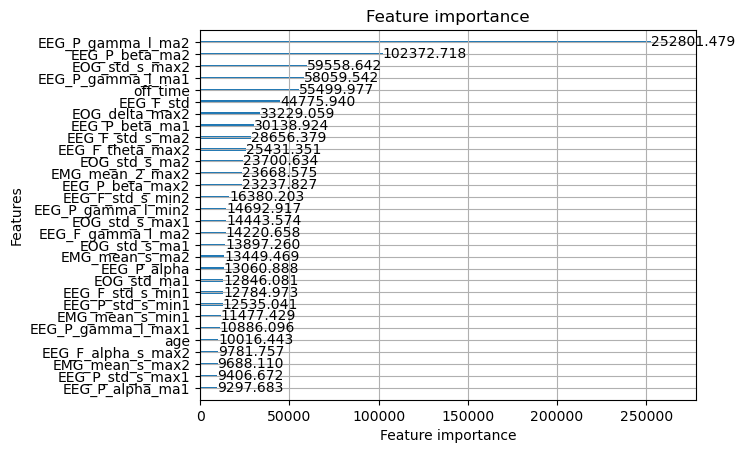

In [358]:
lgbm_0 = lgbm_o(train_0, valid_0, "0")


[I 2023-01-17 21:24:40,790] A new study created in memory with name: no-name-fe4377d7-0394-4c66-ba03-36d427a97b09
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.343593:  14%|######4                                      | 1/7 [00:54<05:29, 54.90s/it]

Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.156037	valid_1's multi_logloss: 0.343593


[I 2023-01-17 21:25:36,003] Trial 0 finished with value: 0.34359255767126734 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.34359255767126734.
feature_fraction, val_score: 0.343593:  14%|######4                                      | 1/7 [00:55<05:29, 54.90s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.343593:  29%|############8                                | 2/7 [01:36<03:56, 47.32s/it]

Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.153209	valid_1's multi_logloss: 0.345441


[I 2023-01-17 21:26:18,090] Trial 1 finished with value: 0.34544141868860867 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.34359255767126734.
feature_fraction, val_score: 0.343593:  29%|############8                                | 2/7 [01:37<03:56, 47.32s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.339827:  43%|###################2                         | 3/7 [02:34<03:27, 51.93s/it]

Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.135682	valid_1's multi_logloss: 0.339827


[I 2023-01-17 21:27:15,397] Trial 2 finished with value: 0.3398271759779164 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.3398271759779164.
feature_fraction, val_score: 0.339827:  43%|###################2                         | 3/7 [02:34<03:27, 51.93s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335065:  57%|#########################7                   | 4/7 [03:54<03:09, 63.11s/it]

Early stopping, best iteration is:
[171]	valid_0's multi_logloss: 0.100826	valid_1's multi_logloss: 0.335065


[I 2023-01-17 21:28:35,738] Trial 3 finished with value: 0.3350649781302076 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.3350649781302076.
feature_fraction, val_score: 0.335065:  57%|#########################7                   | 4/7 [03:54<03:09, 63.11s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335065:  71%|################################1            | 5/7 [04:39<01:53, 56.60s/it]

Early stopping, best iteration is:
[163]	valid_0's multi_logloss: 0.110047	valid_1's multi_logloss: 0.340302


[I 2023-01-17 21:29:20,753] Trial 4 finished with value: 0.34030151957064686 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.3350649781302076.
feature_fraction, val_score: 0.335065:  71%|################################1            | 5/7 [04:39<01:53, 56.60s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335065:  86%|######################################5      | 6/7 [05:54<01:02, 62.88s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.0972435	valid_1's multi_logloss: 0.335167


[I 2023-01-17 21:30:35,789] Trial 5 finished with value: 0.33516719705139714 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.3350649781302076.
feature_fraction, val_score: 0.335065:  86%|######################################5      | 6/7 [05:54<01:02, 62.88s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.335065: 100%|#############################################| 7/7 [06:32<00:00, 54.75s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.122253	valid_1's multi_logloss: 0.337203


[I 2023-01-17 21:31:13,835] Trial 6 finished with value: 0.33720295491132657 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.3350649781302076.
num_leaves, val_score: 0.335065:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:   5%|##4                                              | 1/20 [02:11<41:34, 131.31s/it]

Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.0385366	valid_1's multi_logloss: 0.356535


[I 2023-01-17 21:33:25,435] Trial 7 finished with value: 0.3565353594851767 and parameters: {'num_leaves': 88}. Best is trial 7 with value: 0.3565353594851767.
num_leaves, val_score: 0.335065:   5%|##4                                              | 1/20 [02:11<41:34, 131.31s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.029367	valid_1's multi_logloss: 0.372453


num_leaves, val_score: 0.335065:  10%|####9                                            | 2/20 [04:59<45:51, 152.87s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  15%|#######3                                         | 3/20 [07:27<42:44, 150.88s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.0362694	valid_1's multi_logloss: 0.357555


[I 2023-01-17 21:38:41,895] Trial 9 finished with value: 0.35755516736074483 and parameters: {'num_leaves': 136}. Best is trial 7 with value: 0.3565353594851767.
num_leaves, val_score: 0.335065:  15%|#######3                                         | 3/20 [07:28<42:44, 150.88s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  20%|#########8                                       | 4/20 [09:43<38:39, 144.94s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.0479867	valid_1's multi_logloss: 0.357342


[I 2023-01-17 21:40:57,732] Trial 10 finished with value: 0.35734181186478153 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.3565353594851767.
num_leaves, val_score: 0.335065:  20%|#########8                                       | 4/20 [09:43<38:39, 144.94s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.0252934	valid_1's multi_logloss: 0.36983


num_leaves, val_score: 0.335065:  25%|############2                                    | 5/20 [12:56<40:32, 162.16s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  30%|##############7                                  | 6/20 [15:25<36:48, 157.73s/it]

Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.0311224	valid_1's multi_logloss: 0.355168


[I 2023-01-17 21:46:39,581] Trial 12 finished with value: 0.3551684463245888 and parameters: {'num_leaves': 122}. Best is trial 12 with value: 0.3551684463245888.
num_leaves, val_score: 0.335065:  30%|##############7                                  | 6/20 [15:25<36:48, 157.73s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  35%|#################1                               | 7/20 [16:40<28:19, 130.70s/it]

Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 0.139624	valid_1's multi_logloss: 0.350869


[I 2023-01-17 21:47:54,630] Trial 13 finished with value: 0.3508685584712083 and parameters: {'num_leaves': 14}. Best is trial 13 with value: 0.3508685584712083.
num_leaves, val_score: 0.335065:  35%|#################1                               | 7/20 [16:40<28:19, 130.70s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  40%|###################6                             | 8/20 [18:35<25:07, 125.60s/it]

Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.0654995	valid_1's multi_logloss: 0.345673


[I 2023-01-17 21:49:49,306] Trial 14 finished with value: 0.3456730308111847 and parameters: {'num_leaves': 67}. Best is trial 14 with value: 0.3456730308111847.
num_leaves, val_score: 0.335065:  40%|###################6                             | 8/20 [18:35<25:07, 125.60s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  45%|######################                           | 9/20 [19:34<19:13, 104.85s/it]

Early stopping, best iteration is:
[202]	valid_0's multi_logloss: 0.176528	valid_1's multi_logloss: 0.344229


[I 2023-01-17 21:50:48,526] Trial 15 finished with value: 0.34422856889245745 and parameters: {'num_leaves': 12}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  45%|######################                           | 9/20 [19:34<19:13, 104.85s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  50%|########################                        | 10/20 [21:49<19:02, 114.28s/it]

Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.0375159	valid_1's multi_logloss: 0.355024


[I 2023-01-17 21:53:03,978] Trial 16 finished with value: 0.3550241893176763 and parameters: {'num_leaves': 107}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  50%|########################                        | 10/20 [21:50<19:02, 114.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[535]	valid_0's multi_logloss: 0.254825	valid_1's multi_logloss: 0.351096


num_leaves, val_score: 0.335065:  55%|##########################4                     | 11/20 [22:58<15:01, 100.18s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  60%|#############################4                   | 12/20 [24:37<13:19, 99.92s/it]

Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.0725662	valid_1's multi_logloss: 0.344447


[I 2023-01-17 21:55:51,495] Trial 18 finished with value: 0.3444473290133335 and parameters: {'num_leaves': 55}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  60%|#############################4                   | 12/20 [24:37<13:19, 99.92s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  65%|###############################8                 | 13/20 [26:16<11:37, 99.69s/it]

Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.0753921	valid_1's multi_logloss: 0.347397


[I 2023-01-17 21:57:30,620] Trial 19 finished with value: 0.34739658729359835 and parameters: {'num_leaves': 54}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  65%|###############################8                 | 13/20 [26:16<11:37, 99.69s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  70%|##################################3              | 14/20 [27:23<08:59, 89.87s/it]

Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.141827	valid_1's multi_logloss: 0.349037


[I 2023-01-17 21:58:37,774] Trial 20 finished with value: 0.3490371371581075 and parameters: {'num_leaves': 33}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  70%|##################################3              | 14/20 [27:23<08:59, 89.87s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.0287365	valid_1's multi_logloss: 0.361825


num_leaves, val_score: 0.335065:  75%|####################################            | 15/20 [30:06<09:19, 111.86s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  80%|######################################4         | 16/20 [31:33<06:58, 104.52s/it]

Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.0879082	valid_1's multi_logloss: 0.345514


[I 2023-01-17 22:02:48,092] Trial 22 finished with value: 0.34551390808118243 and parameters: {'num_leaves': 47}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  80%|######################################4         | 16/20 [31:34<06:58, 104.52s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  85%|########################################8       | 17/20 [33:24<05:18, 106.26s/it]

Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.0576693	valid_1's multi_logloss: 0.344993


[I 2023-01-17 22:04:38,420] Trial 23 finished with value: 0.34499289454425786 and parameters: {'num_leaves': 75}. Best is trial 15 with value: 0.34422856889245745.
num_leaves, val_score: 0.335065:  85%|########################################8       | 17/20 [33:24<05:18, 106.26s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.0313275	valid_1's multi_logloss: 0.370085


num_leaves, val_score: 0.335065:  90%|###########################################2    | 18/20 [36:00<04:02, 121.30s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065:  95%|#############################################5  | 19/20 [37:01<01:43, 103.28s/it]

Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.154549	valid_1's multi_logloss: 0.34084


[I 2023-01-17 22:08:15,988] Trial 25 finished with value: 0.3408403877702245 and parameters: {'num_leaves': 29}. Best is trial 25 with value: 0.3408403877702245.
num_leaves, val_score: 0.335065:  95%|#############################################5  | 19/20 [37:02<01:43, 103.28s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.335065: 100%|#################################################| 20/20 [38:14<00:00, 94.09s/it]

Early stopping, best iteration is:
[191]	valid_0's multi_logloss: 0.11917	valid_1's multi_logloss: 0.348775


[I 2023-01-17 22:09:28,716] Trial 26 finished with value: 0.3487747528718913 and parameters: {'num_leaves': 23}. Best is trial 25 with value: 0.3408403877702245.
bagging, val_score: 0.335065:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  10%|#####3                                               | 1/10 [01:08<10:17, 68.63s/it]

Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.109809	valid_1's multi_logloss: 0.347265


[I 2023-01-17 22:10:37,653] Trial 27 finished with value: 0.34726523177625823 and parameters: {'bagging_fraction': 0.4097491520822544, 'bagging_freq': 4}. Best is trial 27 with value: 0.34726523177625823.
bagging, val_score: 0.335065:  10%|#####3                                               | 1/10 [01:08<10:17, 68.63s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  20%|##########6                                          | 2/10 [02:34<10:29, 78.69s/it]

Early stopping, best iteration is:
[194]	valid_0's multi_logloss: 0.0873983	valid_1's multi_logloss: 0.344148


[I 2023-01-17 22:12:03,384] Trial 28 finished with value: 0.3441481633479058 and parameters: {'bagging_fraction': 0.7015898577214337, 'bagging_freq': 2}. Best is trial 28 with value: 0.3441481633479058.
bagging, val_score: 0.335065:  20%|##########6                                          | 2/10 [02:34<10:29, 78.69s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  30%|###############9                                     | 3/10 [04:04<09:47, 83.99s/it]

Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.0805224	valid_1's multi_logloss: 0.339739


[I 2023-01-17 22:13:33,683] Trial 29 finished with value: 0.33973869142013174 and parameters: {'bagging_fraction': 0.7168426405670946, 'bagging_freq': 7}. Best is trial 29 with value: 0.33973869142013174.
bagging, val_score: 0.335065:  30%|###############9                                     | 3/10 [04:04<09:47, 83.99s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  40%|#####################2                               | 4/10 [05:12<07:44, 77.48s/it]

Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.124193	valid_1's multi_logloss: 0.346115


[I 2023-01-17 22:14:41,249] Trial 30 finished with value: 0.3461150554582276 and parameters: {'bagging_fraction': 0.6049500013258099, 'bagging_freq': 1}. Best is trial 29 with value: 0.33973869142013174.
bagging, val_score: 0.335065:  40%|#####################2                               | 4/10 [05:12<07:44, 77.48s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  50%|##########################5                          | 5/10 [06:34<06:36, 79.40s/it]

Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 0.0914908	valid_1's multi_logloss: 0.347179


[I 2023-01-17 22:16:03,950] Trial 31 finished with value: 0.34717924806710515 and parameters: {'bagging_fraction': 0.6961339958077817, 'bagging_freq': 7}. Best is trial 29 with value: 0.33973869142013174.
bagging, val_score: 0.335065:  50%|##########################5                          | 5/10 [06:35<06:36, 79.40s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  60%|###############################8                     | 6/10 [07:42<05:01, 75.41s/it]

Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.122944	valid_1's multi_logloss: 0.341311


[I 2023-01-17 22:17:11,688] Trial 32 finished with value: 0.34131067003327037 and parameters: {'bagging_fraction': 0.6140610075508792, 'bagging_freq': 1}. Best is trial 29 with value: 0.33973869142013174.
bagging, val_score: 0.335065:  60%|###############################8                     | 6/10 [07:42<05:01, 75.41s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.335065:  70%|#####################################                | 7/10 [09:00<03:48, 76.28s/it]

Early stopping, best iteration is:
[162]	valid_0's multi_logloss: 0.104867	valid_1's multi_logloss: 0.346758


[I 2023-01-17 22:18:29,709] Trial 33 finished with value: 0.346758267596092 and parameters: {'bagging_fraction': 0.7077758660226019, 'bagging_freq': 6}. Best is trial 29 with value: 0.33973869142013174.
bagging, val_score: 0.335065:  70%|#####################################                | 7/10 [09:00<03:48, 76.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's multi_logloss: 0.103303	valid_1's multi_logloss: 0.343905


bagging, val_score: 0.335065:  80%|##########################################4          | 8/10 [10:32<02:42, 81.07s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's multi_logloss: 0.118578	valid_1's multi_logloss: 0.348843


bagging, val_score: 0.335065:  90%|###############################################7     | 9/10 [12:41<01:36, 96.16s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0811	valid_1's multi_logloss: 0.34903


feature_fraction_stage2, val_score: 0.335065:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.13282	valid_1's multi_logloss: 0.345613


feature_fraction_stage2, val_score: 0.335065:  33%|############3                        | 1/3 [02:37<05:14, 157.08s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.335065:  67%|########################6            | 2/3 [05:03<02:30, 150.75s/it]

Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.0944117	valid_1's multi_logloss: 0.340563


[I 2023-01-17 22:30:18,199] Trial 38 finished with value: 0.340562637696964 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.340562637696964.
feature_fraction_stage2, val_score: 0.335065:  67%|########################6            | 2/3 [05:03<02:30, 150.75s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.335065: 100%|#####################################| 3/3 [06:25<00:00, 119.58s/it]

Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.131442	valid_1's multi_logloss: 0.339257


[I 2023-01-17 22:31:40,692] Trial 39 finished with value: 0.33925672785315686 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 0.33925672785315686.
regularization_factors, val_score: 0.335065:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:   5%|#9                                    | 1/20 [01:18<24:46, 78.22s/it]

Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.112978	valid_1's multi_logloss: 0.343739


[I 2023-01-17 22:32:59,202] Trial 40 finished with value: 0.34373858478806024 and parameters: {'lambda_l1': 1.325894532880789e-07, 'lambda_l2': 1.7040160526777264e-06}. Best is trial 40 with value: 0.34373858478806024.
regularization_factors, val_score: 0.335065:   5%|#9                                    | 1/20 [01:18<24:46, 78.22s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  10%|###8                                  | 2/20 [02:55<26:45, 89.21s/it]

Early stopping, best iteration is:
[199]	valid_0's multi_logloss: 0.112618	valid_1's multi_logloss: 0.335513


[I 2023-01-17 22:34:36,099] Trial 41 finished with value: 0.33551281402685235 and parameters: {'lambda_l1': 8.35065235680463, 'lambda_l2': 3.0662906601945048e-06}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  10%|###8                                  | 2/20 [02:55<26:45, 89.21s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  15%|#####7                                | 3/20 [04:14<23:57, 84.58s/it]

Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.114464	valid_1's multi_logloss: 0.344041


[I 2023-01-17 22:35:55,174] Trial 42 finished with value: 0.34404118153273294 and parameters: {'lambda_l1': 0.05130238254750368, 'lambda_l2': 5.595506146883425e-08}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  15%|#####7                                | 3/20 [04:14<23:57, 84.58s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  20%|#######6                              | 4/20 [05:40<22:43, 85.22s/it]

Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 0.097745	valid_1's multi_logloss: 0.340136


[I 2023-01-17 22:37:21,371] Trial 43 finished with value: 0.34013555298383463 and parameters: {'lambda_l1': 0.0025007278006001065, 'lambda_l2': 0.00013680147353661778}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  20%|#######6                              | 4/20 [05:40<22:43, 85.22s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  25%|#########5                            | 5/20 [07:07<21:28, 85.92s/it]

Early stopping, best iteration is:
[185]	valid_0's multi_logloss: 0.0935921	valid_1's multi_logloss: 0.33604


[I 2023-01-17 22:38:48,497] Trial 44 finished with value: 0.3360402883828706 and parameters: {'lambda_l1': 0.0059425871325393485, 'lambda_l2': 8.289621604056706e-08}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  25%|#########5                            | 5/20 [07:07<21:28, 85.92s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  30%|###########4                          | 6/20 [08:23<19:15, 82.53s/it]

Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.118191	valid_1's multi_logloss: 0.337039


[I 2023-01-17 22:40:04,551] Trial 45 finished with value: 0.3370393365987854 and parameters: {'lambda_l1': 0.00018862540424729362, 'lambda_l2': 1.5734794079116656e-05}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  30%|###########4                          | 6/20 [08:23<19:15, 82.53s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  35%|#############3                        | 7/20 [09:42<17:39, 81.53s/it]

Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.11283	valid_1's multi_logloss: 0.342098


[I 2023-01-17 22:41:23,968] Trial 46 finished with value: 0.3420981948930352 and parameters: {'lambda_l1': 0.0001747125182041745, 'lambda_l2': 0.01926252619555794}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  35%|#############3                        | 7/20 [09:43<17:39, 81.53s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  40%|###############2                      | 8/20 [11:03<16:16, 81.36s/it]

Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.110746	valid_1's multi_logloss: 0.342746


[I 2023-01-17 22:42:44,975] Trial 47 finished with value: 0.3427461068311163 and parameters: {'lambda_l1': 1.7148873619377126e-05, 'lambda_l2': 0.0525331393788617}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  40%|###############2                      | 8/20 [11:04<16:16, 81.36s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  45%|#################1                    | 9/20 [12:38<15:40, 85.52s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.0792769	valid_1's multi_logloss: 0.340023


[I 2023-01-17 22:44:19,634] Trial 48 finished with value: 0.3400228181230837 and parameters: {'lambda_l1': 0.00011041064747981192, 'lambda_l2': 0.0036141942477012664}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  45%|#################1                    | 9/20 [12:38<15:40, 85.52s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.335065:  50%|##################5                  | 10/20 [14:14<14:47, 88.74s/it]

Early stopping, best iteration is:
[197]	valid_0's multi_logloss: 0.0891178	valid_1's multi_logloss: 0.338706


[I 2023-01-17 22:45:55,624] Trial 49 finished with value: 0.3387055855960197 and parameters: {'lambda_l1': 0.28069806216997806, 'lambda_l2': 1.0584483377653227e-06}. Best is trial 41 with value: 0.33551281402685235.
regularization_factors, val_score: 0.335065:  50%|##################5                  | 10/20 [14:14<14:47, 88.74s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  55%|####################3                | 11/20 [16:08<14:28, 96.49s/it]

Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.0955751	valid_1's multi_logloss: 0.332085


[I 2023-01-17 22:47:49,630] Trial 50 finished with value: 0.3320845715323387 and parameters: {'lambda_l1': 6.686111030123485, 'lambda_l2': 5.518383217588485}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  55%|####################3                | 11/20 [16:08<14:28, 96.49s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  60%|######################2              | 12/20 [17:50<13:04, 98.10s/it]

Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.107806	valid_1's multi_logloss: 0.339071


[I 2023-01-17 22:49:31,483] Trial 51 finished with value: 0.33907057859223433 and parameters: {'lambda_l1': 2.8738944556223824, 'lambda_l2': 6.172515270026352}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  60%|######################2              | 12/20 [17:50<13:04, 98.10s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  65%|#######################4            | 13/20 [19:37<11:44, 100.67s/it]

Early stopping, best iteration is:
[228]	valid_0's multi_logloss: 0.0994983	valid_1's multi_logloss: 0.337388


[I 2023-01-17 22:51:18,004] Trial 52 finished with value: 0.33738830685236326 and parameters: {'lambda_l1': 6.523520383367062, 'lambda_l2': 2.498000193148215}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  65%|#######################4            | 13/20 [19:37<11:44, 100.67s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  65%|#######################4            | 13/20 [21:32<11:44, 100.67s/it]

Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 0.0597037	valid_1's multi_logloss: 0.340066


regularization_factors, val_score: 0.332085:  70%|#########################2          | 14/20 [21:32<10:31, 105.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  75%|###########################         | 15/20 [23:28<09:01, 108.26s/it]

Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 0.0937809	valid_1's multi_logloss: 0.335683


[I 2023-01-17 22:55:09,047] Trial 54 finished with value: 0.33568303986252535 and parameters: {'lambda_l1': 9.189996387063632, 'lambda_l2': 0.09814888119405603}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  75%|###########################         | 15/20 [23:28<09:01, 108.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  80%|############################8       | 16/20 [25:04<06:59, 104.75s/it]

Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.0835068	valid_1's multi_logloss: 0.343435


[I 2023-01-17 22:56:45,655] Trial 55 finished with value: 0.34343540222749913 and parameters: {'lambda_l1': 3.7039654704896137e-07, 'lambda_l2': 9.130841819248603e-06}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  80%|############################8       | 16/20 [25:04<06:59, 104.75s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  85%|###############################4     | 17/20 [26:28<04:55, 98.33s/it]

Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.118719	valid_1's multi_logloss: 0.341932


[I 2023-01-17 22:58:09,037] Trial 56 finished with value: 0.3419316869745242 and parameters: {'lambda_l1': 0.449882634547766, 'lambda_l2': 1.0332232863606876e-08}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  85%|###############################4     | 17/20 [26:28<04:55, 98.33s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  90%|#################################3   | 18/20 [27:49<03:06, 93.19s/it]

Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.112685	valid_1's multi_logloss: 0.343377


[I 2023-01-17 22:59:30,263] Trial 57 finished with value: 0.3433772188167065 and parameters: {'lambda_l1': 0.01425851488674436, 'lambda_l2': 0.001684510867180476}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  90%|#################################3   | 18/20 [27:49<03:06, 93.19s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085:  95%|###################################1 | 19/20 [29:01<01:26, 86.86s/it]

Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.141767	valid_1's multi_logloss: 0.342692


[I 2023-01-17 23:00:42,396] Trial 58 finished with value: 0.34269151429030836 and parameters: {'lambda_l1': 1.7783488083805388e-08, 'lambda_l2': 3.566376573716104e-05}. Best is trial 50 with value: 0.3320845715323387.
regularization_factors, val_score: 0.332085:  95%|###################################1 | 19/20 [29:01<01:26, 86.86s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.332085: 100%|#####################################| 20/20 [30:46<00:00, 92.42s/it]

Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0927431	valid_1's multi_logloss: 0.334772


[I 2023-01-17 23:02:27,752] Trial 59 finished with value: 0.33477158818646846 and parameters: {'lambda_l1': 1.23530017172234, 'lambda_l2': 1.6609189493855343}. Best is trial 50 with value: 0.3320845715323387.
min_data_in_leaf, val_score: 0.332085:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's multi_logloss: 0.0733231	valid_1's multi_logloss: 0.339854


min_data_in_leaf, val_score: 0.332085:  20%|########8                                   | 1/5 [02:24<09:38, 144.60s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.332085:  40%|#################6                          | 2/5 [04:07<06:00, 120.32s/it]

Early stopping, best iteration is:
[209]	valid_0's multi_logloss: 0.109223	valid_1's multi_logloss: 0.337076


[I 2023-01-17 23:06:35,971] Trial 61 finished with value: 0.3370764863839207 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.3370764863839207.
min_data_in_leaf, val_score: 0.332085:  40%|#################6                          | 2/5 [04:08<06:00, 120.32s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.332085:  60%|##########################4                 | 3/5 [06:01<03:54, 117.40s/it]

Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.104103	valid_1's multi_logloss: 0.334909


[I 2023-01-17 23:08:29,929] Trial 62 finished with value: 0.33490912601337935 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.33490912601337935.
min_data_in_leaf, val_score: 0.332085:  60%|##########################4                 | 3/5 [06:02<03:54, 117.40s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's multi_logloss: 0.069752	valid_1's multi_logloss: 0.33285


min_data_in_leaf, val_score: 0.332085:  80%|###################################2        | 4/5 [08:20<02:05, 125.76s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.332085: 100%|############################################| 5/5 [10:17<00:00, 122.68s/it]

Early stopping, best iteration is:
[232]	valid_0's multi_logloss: 0.101084	valid_1's multi_logloss: 0.335991


[I 2023-01-17 23:12:45,735] Trial 64 finished with value: 0.3359909179052389 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.33284993780817174.
min_data_in_leaf, val_score: 0.332085: 100%|############################################| 5/5 [10:17<00:00, 123.59s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 6.686111030123485, 'lambda_l2': 5.518383217588485, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [24, 26]}
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     13736
           1       0.62      0.42      0.50      2907
           2       0.87      0.89      0.88     11119
           3       0.85      0.76      0.80      1648
           4       0.90      0.81      0.85      3293

    accuracy                           0.87     32703
   macro avg       0.83      0.77      0.80     32703
weighted avg       0.86      0.87      0.87     32703

0.8724276060300278


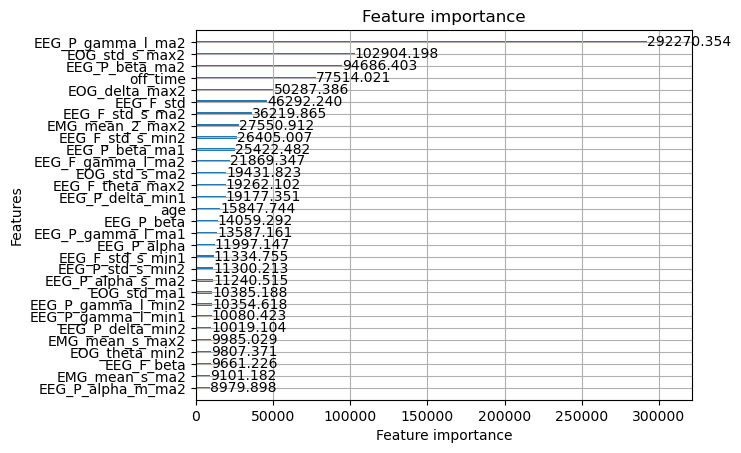

In [359]:
lgbm_1 = lgbm_o(train_1, valid_1, "1")

[I 2023-01-17 23:12:52,326] A new study created in memory with name: no-name-1519bcea-be2e-4d22-92df-469944af3704
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.352261:  14%|######4                                      | 1/7 [00:32<03:12, 32.03s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.188771	valid_1's multi_logloss: 0.352261


[I 2023-01-17 23:13:24,635] Trial 0 finished with value: 0.35226065451229605 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.35226065451229605.
feature_fraction, val_score: 0.352261:  14%|######4                                      | 1/7 [00:32<03:12, 32.03s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.352261:  29%|############8                                | 2/7 [01:31<04:00, 48.13s/it]

Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.155481	valid_1's multi_logloss: 0.359051


[I 2023-01-17 23:14:24,055] Trial 1 finished with value: 0.35905121125738215 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.35226065451229605.
feature_fraction, val_score: 0.352261:  29%|############8                                | 2/7 [01:31<04:00, 48.13s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.352261:  43%|###################2                         | 3/7 [02:34<03:39, 54.94s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.169354	valid_1's multi_logloss: 0.355751


[I 2023-01-17 23:15:27,083] Trial 2 finished with value: 0.3557510090302831 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.35226065451229605.
feature_fraction, val_score: 0.352261:  43%|###################2                         | 3/7 [02:34<03:39, 54.94s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.349840:  57%|#########################7                   | 4/7 [03:16<02:29, 49.90s/it]

Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.158385	valid_1's multi_logloss: 0.34984


[I 2023-01-17 23:16:09,303] Trial 3 finished with value: 0.349840310320964 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.349840310320964.
feature_fraction, val_score: 0.349840:  57%|#########################7                   | 4/7 [03:16<02:29, 49.90s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.346454:  71%|################################1            | 5/7 [03:56<01:32, 46.45s/it]

Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.147654	valid_1's multi_logloss: 0.346454


[I 2023-01-17 23:16:49,590] Trial 4 finished with value: 0.3464536372358969 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.3464536372358969.
feature_fraction, val_score: 0.346454:  71%|################################1            | 5/7 [03:57<01:32, 46.45s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.346454:  86%|######################################5      | 6/7 [04:52<00:49, 49.65s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.177553	valid_1's multi_logloss: 0.355493


[I 2023-01-17 23:17:45,439] Trial 5 finished with value: 0.355493469574939 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.3464536372358969.
feature_fraction, val_score: 0.346454:  86%|######################################5      | 6/7 [04:53<00:49, 49.65s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.346454: 100%|#############################################| 7/7 [05:43<00:00, 50.08s/it]

Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.152869	valid_1's multi_logloss: 0.355248


[I 2023-01-17 23:18:36,421] Trial 6 finished with value: 0.35524771176390163 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.3464536372358969.
num_leaves, val_score: 0.346454:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.0742205	valid_1's multi_logloss: 0.374658


num_leaves, val_score: 0.346454:   5%|##5                                               | 1/20 [01:31<28:58, 91.50s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  10%|#####                                             | 2/20 [02:36<22:50, 76.15s/it]

Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.091278	valid_1's multi_logloss: 0.365087


[I 2023-01-17 23:21:13,637] Trial 8 finished with value: 0.3650868476344224 and parameters: {'num_leaves': 127}. Best is trial 8 with value: 0.3650868476344224.
num_leaves, val_score: 0.346454:  10%|#####                                             | 2/20 [02:37<22:50, 76.15s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  15%|#######5                                          | 3/20 [03:35<19:14, 67.94s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.11904	valid_1's multi_logloss: 0.35908


[I 2023-01-17 23:22:11,837] Trial 9 finished with value: 0.359080315393964 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 0.359080315393964.
num_leaves, val_score: 0.346454:  15%|#######5                                          | 3/20 [03:35<19:14, 67.94s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  20%|##########                                        | 4/20 [04:20<15:44, 59.04s/it]

Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.146442	valid_1's multi_logloss: 0.349482


[I 2023-01-17 23:22:57,202] Trial 10 finished with value: 0.3494823157413403 and parameters: {'num_leaves': 36}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  20%|##########                                        | 4/20 [04:20<15:44, 59.04s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  25%|############5                                     | 5/20 [04:57<12:48, 51.22s/it]

Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.164177	valid_1's multi_logloss: 0.352322


[I 2023-01-17 23:23:34,523] Trial 11 finished with value: 0.3523220555655102 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  25%|############5                                     | 5/20 [04:58<12:48, 51.22s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  30%|###############                                   | 6/20 [06:00<12:53, 55.22s/it]

Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.0894213	valid_1's multi_logloss: 0.360573


[I 2023-01-17 23:24:37,497] Trial 12 finished with value: 0.3605726193609029 and parameters: {'num_leaves': 130}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  30%|###############                                   | 6/20 [06:01<12:53, 55.22s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  35%|#################5                                | 7/20 [06:38<10:42, 49.46s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.163821	valid_1's multi_logloss: 0.350216


[I 2023-01-17 23:25:15,165] Trial 13 finished with value: 0.35021642599366926 and parameters: {'num_leaves': 35}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  35%|#################5                                | 7/20 [06:38<10:42, 49.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.0872778	valid_1's multi_logloss: 0.367208


num_leaves, val_score: 0.346454:  40%|####################                              | 8/20 [07:49<11:16, 56.37s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  40%|####################                              | 8/20 [09:06<11:16, 56.37s/it]

Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.0691025	valid_1's multi_logloss: 0.364916


num_leaves, val_score: 0.346454:  45%|######################5                           | 9/20 [09:06<11:29, 62.65s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  45%|######################5                           | 9/20 [10:29<11:29, 62.65s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0773492	valid_1's multi_logloss: 0.372157


num_leaves, val_score: 0.346454:  50%|########################5                        | 10/20 [10:29<11:30, 69.04s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  55%|##########################9                      | 11/20 [11:15<09:19, 62.15s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.131781	valid_1's multi_logloss: 0.356505


[I 2023-01-17 23:29:52,640] Trial 17 finished with value: 0.356504977716841 and parameters: {'num_leaves': 74}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  55%|##########################9                      | 11/20 [11:16<09:19, 62.15s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  60%|#############################4                   | 12/20 [11:43<06:52, 51.59s/it]

Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 0.256841	valid_1's multi_logloss: 0.35876


[I 2023-01-17 23:30:20,036] Trial 18 finished with value: 0.3587595007529167 and parameters: {'num_leaves': 7}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  60%|#############################4                   | 12/20 [11:43<06:52, 51.59s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  65%|###############################8                 | 13/20 [12:25<05:41, 48.80s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.136763	valid_1's multi_logloss: 0.35687


[I 2023-01-17 23:31:02,439] Trial 19 finished with value: 0.3568696001644613 and parameters: {'num_leaves': 55}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  65%|###############################8                 | 13/20 [12:26<05:41, 48.80s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  70%|##################################3              | 14/20 [13:12<04:49, 48.17s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.160712	valid_1's multi_logloss: 0.35482


[I 2023-01-17 23:31:49,140] Trial 20 finished with value: 0.3548204735628366 and parameters: {'num_leaves': 60}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  70%|##################################3              | 14/20 [13:12<04:49, 48.17s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[808]	valid_0's multi_logloss: 0.227259	valid_1's multi_logloss: 0.363223


num_leaves, val_score: 0.346454:  75%|####################################7            | 15/20 [14:08<04:12, 50.57s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  80%|#######################################2         | 16/20 [15:02<03:26, 51.65s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.107743	valid_1's multi_logloss: 0.360311


[I 2023-01-17 23:33:39,449] Trial 22 finished with value: 0.36031074753462233 and parameters: {'num_leaves': 96}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  80%|#######################################2         | 16/20 [15:03<03:26, 51.65s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  85%|#########################################6       | 17/20 [15:42<02:24, 48.23s/it]

Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.150997	valid_1's multi_logloss: 0.353146


[I 2023-01-17 23:34:19,721] Trial 23 finished with value: 0.35314551919863735 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  85%|#########################################6       | 17/20 [15:43<02:24, 48.23s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  90%|############################################1    | 18/20 [16:24<01:32, 46.23s/it]

Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 0.143703	valid_1's multi_logloss: 0.350419


[I 2023-01-17 23:35:01,304] Trial 24 finished with value: 0.35041895182333455 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  90%|############################################1    | 18/20 [16:24<01:32, 46.23s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454:  95%|##############################################5  | 19/20 [17:15<00:47, 47.65s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.132921	valid_1's multi_logloss: 0.359886


[I 2023-01-17 23:35:52,258] Trial 25 finished with value: 0.35988623489391963 and parameters: {'num_leaves': 82}. Best is trial 10 with value: 0.3494823157413403.
num_leaves, val_score: 0.346454:  95%|##############################################5  | 19/20 [17:15<00:47, 47.65s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.346454: 100%|#################################################| 20/20 [18:22<00:00, 53.52s/it]

Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.0981258	valid_1's multi_logloss: 0.362813


[I 2023-01-17 23:36:59,421] Trial 26 finished with value: 0.3628127307850837 and parameters: {'num_leaves': 151}. Best is trial 10 with value: 0.3494823157413403.
bagging, val_score: 0.346454:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  10%|#####3                                               | 1/10 [00:41<06:14, 41.63s/it]

Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.156502	valid_1's multi_logloss: 0.349121


[I 2023-01-17 23:37:41,365] Trial 27 finished with value: 0.3491213709467055 and parameters: {'bagging_fraction': 0.9016838795147464, 'bagging_freq': 5}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  10%|#####3                                               | 1/10 [00:41<06:14, 41.63s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  20%|##########6                                          | 2/10 [01:15<04:57, 37.19s/it]

Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.159182	valid_1's multi_logloss: 0.353536


[I 2023-01-17 23:38:15,439] Trial 28 finished with value: 0.35353557494822285 and parameters: {'bagging_fraction': 0.45642964738800945, 'bagging_freq': 1}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  20%|##########6                                          | 2/10 [01:16<04:57, 37.19s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  30%|###############9                                     | 3/10 [01:52<04:19, 37.04s/it]

Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.149603	valid_1's multi_logloss: 0.353149


[I 2023-01-17 23:38:52,304] Trial 29 finished with value: 0.35314862232751265 and parameters: {'bagging_fraction': 0.5296928047902072, 'bagging_freq': 1}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  30%|###############9                                     | 3/10 [01:52<04:19, 37.04s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  40%|#####################2                               | 4/10 [02:30<03:43, 37.32s/it]

Early stopping, best iteration is:
[113]	valid_0's multi_logloss: 0.140926	valid_1's multi_logloss: 0.351107


[I 2023-01-17 23:39:30,033] Trial 30 finished with value: 0.3511067405532523 and parameters: {'bagging_fraction': 0.5814619010003922, 'bagging_freq': 2}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  40%|#####################2                               | 4/10 [02:30<03:43, 37.32s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  50%|##########################5                          | 5/10 [03:06<03:05, 37.08s/it]

Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.168405	valid_1's multi_logloss: 0.352801


[I 2023-01-17 23:40:06,720] Trial 31 finished with value: 0.35280121772592604 and parameters: {'bagging_fraction': 0.6473288594374869, 'bagging_freq': 2}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  50%|##########################5                          | 5/10 [03:07<03:05, 37.08s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  60%|###############################8                     | 6/10 [03:45<02:30, 37.65s/it]

Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.151501	valid_1's multi_logloss: 0.352213


[I 2023-01-17 23:40:45,447] Trial 32 finished with value: 0.35221252314870843 and parameters: {'bagging_fraction': 0.7276395906834534, 'bagging_freq': 2}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  60%|###############################8                     | 6/10 [03:46<02:30, 37.65s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  70%|#####################################                | 7/10 [04:17<01:47, 35.71s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.183294	valid_1's multi_logloss: 0.355121


[I 2023-01-17 23:41:17,164] Trial 33 finished with value: 0.3551211766501453 and parameters: {'bagging_fraction': 0.47690474689600537, 'bagging_freq': 6}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  70%|#####################################                | 7/10 [04:17<01:47, 35.71s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  80%|##########################################4          | 8/10 [04:49<01:09, 34.52s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.178409	valid_1's multi_logloss: 0.354516


[I 2023-01-17 23:41:49,203] Trial 34 finished with value: 0.35451574363304417 and parameters: {'bagging_fraction': 0.43280205909685754, 'bagging_freq': 4}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  80%|##########################################4          | 8/10 [04:49<01:09, 34.52s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454:  90%|###############################################7     | 9/10 [05:20<00:33, 33.58s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.196673	valid_1's multi_logloss: 0.355999


[I 2023-01-17 23:42:20,672] Trial 35 finished with value: 0.3559988715828491 and parameters: {'bagging_fraction': 0.6182914077905022, 'bagging_freq': 6}. Best is trial 27 with value: 0.3491213709467055.
bagging, val_score: 0.346454:  90%|###############################################7     | 9/10 [05:21<00:33, 33.58s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.346454: 100%|####################################################| 10/10 [05:50<00:00, 32.41s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.215092	valid_1's multi_logloss: 0.360875


[I 2023-01-17 23:42:50,444] Trial 36 finished with value: 0.36087458320374977 and parameters: {'bagging_fraction': 0.4213241762360495, 'bagging_freq': 6}. Best is trial 27 with value: 0.3491213709467055.
feature_fraction_stage2, val_score: 0.346454:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346454:  17%|######3                               | 1/6 [00:37<03:09, 37.84s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.166855	valid_1's multi_logloss: 0.348803


[I 2023-01-17 23:43:28,588] Trial 37 finished with value: 0.3488032720967144 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.3488032720967144.
feature_fraction_stage2, val_score: 0.346454:  17%|######3                               | 1/6 [00:38<03:09, 37.84s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346454:  33%|############6                         | 2/6 [01:19<02:40, 40.14s/it]

Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.158328	valid_1's multi_logloss: 0.349023


[I 2023-01-17 23:44:10,427] Trial 38 finished with value: 0.34902256294835693 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.3488032720967144.
feature_fraction_stage2, val_score: 0.346454:  33%|############6                         | 2/6 [01:19<02:40, 40.14s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346454:  50%|###################                   | 3/6 [02:00<02:01, 40.58s/it]

Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.16196	valid_1's multi_logloss: 0.351719


[I 2023-01-17 23:44:51,410] Trial 39 finished with value: 0.35171912693465984 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.3488032720967144.
feature_fraction_stage2, val_score: 0.346454:  50%|###################                   | 3/6 [02:00<02:01, 40.58s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346454:  67%|#########################3            | 4/6 [02:38<01:19, 39.61s/it]

Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.157369	valid_1's multi_logloss: 0.353938


[I 2023-01-17 23:45:29,616] Trial 40 finished with value: 0.3539380666667721 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.3488032720967144.
feature_fraction_stage2, val_score: 0.346454:  67%|#########################3            | 4/6 [02:39<01:19, 39.61s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346454:  83%|###############################6      | 5/6 [03:10<00:36, 36.77s/it]

Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.164093	valid_1's multi_logloss: 0.348249


[I 2023-01-17 23:46:01,302] Trial 41 finished with value: 0.348249055146588 and parameters: {'feature_fraction': 0.42}. Best is trial 41 with value: 0.348249055146588.
feature_fraction_stage2, val_score: 0.346454:  83%|###############################6      | 5/6 [03:10<00:36, 36.77s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.346037: 100%|######################################| 6/6 [03:47<00:00, 36.68s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346037


[I 2023-01-17 23:46:37,802] Trial 42 finished with value: 0.3460374906852906 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 42 with value: 0.3460374906852906.
regularization_factors, val_score: 0.346037:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:   5%|#9                                    | 1/20 [00:38<12:13, 38.62s/it]

Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.149923	valid_1's multi_logloss: 0.349824


[I 2023-01-17 23:47:16,700] Trial 43 finished with value: 0.3498235462259956 and parameters: {'lambda_l1': 1.659574129508642e-06, 'lambda_l2': 0.3147273368238439}. Best is trial 43 with value: 0.3498235462259956.
regularization_factors, val_score: 0.346037:   5%|#9                                    | 1/20 [00:38<12:13, 38.62s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  10%|###8                                  | 2/20 [01:21<12:19, 41.09s/it]

Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.148922	valid_1's multi_logloss: 0.346793


[I 2023-01-17 23:47:59,554] Trial 44 finished with value: 0.3467927569632592 and parameters: {'lambda_l1': 0.0001440724981633758, 'lambda_l2': 0.0011533824168181409}. Best is trial 44 with value: 0.3467927569632592.
regularization_factors, val_score: 0.346037:  10%|###8                                  | 2/20 [01:21<12:19, 41.09s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  15%|#####7                                | 3/20 [02:05<11:59, 42.30s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346069


[I 2023-01-17 23:48:43,280] Trial 45 finished with value: 0.3460685279974756 and parameters: {'lambda_l1': 2.8880687025481767e-08, 'lambda_l2': 6.87773197017863e-07}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  15%|#####7                                | 3/20 [02:05<11:59, 42.30s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  20%|#######6                              | 4/20 [02:52<11:47, 44.20s/it]

Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.152401	valid_1's multi_logloss: 0.353424


[I 2023-01-17 23:49:30,437] Trial 46 finished with value: 0.353424120514341 and parameters: {'lambda_l1': 8.888687030754776e-08, 'lambda_l2': 9.259421358140019}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  20%|#######6                              | 4/20 [02:52<11:47, 44.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  25%|#########5                            | 5/20 [03:33<10:46, 43.11s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346071


[I 2023-01-17 23:50:11,567] Trial 47 finished with value: 0.3460706113879162 and parameters: {'lambda_l1': 8.884345378396396e-07, 'lambda_l2': 7.948853880234128e-07}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  25%|#########5                            | 5/20 [03:33<10:46, 43.11s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  30%|###########4                          | 6/20 [04:13<09:50, 42.17s/it]

Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.161711	valid_1's multi_logloss: 0.346683


[I 2023-01-17 23:50:51,925] Trial 48 finished with value: 0.3466832987803468 and parameters: {'lambda_l1': 0.010091205610484452, 'lambda_l2': 8.756678705616613e-05}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  30%|###########4                          | 6/20 [04:14<09:50, 42.17s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  35%|#############3                        | 7/20 [04:56<09:11, 42.42s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.166247	valid_1's multi_logloss: 0.34956


[I 2023-01-17 23:51:34,867] Trial 49 finished with value: 0.34955993746309666 and parameters: {'lambda_l1': 0.007824670863918592, 'lambda_l2': 3.371274853204863e-08}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  35%|#############3                        | 7/20 [04:57<09:11, 42.42s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  40%|###############2                      | 8/20 [05:40<08:34, 42.89s/it]

Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.161622	valid_1's multi_logloss: 0.351758


[I 2023-01-17 23:52:18,777] Trial 50 finished with value: 0.3517577235867818 and parameters: {'lambda_l1': 7.375437640547147e-08, 'lambda_l2': 2.14720372334285}. Best is trial 45 with value: 0.3460685279974756.
regularization_factors, val_score: 0.346037:  40%|###############2                      | 8/20 [05:40<08:34, 42.89s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  45%|#################1                    | 9/20 [06:24<07:55, 43.21s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346041


[I 2023-01-17 23:53:02,639] Trial 51 finished with value: 0.3460412994876974 and parameters: {'lambda_l1': 6.793415389354278e-07, 'lambda_l2': 3.839931125362503e-06}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  45%|#################1                    | 9/20 [06:24<07:55, 43.21s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  50%|##################5                  | 10/20 [07:08<07:15, 43.58s/it]

Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.162401	valid_1's multi_logloss: 0.350553


[I 2023-01-17 23:53:47,037] Trial 52 finished with value: 0.3505529956782901 and parameters: {'lambda_l1': 4.92543169010556, 'lambda_l2': 0.6943097893964345}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  50%|##################5                  | 10/20 [07:09<07:15, 43.58s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  55%|####################3                | 11/20 [07:49<06:25, 42.79s/it]

Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.154526	valid_1's multi_logloss: 0.347777


[I 2023-01-17 23:54:28,121] Trial 53 finished with value: 0.34777698508708016 and parameters: {'lambda_l1': 5.5599793676066154e-05, 'lambda_l2': 0.001059842469835828}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  55%|####################3                | 11/20 [07:50<06:25, 42.79s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  60%|######################2              | 12/20 [08:31<05:39, 42.41s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346111


[I 2023-01-17 23:55:09,691] Trial 54 finished with value: 0.34611109980014254 and parameters: {'lambda_l1': 1.1724725989007042e-08, 'lambda_l2': 3.536803743225667e-06}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  60%|######################2              | 12/20 [08:31<05:39, 42.41s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  65%|########################             | 13/20 [09:10<04:50, 41.47s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346077


[I 2023-01-17 23:55:48,913] Trial 55 finished with value: 0.34607730892490435 and parameters: {'lambda_l1': 4.375839734773234e-06, 'lambda_l2': 2.580709419025494e-08}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  65%|########################             | 13/20 [09:11<04:50, 41.47s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  70%|#########################9           | 14/20 [09:48<04:01, 40.27s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346117


[I 2023-01-17 23:56:26,396] Trial 56 finished with value: 0.34611652461456555 and parameters: {'lambda_l1': 1.0650212518314741e-08, 'lambda_l2': 6.004701548760429e-06}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  70%|#########################9           | 14/20 [09:48<04:01, 40.27s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  75%|###########################7         | 15/20 [10:25<03:16, 39.36s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346073


[I 2023-01-17 23:57:03,695] Trial 57 finished with value: 0.3460727596198094 and parameters: {'lambda_l1': 8.148010258888923e-06, 'lambda_l2': 1.9080103849189286e-07}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  75%|###########################7         | 15/20 [10:25<03:16, 39.36s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  80%|#############################6       | 16/20 [10:59<02:31, 37.79s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.173308	valid_1's multi_logloss: 0.346506


[I 2023-01-17 23:57:37,788] Trial 58 finished with value: 0.34650646260219264 and parameters: {'lambda_l1': 0.0032270559140345958, 'lambda_l2': 4.870713862919951e-05}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  80%|#############################6       | 16/20 [10:59<02:31, 37.79s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  85%|###############################4     | 17/20 [11:37<01:53, 37.71s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.143097	valid_1's multi_logloss: 0.351207


[I 2023-01-17 23:58:15,383] Trial 59 finished with value: 0.3512074683109796 and parameters: {'lambda_l1': 2.4557876513766967e-07, 'lambda_l2': 0.018122996394178845}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  85%|###############################4     | 17/20 [11:37<01:53, 37.71s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  90%|#################################3   | 18/20 [12:11<01:13, 36.83s/it]

Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.17838	valid_1's multi_logloss: 0.347153


[I 2023-01-17 23:58:50,118] Trial 60 finished with value: 0.3471526411748568 and parameters: {'lambda_l1': 0.43182212536185194, 'lambda_l2': 1.4455031246973853e-05}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  90%|#################################3   | 18/20 [12:12<01:13, 36.83s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037:  95%|###################################1 | 19/20 [12:50<00:37, 37.31s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.142909	valid_1's multi_logloss: 0.346084


[I 2023-01-17 23:59:28,514] Trial 61 finished with value: 0.3460842827528973 and parameters: {'lambda_l1': 1.7294810634603257e-05, 'lambda_l2': 4.243185712682996e-07}. Best is trial 51 with value: 0.3460412994876974.
regularization_factors, val_score: 0.346037:  95%|###################################1 | 19/20 [12:50<00:37, 37.31s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.346037: 100%|#####################################| 20/20 [13:28<00:00, 37.43s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.143194	valid_1's multi_logloss: 0.351095


[I 2023-01-18 00:00:06,233] Trial 62 finished with value: 0.35109468677877775 and parameters: {'lambda_l1': 0.0005016625901488579, 'lambda_l2': 0.011807850910413666}. Best is trial 51 with value: 0.3460412994876974.
min_data_in_leaf, val_score: 0.346037:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.346037:  20%|#########                                    | 1/5 [00:36<02:26, 36.58s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.144513	valid_1's multi_logloss: 0.353232


[I 2023-01-18 00:00:43,133] Trial 63 finished with value: 0.3532322392107706 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.3532322392107706.
min_data_in_leaf, val_score: 0.346037:  20%|#########                                    | 1/5 [00:36<02:26, 36.58s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.346037:  40%|##################                           | 2/5 [01:10<01:45, 35.20s/it]

Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.153708	valid_1's multi_logloss: 0.354313


[I 2023-01-18 00:01:17,342] Trial 64 finished with value: 0.35431254307583665 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3532322392107706.
min_data_in_leaf, val_score: 0.346037:  40%|##################                           | 2/5 [01:11<01:45, 35.20s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.346037:  60%|###########################                  | 3/5 [01:43<01:08, 34.08s/it]

Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.162149	valid_1's multi_logloss: 0.346156


[I 2023-01-18 00:01:50,089] Trial 65 finished with value: 0.3461557641002359 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.3461557641002359.
min_data_in_leaf, val_score: 0.346037:  60%|###########################                  | 3/5 [01:43<01:08, 34.08s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.346037:  80%|####################################         | 4/5 [02:16<00:33, 33.81s/it]

Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.160486	valid_1's multi_logloss: 0.353183


[I 2023-01-18 00:02:23,482] Trial 66 finished with value: 0.35318312763675724 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.3461557641002359.
min_data_in_leaf, val_score: 0.346037:  80%|####################################         | 4/5 [02:17<00:33, 33.81s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.346037: 100%|#############################################| 5/5 [02:51<00:00, 34.04s/it]

Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.152648	valid_1's multi_logloss: 0.348272


[I 2023-01-18 00:02:57,950] Trial 67 finished with value: 0.3482718879145005 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.3461557641002359.
min_data_in_leaf, val_score: 0.346037: 100%|#############################################| 5/5 [02:51<00:00, 34.34s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.45199999999999996, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [24, 26]}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     15322
           1       0.54      0.43      0.48      2925
           2       0.82      0.90      0.86      9037
           3       0.88      0.75      0.81      1855
           4       0.85      0.77      0.81      3564

    accuracy                           0.87     32703
   macro avg       0.81      0.76      0.78     32703
weighted avg       0.86      0.87      0.86     32703

0.8668317891324955


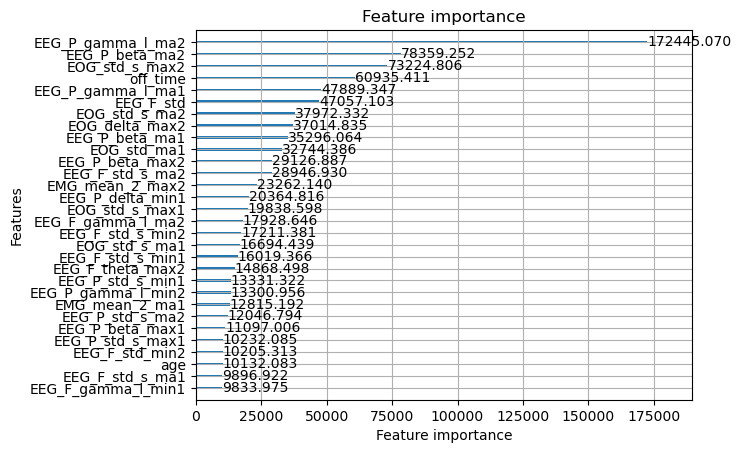

In [360]:
lgbm_2 = lgbm_o(train_2, valid_2, "2")

[I 2023-01-18 00:03:03,796] A new study created in memory with name: no-name-b14fc093-0298-4bf8-8ae2-049d559401ec
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.396284:  14%|######4                                      | 1/7 [00:49<04:56, 49.41s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.198101	valid_1's multi_logloss: 0.396284


[I 2023-01-18 00:03:53,495] Trial 0 finished with value: 0.3962836746618561 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.3962836746618561.
feature_fraction, val_score: 0.396284:  14%|######4                                      | 1/7 [00:49<04:56, 49.41s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.395960:  29%|############8                                | 2/7 [01:17<03:03, 36.77s/it]

Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.204546	valid_1's multi_logloss: 0.39596


[I 2023-01-18 00:04:21,449] Trial 1 finished with value: 0.3959598202757039 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.3959598202757039.
feature_fraction, val_score: 0.395960:  29%|############8                                | 2/7 [01:17<03:03, 36.77s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391669:  43%|###################2                         | 3/7 [01:58<02:35, 38.78s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391669


[I 2023-01-18 00:05:02,656] Trial 2 finished with value: 0.3916690108137636 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.3916690108137636.
feature_fraction, val_score: 0.391669:  43%|###################2                         | 3/7 [01:58<02:35, 38.78s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391669:  57%|#########################7                   | 4/7 [02:41<02:01, 40.40s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.217182	valid_1's multi_logloss: 0.398707


[I 2023-01-18 00:05:45,477] Trial 3 finished with value: 0.39870656701422036 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.3916690108137636.
feature_fraction, val_score: 0.391669:  57%|#########################7                   | 4/7 [02:41<02:01, 40.40s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391669:  71%|################################1            | 5/7 [03:13<01:14, 37.25s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.20662	valid_1's multi_logloss: 0.402924


[I 2023-01-18 00:06:17,212] Trial 4 finished with value: 0.40292437389001773 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.3916690108137636.
feature_fraction, val_score: 0.391669:  71%|################################1            | 5/7 [03:13<01:14, 37.25s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391669:  86%|######################################5      | 6/7 [04:06<00:42, 42.71s/it]

Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.192239	valid_1's multi_logloss: 0.400188


[I 2023-01-18 00:07:10,452] Trial 5 finished with value: 0.4001880461093292 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.3916690108137636.
feature_fraction, val_score: 0.391669:  86%|######################################5      | 6/7 [04:06<00:42, 42.71s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.391669: 100%|#############################################| 7/7 [04:41<00:00, 40.09s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.219129	valid_1's multi_logloss: 0.392687


[I 2023-01-18 00:07:45,152] Trial 6 finished with value: 0.3926871332082551 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.3916690108137636.
num_leaves, val_score: 0.391669:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:   5%|##5                                               | 1/20 [01:21<25:52, 81.73s/it]

Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.0980576	valid_1's multi_logloss: 0.400155


[I 2023-01-18 00:09:07,191] Trial 7 finished with value: 0.4001549797806886 and parameters: {'num_leaves': 142}. Best is trial 7 with value: 0.4001549797806886.
num_leaves, val_score: 0.391669:   5%|##5                                               | 1/20 [01:22<25:52, 81.73s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  10%|#####                                             | 2/20 [02:13<19:11, 63.99s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.153572	valid_1's multi_logloss: 0.396764


[I 2023-01-18 00:09:58,756] Trial 8 finished with value: 0.3967636915628617 and parameters: {'num_leaves': 57}. Best is trial 8 with value: 0.3967636915628617.
num_leaves, val_score: 0.391669:  10%|#####                                             | 2/20 [02:13<19:11, 63.99s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  15%|#######5                                          | 3/20 [03:30<19:46, 69.81s/it]

Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.107455	valid_1's multi_logloss: 0.397694


[I 2023-01-18 00:11:15,479] Trial 9 finished with value: 0.39769430012220536 and parameters: {'num_leaves': 128}. Best is trial 8 with value: 0.3967636915628617.
num_leaves, val_score: 0.391669:  15%|#######5                                          | 3/20 [03:30<19:46, 69.81s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  15%|#######5                                          | 3/20 [05:16<19:46, 69.81s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.0760574	valid_1's multi_logloss: 0.41037


num_leaves, val_score: 0.391669:  20%|##########                                        | 4/20 [05:16<22:27, 84.24s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  25%|############5                                     | 5/20 [06:01<17:31, 70.09s/it]

Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.189261	valid_1's multi_logloss: 0.393263


[I 2023-01-18 00:13:46,889] Trial 11 finished with value: 0.39326330761814116 and parameters: {'num_leaves': 43}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  25%|############5                                     | 5/20 [06:01<17:31, 70.09s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  30%|###############                                   | 6/20 [07:20<17:02, 73.05s/it]

Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.103301	valid_1's multi_logloss: 0.400665


[I 2023-01-18 00:15:05,634] Trial 12 finished with value: 0.40066524546331495 and parameters: {'num_leaves': 134}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  30%|###############                                   | 6/20 [07:20<17:02, 73.05s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0699134	valid_1's multi_logloss: 0.414424


num_leaves, val_score: 0.391669:  35%|#################5                                | 7/20 [09:11<18:29, 85.33s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.0740037	valid_1's multi_logloss: 0.412017


num_leaves, val_score: 0.391669:  40%|####################                              | 8/20 [10:53<18:09, 90.79s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  45%|######################5                           | 9/20 [12:19<16:23, 89.45s/it]

Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.109894	valid_1's multi_logloss: 0.40781


[I 2023-01-18 00:20:05,247] Trial 15 finished with value: 0.40781030409437213 and parameters: {'num_leaves': 169}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  45%|######################5                           | 9/20 [12:20<16:23, 89.45s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  45%|######################5                           | 9/20 [13:48<16:23, 89.45s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0970366	valid_1's multi_logloss: 0.40989


num_leaves, val_score: 0.391669:  50%|########################5                        | 10/20 [13:49<14:53, 89.35s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  55%|##########################9                      | 11/20 [14:20<10:44, 71.64s/it]

Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.254389	valid_1's multi_logloss: 0.398845


[I 2023-01-18 00:22:05,865] Trial 17 finished with value: 0.39884479226312197 and parameters: {'num_leaves': 13}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  55%|##########################9                      | 11/20 [14:20<10:44, 71.64s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  60%|#############################4                   | 12/20 [15:05<08:28, 63.53s/it]

Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.180216	valid_1's multi_logloss: 0.393611


[I 2023-01-18 00:22:50,837] Trial 18 finished with value: 0.3936109415012917 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  60%|#############################4                   | 12/20 [15:05<08:28, 63.53s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  65%|###############################8                 | 13/20 [16:02<07:10, 61.45s/it]

Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.143336	valid_1's multi_logloss: 0.394328


[I 2023-01-18 00:23:47,532] Trial 19 finished with value: 0.39432819426264437 and parameters: {'num_leaves': 70}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  65%|###############################8                 | 13/20 [16:02<07:10, 61.45s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  70%|##################################3              | 14/20 [16:32<05:13, 52.17s/it]

Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.26443	valid_1's multi_logloss: 0.39598


[I 2023-01-18 00:24:18,244] Trial 20 finished with value: 0.39598030531427936 and parameters: {'num_leaves': 8}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  70%|##################################3              | 14/20 [16:33<05:13, 52.17s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  75%|####################################7            | 15/20 [17:29<04:27, 53.48s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.147029	valid_1's multi_logloss: 0.397496


[I 2023-01-18 00:25:14,842] Trial 21 finished with value: 0.39749636189213544 and parameters: {'num_leaves': 65}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  75%|####################################7            | 15/20 [17:29<04:27, 53.48s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.118893	valid_1's multi_logloss: 0.399942


num_leaves, val_score: 0.391669:  80%|#######################################2         | 16/20 [19:21<04:44, 71.16s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  85%|#########################################6       | 17/20 [20:46<03:45, 75.28s/it]

Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.164709	valid_1's multi_logloss: 0.396243


[I 2023-01-18 00:28:31,993] Trial 23 finished with value: 0.39624337376527663 and parameters: {'num_leaves': 45}. Best is trial 11 with value: 0.39326330761814116.
num_leaves, val_score: 0.391669:  85%|#########################################6       | 17/20 [20:46<03:45, 75.28s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.134174	valid_1's multi_logloss: 0.394206


num_leaves, val_score: 0.391669:  90%|############################################1    | 18/20 [22:47<02:57, 88.77s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669:  95%|##############################################5  | 19/20 [24:21<01:30, 90.67s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391669


[I 2023-01-18 00:32:07,244] Trial 25 finished with value: 0.3916690108137636 and parameters: {'num_leaves': 31}. Best is trial 25 with value: 0.3916690108137636.
num_leaves, val_score: 0.391669:  95%|##############################################5  | 19/20 [24:22<01:30, 90.67s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.391669: 100%|#################################################| 20/20 [25:39<00:00, 86.88s/it]

Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.20925	valid_1's multi_logloss: 0.396891


[I 2023-01-18 00:33:25,308] Trial 26 finished with value: 0.3968913709236233 and parameters: {'num_leaves': 25}. Best is trial 25 with value: 0.3916690108137636.
bagging, val_score: 0.391669:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  10%|#####3                                               | 1/10 [01:08<10:12, 68.04s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.206032	valid_1's multi_logloss: 0.395778


[I 2023-01-18 00:34:33,820] Trial 27 finished with value: 0.39577817707945684 and parameters: {'bagging_fraction': 0.7307259128433977, 'bagging_freq': 7}. Best is trial 27 with value: 0.39577817707945684.
bagging, val_score: 0.391669:  10%|#####3                                               | 1/10 [01:08<10:12, 68.04s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  20%|##########6                                          | 2/10 [02:18<09:14, 69.32s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.172576	valid_1's multi_logloss: 0.394796


[I 2023-01-18 00:35:44,013] Trial 28 finished with value: 0.39479568780163693 and parameters: {'bagging_fraction': 0.6082894022466717, 'bagging_freq': 1}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  20%|##########6                                          | 2/10 [02:18<09:14, 69.32s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  30%|###############9                                     | 3/10 [03:27<08:03, 69.12s/it]

Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.1946	valid_1's multi_logloss: 0.398255


[I 2023-01-18 00:36:52,872] Trial 29 finished with value: 0.39825539625029793 and parameters: {'bagging_fraction': 0.7041490217536103, 'bagging_freq': 4}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  30%|###############9                                     | 3/10 [03:27<08:03, 69.12s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  40%|#####################2                               | 4/10 [04:30<06:40, 66.71s/it]

Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.228339	valid_1's multi_logloss: 0.397058


[I 2023-01-18 00:37:55,943] Trial 30 finished with value: 0.3970575877253681 and parameters: {'bagging_fraction': 0.7329878516284083, 'bagging_freq': 3}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  40%|#####################2                               | 4/10 [04:30<06:40, 66.71s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  50%|##########################5                          | 5/10 [05:35<05:31, 66.20s/it]

Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.170273	valid_1's multi_logloss: 0.401299


[I 2023-01-18 00:39:01,214] Trial 31 finished with value: 0.4012994129478971 and parameters: {'bagging_fraction': 0.4045208808405492, 'bagging_freq': 3}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  50%|##########################5                          | 5/10 [05:35<05:31, 66.20s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  60%|###############################8                     | 6/10 [06:46<04:31, 67.81s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.205008	valid_1's multi_logloss: 0.397272


[I 2023-01-18 00:40:12,262] Trial 32 finished with value: 0.397271967805403 and parameters: {'bagging_fraction': 0.8529172234200629, 'bagging_freq': 6}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  60%|###############################8                     | 6/10 [06:46<04:31, 67.81s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  70%|#####################################                | 7/10 [07:46<03:16, 65.45s/it]

Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.198926	valid_1's multi_logloss: 0.400892


[I 2023-01-18 00:41:12,750] Trial 33 finished with value: 0.40089243687540943 and parameters: {'bagging_fraction': 0.4648116263415899, 'bagging_freq': 1}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  70%|#####################################                | 7/10 [07:47<03:16, 65.45s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  80%|##########################################4          | 8/10 [09:03<02:17, 68.94s/it]

Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.198064	valid_1's multi_logloss: 0.401061


[I 2023-01-18 00:42:29,144] Trial 34 finished with value: 0.4010614607228921 and parameters: {'bagging_fraction': 0.9510097193635093, 'bagging_freq': 2}. Best is trial 28 with value: 0.39479568780163693.
bagging, val_score: 0.391669:  80%|##########################################4          | 8/10 [09:03<02:17, 68.94s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669:  90%|###############################################7     | 9/10 [10:14<01:09, 69.49s/it]

Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.189887	valid_1's multi_logloss: 0.393552


[I 2023-01-18 00:43:39,836] Trial 35 finished with value: 0.39355173974872926 and parameters: {'bagging_fraction': 0.7268963608693114, 'bagging_freq': 6}. Best is trial 35 with value: 0.39355173974872926.
bagging, val_score: 0.391669:  90%|###############################################7     | 9/10 [10:14<01:09, 69.49s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.391669: 100%|####################################################| 10/10 [11:24<00:00, 69.77s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.175911	valid_1's multi_logloss: 0.398683


[I 2023-01-18 00:44:50,293] Trial 36 finished with value: 0.39868299759521614 and parameters: {'bagging_fraction': 0.746931669504312, 'bagging_freq': 1}. Best is trial 35 with value: 0.39355173974872926.
feature_fraction_stage2, val_score: 0.391669:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669:  17%|######3                               | 1/6 [01:01<05:07, 61.44s/it]

Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.248954	valid_1's multi_logloss: 0.395297


[I 2023-01-18 00:45:52,169] Trial 37 finished with value: 0.3952969997501479 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.3952969997501479.
feature_fraction_stage2, val_score: 0.391669:  17%|######3                               | 1/6 [01:01<05:07, 61.44s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669:  33%|############6                         | 2/6 [02:06<04:14, 63.74s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.218029	valid_1's multi_logloss: 0.398069


[I 2023-01-18 00:46:57,510] Trial 38 finished with value: 0.3980685297741378 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 0.3952969997501479.
feature_fraction_stage2, val_score: 0.391669:  33%|############6                         | 2/6 [02:07<04:14, 63.74s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669:  50%|###################                   | 3/6 [03:18<03:22, 67.56s/it]

Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.190572	valid_1's multi_logloss: 0.396301


[I 2023-01-18 00:48:09,634] Trial 39 finished with value: 0.3963005014164341 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 0.3952969997501479.
feature_fraction_stage2, val_score: 0.391669:  50%|###################                   | 3/6 [03:19<03:22, 67.56s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669:  67%|#########################3            | 4/6 [04:35<02:22, 71.17s/it]

Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.205836	valid_1's multi_logloss: 0.397288


[I 2023-01-18 00:49:26,320] Trial 40 finished with value: 0.39728761563444626 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 0.3952969997501479.
feature_fraction_stage2, val_score: 0.391669:  67%|#########################3            | 4/6 [04:36<02:22, 71.17s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669:  83%|###############################6      | 5/6 [05:36<01:07, 67.47s/it]

Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.2161	valid_1's multi_logloss: 0.392855


[I 2023-01-18 00:50:27,260] Trial 41 finished with value: 0.3928548050202378 and parameters: {'feature_fraction': 0.62}. Best is trial 41 with value: 0.3928548050202378.
feature_fraction_stage2, val_score: 0.391669:  83%|###############################6      | 5/6 [05:36<01:07, 67.47s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.391669: 100%|######################################| 6/6 [06:55<00:00, 71.55s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.175748	valid_1's multi_logloss: 0.399434


[I 2023-01-18 00:51:46,723] Trial 42 finished with value: 0.39943418096298944 and parameters: {'feature_fraction': 0.748}. Best is trial 41 with value: 0.3928548050202378.
regularization_factors, val_score: 0.391669:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391669:   5%|#9                                    | 1/20 [01:14<23:30, 74.24s/it]

Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.206282	valid_1's multi_logloss: 0.395728


[I 2023-01-18 00:53:01,410] Trial 43 finished with value: 0.39572812766842486 and parameters: {'lambda_l1': 0.00023494149389309668, 'lambda_l2': 0.5882723392366093}. Best is trial 43 with value: 0.39572812766842486.
regularization_factors, val_score: 0.391669:   5%|#9                                    | 1/20 [01:14<23:30, 74.24s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391669:  10%|###8                                  | 2/20 [02:38<24:00, 80.01s/it]

Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.204585	valid_1's multi_logloss: 0.393739


[I 2023-01-18 00:54:25,472] Trial 44 finished with value: 0.3937392162479609 and parameters: {'lambda_l1': 8.733395902363618, 'lambda_l2': 4.268820444067572e-06}. Best is trial 44 with value: 0.3937392162479609.
regularization_factors, val_score: 0.391669:  10%|###8                                  | 2/20 [02:38<24:00, 80.01s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  15%|#####7                                | 3/20 [03:55<22:18, 78.76s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391664


[I 2023-01-18 00:55:42,745] Trial 45 finished with value: 0.39166359397607614 and parameters: {'lambda_l1': 1.1010598559035416e-07, 'lambda_l2': 1.9122573232056837e-08}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  15%|#####7                                | 3/20 [03:56<22:18, 78.76s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  20%|#######6                              | 4/20 [05:12<20:48, 78.03s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.184543	valid_1's multi_logloss: 0.397721


[I 2023-01-18 00:56:59,648] Trial 46 finished with value: 0.397721099580417 and parameters: {'lambda_l1': 0.01140165021868615, 'lambda_l2': 3.448752862873616e-08}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  20%|#######6                              | 4/20 [05:12<20:48, 78.03s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  25%|#########5                            | 5/20 [06:28<19:17, 77.19s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.211849	valid_1's multi_logloss: 0.393662


[I 2023-01-18 00:58:15,366] Trial 47 finished with value: 0.3936616096272142 and parameters: {'lambda_l1': 0.14460707654888325, 'lambda_l2': 1.114234026824442}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  25%|#########5                            | 5/20 [06:28<19:17, 77.19s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  30%|###########4                          | 6/20 [07:44<17:58, 77.00s/it]

Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.180271	valid_1's multi_logloss: 0.3945


[I 2023-01-18 00:59:31,977] Trial 48 finished with value: 0.3944999775428348 and parameters: {'lambda_l1': 2.6491486175629858e-06, 'lambda_l2': 0.0025185166898534506}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  30%|###########4                          | 6/20 [07:45<17:58, 77.00s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  35%|#############3                        | 7/20 [09:08<17:11, 79.35s/it]

Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.203734	valid_1's multi_logloss: 0.391975


[I 2023-01-18 01:00:56,222] Trial 49 finished with value: 0.3919748422196628 and parameters: {'lambda_l1': 3.1686050024737935, 'lambda_l2': 9.838566923695236}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  35%|#############3                        | 7/20 [09:09<17:11, 79.35s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  40%|###############2                      | 8/20 [10:22<15:31, 77.60s/it]

Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.19746	valid_1's multi_logloss: 0.395964


[I 2023-01-18 01:02:09,987] Trial 50 finished with value: 0.3959641911164956 and parameters: {'lambda_l1': 0.014970324601295014, 'lambda_l2': 0.0052626349873333466}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  40%|###############2                      | 8/20 [10:23<15:31, 77.60s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  45%|#################1                    | 9/20 [11:33<13:48, 75.29s/it]

Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.194008	valid_1's multi_logloss: 0.392126


[I 2023-01-18 01:03:20,280] Trial 51 finished with value: 0.39212574307150927 and parameters: {'lambda_l1': 2.987622417356743e-06, 'lambda_l2': 1.8648053335762773e-05}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  45%|#################1                    | 9/20 [11:33<13:48, 75.29s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  50%|##################5                  | 10/20 [12:42<12:14, 73.44s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.217329	valid_1's multi_logloss: 0.392653


[I 2023-01-18 01:04:29,517] Trial 52 finished with value: 0.3926525373944769 and parameters: {'lambda_l1': 0.0001005035135727767, 'lambda_l2': 0.00012384630806729733}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  50%|##################5                  | 10/20 [12:42<12:14, 73.44s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  55%|####################3                | 11/20 [13:59<11:12, 74.72s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391669


[I 2023-01-18 01:05:47,165] Trial 53 finished with value: 0.391669474338019 and parameters: {'lambda_l1': 1.2337806344197976e-08, 'lambda_l2': 1.2757794095485618e-08}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  55%|####################3                | 11/20 [14:00<11:12, 74.72s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  60%|######################2              | 12/20 [15:13<09:55, 74.46s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391668


[I 2023-01-18 01:07:01,026] Trial 54 finished with value: 0.3916679625890262 and parameters: {'lambda_l1': 2.4165105122389123e-08, 'lambda_l2': 1.5028330444854385e-08}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  60%|######################2              | 12/20 [15:14<09:55, 74.46s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  65%|########################             | 13/20 [16:27<08:38, 74.09s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391674


[I 2023-01-18 01:08:14,279] Trial 55 finished with value: 0.39167396290519957 and parameters: {'lambda_l1': 1.4499796321708785e-08, 'lambda_l2': 5.006827498600437e-07}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  65%|########################             | 13/20 [16:27<08:38, 74.09s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  70%|#########################9           | 14/20 [17:43<07:29, 74.89s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391669


[I 2023-01-18 01:09:30,971] Trial 56 finished with value: 0.3916690101130691 and parameters: {'lambda_l1': 9.153308378350796e-07, 'lambda_l2': 3.534580131708732e-07}. Best is trial 45 with value: 0.39166359397607614.
regularization_factors, val_score: 0.391664:  70%|#########################9           | 14/20 [17:44<07:29, 74.89s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  75%|###########################7         | 15/20 [18:59<06:15, 75.04s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391664


[I 2023-01-18 01:10:46,354] Trial 57 finished with value: 0.3916635826196252 and parameters: {'lambda_l1': 1.9010765723202741e-07, 'lambda_l2': 1.7313129467538307e-07}. Best is trial 57 with value: 0.3916635826196252.
regularization_factors, val_score: 0.391664:  75%|###########################7         | 15/20 [18:59<06:15, 75.04s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  80%|#############################6       | 16/20 [20:13<04:59, 74.82s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391668


[I 2023-01-18 01:12:00,695] Trial 58 finished with value: 0.39166796144141897 and parameters: {'lambda_l1': 3.9409836047147966e-07, 'lambda_l2': 1.0018025574154217e-06}. Best is trial 57 with value: 0.3916635826196252.
regularization_factors, val_score: 0.391664:  80%|#############################6       | 16/20 [20:13<04:59, 74.82s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  85%|###############################4     | 17/20 [21:29<03:45, 75.26s/it]

Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.187358	valid_1's multi_logloss: 0.391669


[I 2023-01-18 01:13:16,983] Trial 59 finished with value: 0.39166945142062976 and parameters: {'lambda_l1': 2.6769111111293036e-05, 'lambda_l2': 1.4740554429506274e-07}. Best is trial 57 with value: 0.3916635826196252.
regularization_factors, val_score: 0.391664:  85%|###############################4     | 17/20 [21:30<03:45, 75.26s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  90%|#################################3   | 18/20 [22:42<02:28, 74.37s/it]

Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.194008	valid_1's multi_logloss: 0.392126


[I 2023-01-18 01:14:29,288] Trial 60 finished with value: 0.39212646807197743 and parameters: {'lambda_l1': 1.5196744779292732e-07, 'lambda_l2': 2.372674487454742e-05}. Best is trial 57 with value: 0.3916635826196252.
regularization_factors, val_score: 0.391664:  90%|#################################3   | 18/20 [22:42<02:28, 74.37s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664:  95%|###################################1 | 19/20 [23:53<01:13, 73.42s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.217618	valid_1's multi_logloss: 0.394776


[I 2023-01-18 01:15:40,504] Trial 61 finished with value: 0.39477646320332654 and parameters: {'lambda_l1': 1.6670449218188114e-05, 'lambda_l2': 0.0010155548276326277}. Best is trial 57 with value: 0.3916635826196252.
regularization_factors, val_score: 0.391664:  95%|###################################1 | 19/20 [23:53<01:13, 73.42s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.391664: 100%|#####################################| 20/20 [25:03<00:00, 72.50s/it]

Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.206833	valid_1's multi_logloss: 0.394765


[I 2023-01-18 01:16:50,799] Trial 62 finished with value: 0.39476483408151175 and parameters: {'lambda_l1': 0.001151719975611606, 'lambda_l2': 8.319810733300426e-08}. Best is trial 57 with value: 0.3916635826196252.
min_data_in_leaf, val_score: 0.391664:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.391664:  20%|#########                                    | 1/5 [01:09<04:36, 69.05s/it]

Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.209568	valid_1's multi_logloss: 0.398969


[I 2023-01-18 01:18:00,325] Trial 63 finished with value: 0.39896874664044574 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.39896874664044574.
min_data_in_leaf, val_score: 0.391664:  20%|#########                                    | 1/5 [01:09<04:36, 69.05s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.391664:  40%|##################                           | 2/5 [02:21<03:32, 70.76s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.200489	valid_1's multi_logloss: 0.394701


[I 2023-01-18 01:19:12,375] Trial 64 finished with value: 0.3947014365455378 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.3947014365455378.
min_data_in_leaf, val_score: 0.391664:  40%|##################                           | 2/5 [02:21<03:32, 70.76s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.391664:  60%|###########################                  | 3/5 [03:28<02:18, 69.36s/it]

Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.223697	valid_1's multi_logloss: 0.406411


[I 2023-01-18 01:20:20,007] Trial 65 finished with value: 0.4064105488243212 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.3947014365455378.
min_data_in_leaf, val_score: 0.391664:  60%|###########################                  | 3/5 [03:29<02:18, 69.36s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.391664:  80%|####################################         | 4/5 [04:43<01:11, 71.51s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.197895	valid_1's multi_logloss: 0.396359


[I 2023-01-18 01:21:34,779] Trial 66 finished with value: 0.3963590825381592 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.3947014365455378.
min_data_in_leaf, val_score: 0.391664:  80%|####################################         | 4/5 [04:43<01:11, 71.51s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.391664: 100%|#############################################| 5/5 [05:56<00:00, 72.21s/it]

Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.190251	valid_1's multi_logloss: 0.396316


[I 2023-01-18 01:22:48,240] Trial 67 finished with value: 0.39631629071622054 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.3947014365455378.
min_data_in_leaf, val_score: 0.391664: 100%|#############################################| 5/5 [05:57<00:00, 71.48s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.9010765723202741e-07, 'lambda_l2': 1.7313129467538307e-07, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [24, 26]}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15251
           1       0.53      0.39      0.45      2717
           2       0.81      0.90      0.85      9284
           3       0.80      0.79      0.80      1814
           4       0.83      0.74      0.78      3637

    accuracy                           0.86     32703
   macro avg       0.78      0.76      0.77     32703
weighted avg       0.86      0.86      0.86     32703

0.8629789315964896


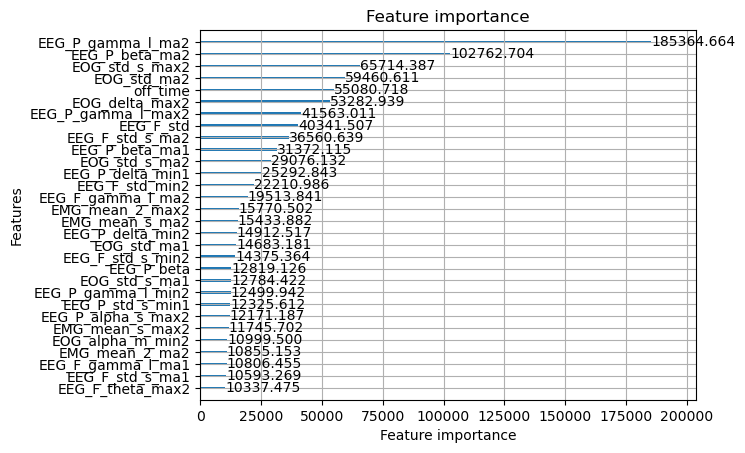

In [361]:
lgbm_3 = lgbm_o(train_3, valid_3, "3")

[I 2023-01-18 01:22:54,877] A new study created in memory with name: no-name-5ff13d96-d1d4-46df-aca9-66587ca593d5
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  14%|######4                                      | 1/7 [01:12<07:16, 72.67s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.166289	valid_1's multi_logloss: 0.433205


[I 2023-01-18 01:24:08,002] Trial 0 finished with value: 0.4332053006666555 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.4332053006666555.
feature_fraction, val_score: 0.433205:  14%|######4                                      | 1/7 [01:13<07:16, 72.67s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  14%|######4                                      | 1/7 [03:03<07:16, 72.67s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.131671	valid_1's multi_logloss: 0.439771


feature_fraction, val_score: 0.433205:  29%|############8                                | 2/7 [03:04<07:56, 95.32s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  29%|############8                                | 2/7 [04:13<07:56, 95.32s/it]

Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.130657	valid_1's multi_logloss: 0.434822


feature_fraction, val_score: 0.433205:  43%|###################2                         | 3/7 [04:14<05:34, 83.71s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  57%|#########################7                   | 4/7 [05:27<03:59, 79.78s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.156677	valid_1's multi_logloss: 0.441456


[I 2023-01-18 01:28:22,809] Trial 3 finished with value: 0.4414555431746689 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.4332053006666555.
feature_fraction, val_score: 0.433205:  57%|#########################7                   | 4/7 [05:27<03:59, 79.78s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  71%|################################1            | 5/7 [06:15<02:16, 68.35s/it]

Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.183117	valid_1's multi_logloss: 0.441255


[I 2023-01-18 01:29:10,886] Trial 4 finished with value: 0.4412548078672771 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.4332053006666555.
feature_fraction, val_score: 0.433205:  71%|################################1            | 5/7 [06:16<02:16, 68.35s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205:  71%|################################1            | 5/7 [07:52<02:16, 68.35s/it]

Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.146211	valid_1's multi_logloss: 0.442409


feature_fraction, val_score: 0.433205:  86%|######################################5      | 6/7 [07:52<01:17, 77.94s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.433205: 100%|#############################################| 7/7 [09:18<00:00, 80.73s/it]

Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.143767	valid_1's multi_logloss: 0.445646


[I 2023-01-18 01:32:13,910] Trial 6 finished with value: 0.44564585909208915 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4332053006666555.
num_leaves, val_score: 0.433205:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.0633764	valid_1's multi_logloss: 0.449781


num_leaves, val_score: 0.433205:   5%|##4                                              | 1/20 [02:18<43:52, 138.53s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  10%|#####                                             | 2/20 [03:24<28:41, 95.61s/it]

Early stopping, best iteration is:
[90]	valid_0's multi_logloss: 0.171801	valid_1's multi_logloss: 0.43579


[I 2023-01-18 01:35:38,420] Trial 8 finished with value: 0.43579041746175384 and parameters: {'num_leaves': 25}. Best is trial 8 with value: 0.43579041746175384.
num_leaves, val_score: 0.433205:  10%|#####                                             | 2/20 [03:24<28:41, 95.61s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[313]	valid_0's multi_logloss: 0.202033	valid_1's multi_logloss: 0.435902


num_leaves, val_score: 0.433205:  15%|#######5                                          | 3/20 [04:36<24:01, 84.77s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  15%|#######5                                          | 3/20 [06:11<24:01, 84.77s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.105892	valid_1's multi_logloss: 0.436112


num_leaves, val_score: 0.433205:  20%|##########                                        | 4/20 [06:12<23:44, 89.05s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  20%|##########                                        | 4/20 [08:03<23:44, 89.05s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.084793	valid_1's multi_logloss: 0.448873


num_leaves, val_score: 0.433205:  25%|############5                                     | 5/20 [08:04<24:21, 97.42s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.0554733	valid_1's multi_logloss: 0.450163


num_leaves, val_score: 0.433205:  30%|##############7                                  | 6/20 [10:17<25:34, 109.63s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.0726017	valid_1's multi_logloss: 0.439235


num_leaves, val_score: 0.433205:  35%|#################1                               | 7/20 [12:12<24:06, 111.28s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  40%|###################6                             | 8/20 [13:49<21:21, 106.80s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.116224	valid_1's multi_logloss: 0.449235


[I 2023-01-18 01:46:03,505] Trial 14 finished with value: 0.44923534035807233 and parameters: {'num_leaves': 101}. Best is trial 8 with value: 0.43579041746175384.
num_leaves, val_score: 0.433205:  40%|###################6                             | 8/20 [13:49<21:21, 106.80s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  40%|###################6                             | 8/20 [15:17<21:21, 106.80s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.105892	valid_1's multi_logloss: 0.436112


num_leaves, val_score: 0.433205:  45%|######################                           | 9/20 [15:17<18:30, 100.97s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.0602719	valid_1's multi_logloss: 0.4539


num_leaves, val_score: 0.433205:  50%|########################                        | 10/20 [17:41<19:01, 114.18s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.0622358	valid_1's multi_logloss: 0.453144


num_leaves, val_score: 0.433205:  55%|##########################4                     | 11/20 [20:19<19:08, 127.58s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.433205:  60%|############################8                   | 12/20 [21:21<14:21, 107.67s/it]

Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.193727	valid_1's multi_logloss: 0.434766


[I 2023-01-18 01:53:35,431] Trial 18 finished with value: 0.4347660788544746 and parameters: {'num_leaves': 15}. Best is trial 18 with value: 0.4347660788544746.
num_leaves, val_score: 0.433205:  60%|############################8                   | 12/20 [21:21<14:21, 107.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's multi_logloss: 0.200761	valid_1's multi_logloss: 0.42908


num_leaves, val_score: 0.429080:  65%|###############################2                | 13/20 [23:00<12:16, 105.19s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080:  70%|##################################3              | 14/20 [24:17<09:40, 96.73s/it]

Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.136537	valid_1's multi_logloss: 0.440578


[I 2023-01-18 01:56:32,083] Trial 20 finished with value: 0.44057841991837504 and parameters: {'num_leaves': 48}. Best is trial 19 with value: 0.4290804032459769.
num_leaves, val_score: 0.429080:  70%|##################################3              | 14/20 [24:18<09:40, 96.73s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080:  75%|####################################7            | 15/20 [25:12<07:00, 84.18s/it]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.240684	valid_1's multi_logloss: 0.430342


[I 2023-01-18 01:57:27,243] Trial 21 finished with value: 0.4303418005970803 and parameters: {'num_leaves': 7}. Best is trial 19 with value: 0.4290804032459769.
num_leaves, val_score: 0.429080:  75%|####################################7            | 15/20 [25:13<07:00, 84.18s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080:  80%|#######################################2         | 16/20 [26:29<05:27, 81.89s/it]

Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.132629	valid_1's multi_logloss: 0.442796


[I 2023-01-18 01:58:43,696] Trial 22 finished with value: 0.44279636208476003 and parameters: {'num_leaves': 47}. Best is trial 19 with value: 0.4290804032459769.
num_leaves, val_score: 0.429080:  80%|#######################################2         | 16/20 [26:29<05:27, 81.89s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080:  85%|#########################################6       | 17/20 [27:23<03:41, 73.67s/it]

Early stopping, best iteration is:
[259]	valid_0's multi_logloss: 0.285997	valid_1's multi_logloss: 0.436735


[I 2023-01-18 01:59:38,349] Trial 23 finished with value: 0.4367353630033107 and parameters: {'num_leaves': 3}. Best is trial 19 with value: 0.4290804032459769.
num_leaves, val_score: 0.429080:  85%|#########################################6       | 17/20 [27:24<03:41, 73.67s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080:  85%|#########################################6       | 17/20 [28:59<03:41, 73.67s/it]

Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.108806	valid_1's multi_logloss: 0.442614


num_leaves, val_score: 0.429080:  90%|############################################1    | 18/20 [28:59<02:40, 80.23s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.0896525	valid_1's multi_logloss: 0.451374


num_leaves, val_score: 0.429080:  95%|##############################################5  | 19/20 [31:01<01:32, 92.66s/it]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.429080: 100%|#################################################| 20/20 [32:15<00:00, 87.19s/it]

Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.138638	valid_1's multi_logloss: 0.435936


[I 2023-01-18 02:04:29,854] Trial 26 finished with value: 0.4359357603290901 and parameters: {'num_leaves': 41}. Best is trial 19 with value: 0.4290804032459769.
bagging, val_score: 0.429080:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.429080:   0%|                                                             | 0/10 [01:04<?, ?it/s]

Early stopping, best iteration is:
[312]	valid_0's multi_logloss: 0.239721	valid_1's multi_logloss: 0.431748


bagging, val_score: 0.429080:  10%|#####3                                               | 1/10 [01:04<09:40, 64.46s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428619:  20%|##########6                                          | 2/10 [01:46<06:48, 51.10s/it]

Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.265729	valid_1's multi_logloss: 0.428619


[I 2023-01-18 02:06:16,549] Trial 28 finished with value: 0.4286191659519155 and parameters: {'bagging_fraction': 0.46800229049861536, 'bagging_freq': 6}. Best is trial 28 with value: 0.4286191659519155.
bagging, val_score: 0.428619:  20%|##########6                                          | 2/10 [01:46<06:48, 51.10s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428619:  30%|###############9                                     | 3/10 [02:32<05:41, 48.77s/it]

Early stopping, best iteration is:
[204]	valid_0's multi_logloss: 0.268465	valid_1's multi_logloss: 0.430434


[I 2023-01-18 02:07:02,449] Trial 29 finished with value: 0.4304343149467313 and parameters: {'bagging_fraction': 0.5811862557493874, 'bagging_freq': 7}. Best is trial 28 with value: 0.4286191659519155.
bagging, val_score: 0.428619:  30%|###############9                                     | 3/10 [02:32<05:41, 48.77s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428619:  40%|#####################2                               | 4/10 [03:06<04:17, 42.95s/it]

Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.300364	valid_1's multi_logloss: 0.431228


[I 2023-01-18 02:07:36,610] Trial 30 finished with value: 0.43122834102692686 and parameters: {'bagging_fraction': 0.4189130961016959, 'bagging_freq': 7}. Best is trial 28 with value: 0.4286191659519155.
bagging, val_score: 0.428619:  40%|#####################2                               | 4/10 [03:06<04:17, 42.95s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428619:  50%|##########################5                          | 5/10 [03:50<03:36, 43.36s/it]

Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.263665	valid_1's multi_logloss: 0.433003


[I 2023-01-18 02:08:20,592] Trial 31 finished with value: 0.43300274172505704 and parameters: {'bagging_fraction': 0.47948662498454336, 'bagging_freq': 6}. Best is trial 28 with value: 0.4286191659519155.
bagging, val_score: 0.428619:  50%|##########################5                          | 5/10 [03:50<03:36, 43.36s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428619:  60%|###############################8                     | 6/10 [04:40<03:03, 45.84s/it]

Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.264027	valid_1's multi_logloss: 0.434498


[I 2023-01-18 02:09:11,242] Trial 32 finished with value: 0.4344979969393812 and parameters: {'bagging_fraction': 0.6368284218127712, 'bagging_freq': 7}. Best is trial 28 with value: 0.4286191659519155.
bagging, val_score: 0.428619:  60%|###############################8                     | 6/10 [04:41<03:03, 45.84s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428557:  60%|###############################8                     | 6/10 [05:46<03:03, 45.84s/it]

Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.237613	valid_1's multi_logloss: 0.428557


bagging, val_score: 0.428557:  70%|#####################################                | 7/10 [05:46<02:36, 52.19s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428557:  80%|##########################################4          | 8/10 [06:36<01:42, 51.49s/it]

Early stopping, best iteration is:
[171]	valid_0's multi_logloss: 0.278886	valid_1's multi_logloss: 0.43323


[I 2023-01-18 02:11:06,530] Trial 34 finished with value: 0.43323035398316173 and parameters: {'bagging_fraction': 0.7942245421049615, 'bagging_freq': 4}. Best is trial 33 with value: 0.42855658527408735.
bagging, val_score: 0.428557:  80%|##########################################4          | 8/10 [06:36<01:42, 51.49s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428557:  90%|###############################################7     | 9/10 [07:19<00:49, 49.01s/it]

Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.297663	valid_1's multi_logloss: 0.435968


[I 2023-01-18 02:11:50,052] Trial 35 finished with value: 0.4359677804505828 and parameters: {'bagging_fraction': 0.7328395084947363, 'bagging_freq': 1}. Best is trial 33 with value: 0.42855658527408735.
bagging, val_score: 0.428557:  90%|###############################################7     | 9/10 [07:20<00:49, 49.01s/it]

Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.428557: 100%|####################################################| 10/10 [07:56<00:00, 45.17s/it]

Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.304284	valid_1's multi_logloss: 0.436497


[I 2023-01-18 02:12:26,665] Trial 36 finished with value: 0.43649694029688924 and parameters: {'bagging_fraction': 0.49963236455879434, 'bagging_freq': 1}. Best is trial 33 with value: 0.42855658527408735.
feature_fraction_stage2, val_score: 0.428557:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  17%|######3                               | 1/6 [00:49<04:07, 49.59s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.274818	valid_1's multi_logloss: 0.432848


[I 2023-01-18 02:13:16,681] Trial 37 finished with value: 0.4328479623116465 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.4328479623116465.
feature_fraction_stage2, val_score: 0.428557:  17%|######3                               | 1/6 [00:50<04:07, 49.59s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  33%|############6                         | 2/6 [01:36<03:12, 48.15s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.277167	valid_1's multi_logloss: 0.434029


[I 2023-01-18 02:14:03,830] Trial 38 finished with value: 0.4340291088937908 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.4328479623116465.
feature_fraction_stage2, val_score: 0.428557:  33%|############6                         | 2/6 [01:37<03:12, 48.15s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  50%|###################                   | 3/6 [02:19<02:17, 45.69s/it]

Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.290871	valid_1's multi_logloss: 0.434657


[I 2023-01-18 02:14:46,609] Trial 39 finished with value: 0.4346571603976954 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.4328479623116465.
feature_fraction_stage2, val_score: 0.428557:  50%|###################                   | 3/6 [02:19<02:17, 45.69s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  67%|#########################3            | 4/6 [03:08<01:34, 47.13s/it]

Early stopping, best iteration is:
[141]	valid_0's multi_logloss: 0.29049	valid_1's multi_logloss: 0.438779


[I 2023-01-18 02:15:35,931] Trial 40 finished with value: 0.43877863152990987 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.4328479623116465.
feature_fraction_stage2, val_score: 0.428557:  67%|#########################3            | 4/6 [03:09<01:34, 47.13s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  83%|###############################6      | 5/6 [03:53<00:46, 46.10s/it]

Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.276063	valid_1's multi_logloss: 0.431852


[I 2023-01-18 02:16:20,188] Trial 41 finished with value: 0.43185155967533706 and parameters: {'feature_fraction': 0.552}. Best is trial 41 with value: 0.43185155967533706.
feature_fraction_stage2, val_score: 0.428557:  83%|###############################6      | 5/6 [03:53<00:46, 46.10s/it]

Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.428557:  83%|###############################6      | 5/6 [04:56<00:46, 46.10s/it]

Early stopping, best iteration is:
[323]	valid_0's multi_logloss: 0.238388	valid_1's multi_logloss: 0.432637


regularization_factors, val_score: 0.428557:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:   5%|#9                                    | 1/20 [00:55<17:31, 55.37s/it]

Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.267676	valid_1's multi_logloss: 0.432542


[I 2023-01-18 02:18:19,791] Trial 43 finished with value: 0.4325418160785849 and parameters: {'lambda_l1': 6.0474853722137665, 'lambda_l2': 0.07476384908319206}. Best is trial 43 with value: 0.4325418160785849.
regularization_factors, val_score: 0.428557:   5%|#9                                    | 1/20 [00:55<17:31, 55.37s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:  10%|###8                                  | 2/20 [01:49<16:23, 54.64s/it]

Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.257754	valid_1's multi_logloss: 0.434141


[I 2023-01-18 02:19:13,824] Trial 44 finished with value: 0.43414138890212894 and parameters: {'lambda_l1': 1.295718969705718e-07, 'lambda_l2': 8.412933670321505e-05}. Best is trial 43 with value: 0.4325418160785849.
regularization_factors, val_score: 0.428557:  10%|###8                                  | 2/20 [01:49<16:23, 54.64s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:  15%|#####7                                | 3/20 [02:44<15:28, 54.61s/it]

Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 0.260991	valid_1's multi_logloss: 0.433123


[I 2023-01-18 02:20:08,413] Trial 45 finished with value: 0.43312267113603636 and parameters: {'lambda_l1': 0.010325175171345324, 'lambda_l2': 0.00035112821588671896}. Best is trial 43 with value: 0.4325418160785849.
regularization_factors, val_score: 0.428557:  15%|#####7                                | 3/20 [02:44<15:28, 54.61s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:  20%|#######6                              | 4/20 [03:47<15:31, 58.23s/it]

Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.237613	valid_1's multi_logloss: 0.428557


[I 2023-01-18 02:21:12,170] Trial 46 finished with value: 0.4285565383886702 and parameters: {'lambda_l1': 1.3169551757040265e-05, 'lambda_l2': 2.586992439750123e-08}. Best is trial 46 with value: 0.4285565383886702.
regularization_factors, val_score: 0.428557:  20%|#######6                              | 4/20 [03:48<15:31, 58.23s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:  25%|#########5                            | 5/20 [04:37<13:44, 54.99s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.274834	valid_1's multi_logloss: 0.433023


[I 2023-01-18 02:22:01,542] Trial 47 finished with value: 0.4330225068937116 and parameters: {'lambda_l1': 0.026405694447302678, 'lambda_l2': 3.691474924339241e-07}. Best is trial 46 with value: 0.4285565383886702.
regularization_factors, val_score: 0.428557:  25%|#########5                            | 5/20 [04:37<13:44, 54.99s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.428557:  30%|###########4                          | 6/20 [05:29<12:37, 54.10s/it]

Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.26469	valid_1's multi_logloss: 0.434617


[I 2023-01-18 02:22:53,794] Trial 48 finished with value: 0.43461681024036103 and parameters: {'lambda_l1': 0.12362286854118008, 'lambda_l2': 1.305831908160761e-06}. Best is trial 46 with value: 0.4285565383886702.
regularization_factors, val_score: 0.428557:  30%|###########4                          | 6/20 [05:29<12:37, 54.10s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 0.226309	valid_1's multi_logloss: 0.4273


regularization_factors, val_score: 0.427300:  35%|#############3                        | 7/20 [06:45<13:15, 61.18s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.427300:  40%|###############2                      | 8/20 [07:38<11:43, 58.59s/it]

Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.265832	valid_1's multi_logloss: 0.438523


[I 2023-01-18 02:25:02,600] Trial 50 finished with value: 0.43852265548923297 and parameters: {'lambda_l1': 0.8493979272376354, 'lambda_l2': 1.9459076108262797e-05}. Best is trial 49 with value: 0.4273000149582804.
regularization_factors, val_score: 0.427300:  40%|###############2                      | 8/20 [07:38<11:43, 58.59s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's multi_logloss: 0.217008	valid_1's multi_logloss: 0.433678


regularization_factors, val_score: 0.427300:  45%|#################1                    | 9/20 [08:59<12:00, 65.51s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.427300:  50%|##################5                  | 10/20 [09:50<10:12, 61.20s/it]

Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.273237	valid_1's multi_logloss: 0.435547


[I 2023-01-18 02:27:14,901] Trial 52 finished with value: 0.43554721901038507 and parameters: {'lambda_l1': 0.014501062416205416, 'lambda_l2': 0.14856610150982558}. Best is trial 49 with value: 0.4273000149582804.
regularization_factors, val_score: 0.427300:  50%|##################5                  | 10/20 [09:50<10:12, 61.20s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.427300:  55%|####################3                | 11/20 [10:38<08:35, 57.25s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.277743	valid_1's multi_logloss: 0.433065


[I 2023-01-18 02:28:03,183] Trial 53 finished with value: 0.433064941098873 and parameters: {'lambda_l1': 1.828952210309535e-08, 'lambda_l2': 7.175138081096847}. Best is trial 49 with value: 0.4273000149582804.
regularization_factors, val_score: 0.427300:  55%|####################3                | 11/20 [10:39<08:35, 57.25s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.427300:  55%|####################3                | 11/20 [11:44<08:35, 57.25s/it]

Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.237613	valid_1's multi_logloss: 0.428557


regularization_factors, val_score: 0.427300:  60%|######################2              | 12/20 [11:45<07:59, 59.90s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 0.226309	valid_1's multi_logloss: 0.427301


regularization_factors, val_score: 0.427300:  65%|########################             | 13/20 [12:56<07:22, 63.27s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[458]	valid_0's multi_logloss: 0.215165	valid_1's multi_logloss: 0.425768


regularization_factors, val_score: 0.425768:  70%|#########################9           | 14/20 [14:16<06:50, 68.35s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 0.226309	valid_1's multi_logloss: 0.427301


regularization_factors, val_score: 0.425768:  75%|###########################7         | 15/20 [15:28<05:47, 69.52s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425768:  80%|#############################6       | 16/20 [16:21<04:18, 64.67s/it]

Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.264729	valid_1's multi_logloss: 0.432139


[I 2023-01-18 02:33:45,909] Trial 58 finished with value: 0.4321393190910405 and parameters: {'lambda_l1': 0.0005421675454962038, 'lambda_l2': 0.0015159245372905739}. Best is trial 56 with value: 0.425767628765204.
regularization_factors, val_score: 0.425768:  80%|#############################6       | 16/20 [16:21<04:18, 64.67s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 0.226366	valid_1's multi_logloss: 0.427604


regularization_factors, val_score: 0.425768:  85%|###############################4     | 17/20 [17:35<03:21, 67.27s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425768:  90%|#################################3   | 18/20 [18:28<02:06, 63.05s/it]

Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.272465	valid_1's multi_logloss: 0.434099


[I 2023-01-18 02:35:52,419] Trial 60 finished with value: 0.434099262304019 and parameters: {'lambda_l1': 3.511133044771999e-05, 'lambda_l2': 1.7516660526955783e-07}. Best is trial 56 with value: 0.425767628765204.
regularization_factors, val_score: 0.425768:  90%|#################################3   | 18/20 [18:28<02:06, 63.05s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425768:  95%|###################################1 | 19/20 [19:16<00:58, 58.57s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.274385	valid_1's multi_logloss: 0.433679


[I 2023-01-18 02:36:40,553] Trial 61 finished with value: 0.43367942573879686 and parameters: {'lambda_l1': 1.2203828170469098e-06, 'lambda_l2': 0.004948121709838581}. Best is trial 56 with value: 0.425767628765204.
regularization_factors, val_score: 0.425768:  95%|###################################1 | 19/20 [19:16<00:58, 58.57s/it]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.425768: 100%|#####################################| 20/20 [20:06<00:00, 56.14s/it]

Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 0.26448	valid_1's multi_logloss: 0.433077


[I 2023-01-18 02:37:31,157] Trial 62 finished with value: 0.4330770915543993 and parameters: {'lambda_l1': 1.1213594328963017e-07, 'lambda_l2': 1.2595048719111735e-05}. Best is trial 56 with value: 0.425767628765204.
min_data_in_leaf, val_score: 0.425768:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425768:  20%|#########                                    | 1/5 [00:53<03:32, 53.05s/it]

Early stopping, best iteration is:
[215]	valid_0's multi_logloss: 0.264196	valid_1's multi_logloss: 0.437073


[I 2023-01-18 02:38:24,639] Trial 63 finished with value: 0.4370725800973699 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.4370725800973699.
min_data_in_leaf, val_score: 0.425768:  20%|#########                                    | 1/5 [00:53<03:32, 53.05s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425768:  40%|##################                           | 2/5 [01:46<02:40, 53.58s/it]

Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.275221	valid_1's multi_logloss: 0.440061


[I 2023-01-18 02:39:18,595] Trial 64 finished with value: 0.4400609373268996 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.4370725800973699.
min_data_in_leaf, val_score: 0.425768:  40%|##################                           | 2/5 [01:47<02:40, 53.58s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425768:  60%|###########################                  | 3/5 [02:36<01:43, 51.69s/it]

Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.276219	valid_1's multi_logloss: 0.433884


[I 2023-01-18 02:40:08,030] Trial 65 finished with value: 0.4338838264935865 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.4338838264935865.
min_data_in_leaf, val_score: 0.425768:  60%|###########################                  | 3/5 [02:36<01:43, 51.69s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425768:  80%|####################################         | 4/5 [03:19<00:48, 48.41s/it]

Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 0.2922	valid_1's multi_logloss: 0.440289


[I 2023-01-18 02:40:51,492] Trial 66 finished with value: 0.44028850686851206 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.4338838264935865.
min_data_in_leaf, val_score: 0.425768:  80%|####################################         | 4/5 [03:20<00:48, 48.41s/it]

Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.425768: 100%|#############################################| 5/5 [04:01<00:00, 45.81s/it]

Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.303647	valid_1's multi_logloss: 0.442814


[I 2023-01-18 02:41:32,590] Trial 67 finished with value: 0.4428144138410917 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.4338838264935865.
min_data_in_leaf, val_score: 0.425768: 100%|#############################################| 5/5 [04:01<00:00, 48.28s/it]


Best params: {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'seed': 1234, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0001378677896784603, 'lambda_l2': 5.29912273179931e-07, 'num_leaves': 4, 'feature_fraction': 0.6, 'bagging_fraction': 0.7268887338580828, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [24, 26]}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     15533
           1       0.47      0.37      0.41      2699
           2       0.78      0.85      0.81      9032
           3       0.65      0.78      0.71      1580
           4       0.86      0.65      0.74      3859

    accuracy                           0.83     32703
   macro avg       0.74      0.72      0.72     32703
weighted avg       0.83      0.83      0.83     32703

0.8334097789193652


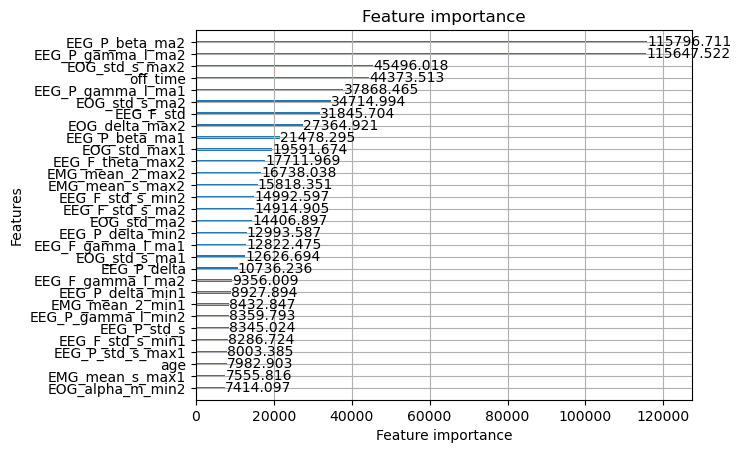

In [362]:
lgbm_4 = lgbm_o(train_4, valid_4, "4")

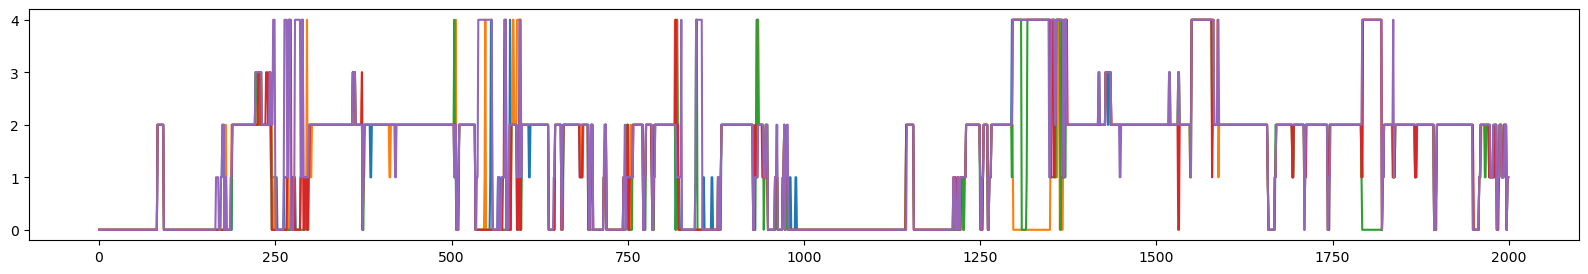

In [363]:
plt.figure(figsize=(20,3))
plt.plot(sample_submission_df["condition_0"][0:2000])
plt.plot(sample_submission_df["condition_1"][0:2000])
plt.plot(sample_submission_df["condition_2"][0:2000])
plt.plot(sample_submission_df["condition_3"][0:2000])
plt.plot(sample_submission_df["condition_4"][0:2000])

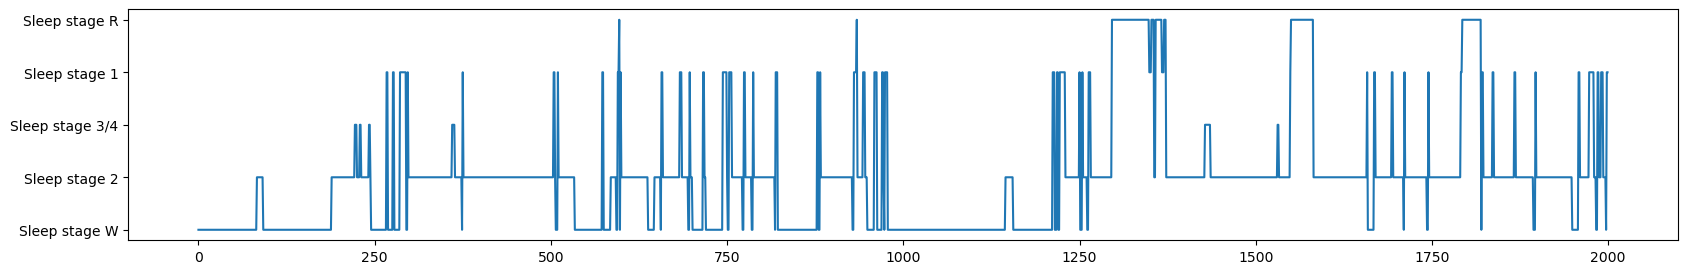

In [364]:
# 多数決
pred0 = np.array(sample_submission_df["condition_0"])
pred1 = np.array(sample_submission_df["condition_1"])
pred2 = np.array(sample_submission_df["condition_2"])
pred3 = np.array(sample_submission_df["condition_3"])
pred4 = np.array(sample_submission_df["condition_4"])
preds = np.array([pred0, pred1, pred2, pred3, pred4])

pred = [*map(lambda x:np.argmax(np.bincount(x)), preds.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [365]:
sample_submission_df_maj.to_csv("submit_20230117_2.csv", index=False)
#LB 0.819

In [366]:
#XGBoost(Optuna)
import xgboost as xgb
import optuna

#Objective関数の設定
def objective(trial):
    train_x = train.drop(["id", "meas_time", "condition"], axis=1)
    valid_x = valid.drop(["id", "meas_time", "condition"], axis=1)

    train_x['off_time'] = train_x['off_time'].astype(int)
    valid_x['off_time'] = valid_x['off_time'].astype(int)

    train_y = train["condition"].map(LABEL2ID)
    valid_y = valid["condition"].map(LABEL2ID)
    
    params = {
        'objective': 'multi:softmax',
        'num_class': 5,
        'subsample': 0.5,
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': 0.3
    }

    model = xgb.XGBClassifier(**params)
    model.fit(train_x, train_y)

    pred = model.predict(valid_x)

    accuracy = accuracy_score(valid_y, pred)
    return (1-accuracy)

def xgb_o(train, valid, label):
    train = train
    valid = valid

    study = optuna.create_study()
    study.optimize(objective, n_trials=30)
    
    #best_paramで学習
    best_params = {
        'objective': 'multi:softmax',
        'num_class': 5,
        'max_depth': study.best_params["max_depth"],
        'n_estimators': study.best_params['n_estimators'],
        'learning_rate': 0.03
    }

    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(train_x, train_y)

    val_preds = best_model.predict(valid_x)
    
    #時系列補正
    #一つ前と一つ後の判定が同じときは間の判定状態を1つ前の判定に揃える
    #覚醒→レムのときレムの判定は覚醒に
    val_preds_2 = val_preds.copy()

    for i in range(len(val_preds_2)-2):
        if val_preds_2[i] == val_preds_2[i+2]:
            val_preds_2[i+1] = val_preds_2[i]

        if (val_preds_2[i+1] == 4) & (val_preds_2[i] == 0):
            val_preds_2[i+1] = 0

    print(classification_report(valid_y, val_preds_2))
    print(accuracy_score(valid_y, val_preds_2)) 
        
    #テストデータ予測
    test_df_x = new_test_df_f_2.drop(["id", "meas_time"], axis=1)
    test_df_x['off_time'] = test_df_x['off_time'].astype(int)
    pred_test =  best_model.predict(test_df_x)

    #時系列補正
    pred_test_2 = pred_test.copy()

    for i in range(len(pred_test_2)-2):
        if pred_test_2[i] == pred_test_2[i+2]:
            pred_test_2[i+1] = pred_test_2[i]

        if (pred_test_2[i+1] == 4) & (pred_test_2[i] == 0):
            pred_test_2[i+1] = 0

    sample_submission_df["condition_"+label+"xgb"] = pred_test_2

    return best_model    


In [369]:
#XGBoost(GridSearch CV)
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def xgb_cv(train, valid, label):
    train_x = train.drop(["id", "meas_time", "condition"], axis=1)
    valid_x = valid.drop(["id", "meas_time", "condition"], axis=1)

    train_x['off_time'] = train_x['off_time'].astype(int)
    valid_x['off_time'] = valid_x['off_time'].astype(int)

    train_y = train["condition"].map(LABEL2ID)
    valid_y = valid["condition"].map(LABEL2ID)
    
    model = xgb.XGBClassifier()
    
    params = {'objective': ['multi:softmax'],
              'num_class': [5],
              'max_depth': [5,10,20],
              'n_estimators': [50,200,500],
              'learning_rate': [0.03]}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    
    xgb_cv = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          cv=skf,
                          scoring="accuracy",
                          verbose=1)

    eval_set = [(valid_x, valid_y)]
    
    xgb_cv.fit(train_x, train_y,
               eval_set=eval_set,
               early_stopping_rounds=100,
               verbose=100)
    
    val_preds = xgb_cv.predict(valid_x)
    
    #時系列補正
    #一つ前と一つ後の判定が同じときは間の判定状態を1つ前の判定に揃える
    #覚醒→レムのときレムの判定は覚醒に
    val_preds_2 = val_preds.copy()

    for i in range(len(val_preds_2)-2):
        if val_preds_2[i] == val_preds_2[i+2]:
            val_preds_2[i+1] = val_preds_2[i]

        if (val_preds_2[i+1] == 4) & (val_preds_2[i] == 0):
            val_preds_2[i+1] = 0

    print(classification_report(valid_y, val_preds_2))
    print(accuracy_score(valid_y, val_preds_2)) 
        
    #テストデータ予測
    test_df_x = new_test_df_f_2.drop(["id", "meas_time"], axis=1)
    test_df_x['off_time'] = test_df_x['off_time'].astype(int)
    pred_test =  xgb_cv.predict(test_df_x)

    #時系列補正
    pred_test_2 = pred_test.copy()

    for i in range(len(pred_test_2)-2):
        if pred_test_2[i] == pred_test_2[i+2]:
            pred_test_2[i+1] = pred_test_2[i]

        if (pred_test_2[i+1] == 4) & (pred_test_2[i] == 0):
            pred_test_2[i+1] = 0

    sample_submission_df["condition_"+label+"xgb"] = pred_test_2

    return xgb_cv    

In [370]:
xgb_0 = xgb_cv(train_0, valid_0, "0")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-mlogloss:1.56123
[49]	validation_0-mlogloss:0.67673
[0]	validation_0-mlogloss:1.56169
[49]	validation_0-mlogloss:0.67826
[0]	validation_0-mlogloss:1.56161
[49]	validation_0-mlogloss:0.67900
[0]	validation_0-mlogloss:1.56123
[100]	validation_0-mlogloss:0.48846
[199]	validation_0-mlogloss:0.40760
[0]	validation_0-mlogloss:1.56169
[100]	validation_0-mlogloss:0.49002
[199]	validation_0-mlogloss:0.40917
[0]	validation_0-mlogloss:1.56161
[100]	validation_0-mlogloss:0.48913
[199]	validation_0-mlogloss:0.40807
[0]	validation_0-mlogloss:1.56123
[100]	validation_0-mlogloss:0.48846
[200]	validation_0-mlogloss:0.40731
[300]	validation_0-mlogloss:0.39276
[400]	validation_0-mlogloss:0.38758
[499]	validation_0-mlogloss:0.38673
[0]	validation_0-mlogloss:1.56169
[100]	validation_0-mlogloss:0.49002
[200]	validation_0-mlogloss:0.40876
[300]	validation_0-mlogloss:0.39202
[400]	validation_0-mlogloss:0.38747
[499]	validation_0-mlog

KeyboardInterrupt: 

In [ ]:
xgb_1 = xgb_cv(train_1, valid_1, "1")

In [ ]:
xgb_2 = xgb_cv(train_2, valid_2, "2")

In [ ]:
xgb_3 = xgb_cv(train_3, valid_3, "3")

In [ ]:
xgb_4 = xgb_cv(train_4, valid_4, "4")

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(sample_submission_df["condition_0xgb"][0:2000])
plt.plot(sample_submission_df["condition_1xgb"][0:2000])
plt.plot(sample_submission_df["condition_2xgb"][0:2000])
plt.plot(sample_submission_df["condition_3xgb"][0:2000])
plt.plot(sample_submission_df["condition_4xgb"][0:2000])

In [ ]:
# 多数決(XGBのみ)
pred0xgb = np.array(sample_submission_df["condition_0xgb"])
pred1xgb = np.array(sample_submission_df["condition_1xgb"])
pred2xgb = np.array(sample_submission_df["condition_2xgb"])
pred3xgb = np.array(sample_submission_df["condition_3xgb"])
pred4xgb = np.array(sample_submission_df["condition_4xgb"])
preds = np.array([pred0xgb, pred1xgb, pred2xgb, pred3xgb, pred4xgb])

pred = [*map(lambda x:np.argmax(np.bincount(x)), preds.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [ ]:
sample_submission_df_maj.to_csv("submit_20230118-1.csv", index=False)
#LB 0.815

In [ ]:
# 多数決(LightGBM+XGB)
pred0 = np.array(sample_submission_df["condition_0"])
pred1 = np.array(sample_submission_df["condition_1"])
pred2 = np.array(sample_submission_df["condition_2"])
pred3 = np.array(sample_submission_df["condition_3"])
pred4 = np.array(sample_submission_df["condition_4"])
pred0xgb = np.array(sample_submission_df["condition_0xgb"])
pred1xgb = np.array(sample_submission_df["condition_1xgb"])
pred2xgb = np.array(sample_submission_df["condition_2xgb"])
pred3xgb = np.array(sample_submission_df["condition_3xgb"])
pred4xgb = np.array(sample_submission_df["condition_4xgb"])
preds = np.array([pred0, pred1, pred2, pred3, pred4,
                 pred0xgb, pred1xgb, pred2xgb, pred3xgb, pred4xgb])

pred = [*map(lambda x:np.argmax(np.bincount(x)), preds.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [ ]:
sample_submission_df_maj.to_csv("submit_20230118_2.csv", index=False)
#LB 0.814

In [ ]:
#RandomForest(GridSearch CV)
from sklearn.ensemble import RandomForestClassifier as RFC

def rfc_cv(train, valid, label):
    train_x = train.drop(["id", "meas_time", "condition"], axis=1)
    valid_x = valid.drop(["id", "meas_time", "condition"], axis=1)

    train_x['off_time'] = train_x['off_time'].astype(int)
    valid_x['off_time'] = valid_x['off_time'].astype(int)

    train_y = train["condition"].map(LABEL2ID)
    valid_y = valid["condition"].map(LABEL2ID)
    
    search_params = {'max_features':['sqrt', 'log2'],
                     'n_estimators': [50, 200, 500],
                     'max_depth': [5, 10, 200],
                     'random_state': [1234],
                    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    
    rfc_cv = GridSearchCV(estimator=RFC(), 
                          param_grid=search_params, 
                          cv=skf,
                          scoring="accuracy",
                          verbose=1)

    rfc_cv.fit(train_x, train_y)
    
    val_preds = rfc_cv.predict(valid_x)
    
    #時系列補正
    #一つ前と一つ後の判定が同じときは間の判定状態を1つ前の判定に揃える
    #覚醒→レムのときレムの判定は覚醒に
    val_preds_2 = val_preds.copy()

    for i in range(len(val_preds_2)-2):
        if val_preds_2[i] == val_preds_2[i+2]:
            val_preds_2[i+1] = val_preds_2[i]

        if (val_preds_2[i+1] == 4) & (val_preds_2[i] == 0):
            val_preds_2[i+1] = 0

    print(classification_report(valid_y, val_preds_2))
    print(accuracy_score(valid_y, val_preds_2)) 
        
    #テストデータ予測
    test_df_x = new_test_df_f_2.drop(["id", "meas_time"], axis=1)
    test_df_x['off_time'] = test_df_x['off_time'].astype(int)
    pred_test =  rfc_cv.predict(test_df_x)

    #時系列補正
    pred_test_2 = pred_test.copy()

    for i in range(len(pred_test_2)-2):
        if pred_test_2[i] == pred_test_2[i+2]:
            pred_test_2[i+1] = pred_test_2[i]

        if (pred_test_2[i+1] == 4) & (pred_test_2[i] == 0):
            pred_test_2[i+1] = 0

    sample_submission_df["condition_"+label+"rfc"] = pred_test_2

    return rfc_cv

In [ ]:
rfc_0 = rfc_cv(train_0, valid_0, "0")

In [ ]:
rfc_1 = rfc_cv(train_1, valid_1, "1")

In [ ]:
rfc_2 = rfc_cv(train_2, valid_2, "2")

In [ ]:
rfc_3 = rfc_cv(train_3, valid_3, "3")

In [ ]:
rfc_4 = rfc_cv(train_4, valid_4, "4")

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(sample_submission_df["condition_0rfc"][0:2000])
plt.plot(sample_submission_df["condition_1rfc"][0:2000])
plt.plot(sample_submission_df["condition_2rfc"][0:2000])
plt.plot(sample_submission_df["condition_3rfc"][0:2000])
plt.plot(sample_submission_df["condition_4rfc"][0:2000])

In [ ]:
# 多数決(RFCのみ)
pred0rfc = np.array(sample_submission_df["condition_0rfc"])
pred1rfc = np.array(sample_submission_df["condition_1rfc"])
pred2rfc = np.array(sample_submission_df["condition_2rfc"])
pred3rfc = np.array(sample_submission_df["condition_3rfc"])
pred4rfc = np.array(sample_submission_df["condition_4rfc"])
preds = np.array([pred0rfc, pred1rfc, pred2rfc, pred3rfc, pred4rfc])

pred = [*map(lambda x:np.argmax(np.bincount(x)), preds.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [ ]:
sample_submission_df_maj.to_csv("submit_20230119_1.csv", index=False)
#LB 0.782

In [ ]:
# 多数決(LightGBM+XGB+RFR)
pred0 = np.array(sample_submission_df["condition_0"])
pred1 = np.array(sample_submission_df["condition_1"])
pred2 = np.array(sample_submission_df["condition_2"])
pred3 = np.array(sample_submission_df["condition_3"])
pred4 = np.array(sample_submission_df["condition_4"])
pred0xgb = np.array(sample_submission_df["condition_0xgb"])
pred1xgb = np.array(sample_submission_df["condition_1xgb"])
pred2xgb = np.array(sample_submission_df["condition_2xgb"])
pred3xgb = np.array(sample_submission_df["condition_3xgb"])
pred4xgb = np.array(sample_submission_df["condition_4xgb"])
pred0rfc = np.array(sample_submission_df["condition_0rfc"])
pred1rfc = np.array(sample_submission_df["condition_1rfc"])
pred2rfc = np.array(sample_submission_df["condition_2rfc"])
pred3rfc = np.array(sample_submission_df["condition_3rfc"])
pred4rfc = np.array(sample_submission_df["condition_4rfc"])
preds = np.array([pred0, pred1, pred2, pred3, pred4,
                 pred0xgb, pred1xgb, pred2xgb, pred3xgb, pred4xgb,
                 pred0rfc, pred1rfc, pred2rfc, pred3rfc, pred4rfc])

pred = [*map(lambda x:np.argmax(np.bincount(x)), preds.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [ ]:
sample_submission_df_maj.to_csv("submit_20230119_2.csv", index=False)
#LB 0.811

In [ ]:
# 多数決(LightGBMの多数決+XGBの多数決+RFRの多数決)
pred0 = np.array(sample_submission_df["condition_0"])
pred1 = np.array(sample_submission_df["condition_1"])
pred2 = np.array(sample_submission_df["condition_2"])
pred3 = np.array(sample_submission_df["condition_3"])
pred4 = np.array(sample_submission_df["condition_4"])
pred0xgb = np.array(sample_submission_df["condition_0xgb"])
pred1xgb = np.array(sample_submission_df["condition_1xgb"])
pred2xgb = np.array(sample_submission_df["condition_2xgb"])
pred3xgb = np.array(sample_submission_df["condition_3xgb"])
pred4xgb = np.array(sample_submission_df["condition_4xgb"])
pred0rfc = np.array(sample_submission_df["condition_0rfc"])
pred1rfc = np.array(sample_submission_df["condition_1rfc"])
pred2rfc = np.array(sample_submission_df["condition_2rfc"])
pred3rfc = np.array(sample_submission_df["condition_3rfc"])
pred4rfc = np.array(sample_submission_df["condition_4rfc"])

pred_lgbm = np.array([pred0, pred1, pred2, pred3, pred4])
pred_xgb = np.array([pred0xgb, pred1xgb, pred2xgb, pred3xgb, pred4xgb])
pred_rfc = np.array([pred0rfc, pred1rfc, pred2rfc, pred3rfc, pred4rfc])

pred_lgbm = [*map(lambda x:np.argmax(np.bincount(x)), pred_lgbm.T)]
pred_xgb = [*map(lambda x:np.argmax(np.bincount(x)), pred_xgb.T)]
pred_rfc = [*map(lambda x:np.argmax(np.bincount(x)), pred_rfc.T)]

pred = np.array([pred_lgbm, pred_xgb, pred_rfc])

pred = [*map(lambda x:np.argmax(np.bincount(x)), pred.T)]

sample_submission_df_maj = pd.read_csv(DATA_DIR/"sample_submission.csv", parse_dates=[1])
sample_submission_df_maj["condition"] = pred

#時系列補正
for i in range(len(sample_submission_df_maj)-2):
    if sample_submission_df_maj["condition"][i] == sample_submission_df_maj["condition"][i+2]:
        sample_submission_df_maj["condition"][i+1] = sample_submission_df_maj["condition"][i]
        
    if (sample_submission_df_maj["condition"][i+1] == 4) & (sample_submission_df_maj["condition"][i] == 0):
        sample_submission_df_maj["condition"][i+1] = 0      

sample_submission_df_maj["condition"] = sample_submission_df_maj["condition"].map(ID2LABEL)

plt.figure(figsize=(20,3))
plt.plot(sample_submission_df_maj["condition"][0:2000])

#sample_submission_df_maj["condition"].value_counts()

In [ ]:
sample_submission_df_maj.to_csv("submit_20230119-3.csv", index=False)
#LB 0.811